# Intro
---
##### 전반적으로 다량의 앙상블과 유전 알고리즘을 사용해 스크롤의 양이 매우 많음


- 유튜브에서 인기 영상에 오른 영상들에 대한 데이터를 기반으로 어떤 feature가 Views에 영향을 미치는지를 파악하고자 회귀 분석
- 기본적으로 앙상블 최적화를 위해 총 6개의 모델(ElasticNet, RF, MLP, XGB, SVM, KNN)에 각각 Grid / Randomized search 를 사용했다.
- 이후 이 모델들을 Voting 앙상블 하였고, 해당 모델과 Genetic Algorithm을 활용해 일반적인 or 인기있는 영상이 되기 위한 각 feature별 조건을 세부적으로 확인 했다.
- 이때, Genetic Algorithm 을 적용해 모든 feature는 동일한 상황에서 특정 feature 가 변했을때, Views가 어떻게 변동되는지를 확인할 수 있었다. 
- 다만 데이터 자체가 Views를 예측하기에는 적합하지 않은 feature들이 많아서 정확한 모델링이 어려웠다는 한계점이 존재한다.

# 모듈 설치 및 호출

In [1]:
#  유전 알고리즘 모듈 설치
#!pip install geneticalgorithm

In [2]:
# 기본 모듈
import os
import copy
import math
import datetime
import itertools
import requests
from io import BytesIO
from random import randint
import chardet
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

# 시각화 관련
import matplotlib.pyplot as plt
from PIL import Image

# 모델 관련
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from xgboost import XGBRegressor

# GA 
from geneticalgorithm import geneticalgorithm


# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = '{:.2f}'.format

# 파일 로드위한 directory 확인 및 현재 경로로 설정
a = os.getcwd()
os.chdir(a)

# 데이터 로드 및 EDA
---

- 데이터 출처 : 케글 (https://www.kaggle.com/datasnaek/youtube-new)
- 한국 데이터를 사용

In [3]:
filename = 'KRvideos.csv'

with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())
    print('Encoding type:', result['encoding'])

Encoding type: UTF-8-SIG


- video_id : 유튜브 영상 고유 id
- trending_date : 데이터가 집계된 날짜
- title : 영상 제목
- channel_title : 영상을 올린 채널명
- category_id : 카테고리 아이디 )
- publish_time : 영상을 올린 시간
- tags : 영상에 달린 태그
- views : 조회수(target value)
- likes : 좋아요 수
- dislikes : 싫어요 수
- comment_count : 댓글 수
- thumbnail_link : 썸네일 링크
- comments_disabled : 댓글을 막았는지 여부 (False가 긍정 =  댓글이 있다.)
- ratings_disabled : 평점 여부 (False가 긍정 = rating이 있다.)
- video_error_or_removed : 영상 삭제 여부 (True가 삭제된 것)
- description : 영상에 대한 설명

In [4]:
# 데이터 출처의 KR_category_id.json에서 가져옴
category_id_code = {'1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',                    
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'}

In [5]:
raw_data = pd.read_csv(filename, engine='python')
raw_data.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36897 entries, 0 to 36896
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                36741 non-null  object
 1   trending_date           34730 non-null  object
 2   title                   34592 non-null  object
 3   channel_title           34575 non-null  object
 4   category_id             34572 non-null  object
 5   publish_time            34568 non-null  object
 6   tags                    34568 non-null  object
 7   views                   34568 non-null  object
 8   likes                   34568 non-null  object
 9   dislikes                34568 non-null  object
 10  comment_count           34568 non-null  object
 11  thumbnail_link          34568 non-null  object
 12  comments_disabled       34567 non-null  object
 13  ratings_disabled        34567 non-null  object
 14  video_error_or_removed  34567 non-null  object
 15  de

- description에 결측치가 있을 것으로 예상된다.

In [7]:
# 설명이 없는 영상의 수
raw_data['description'].isnull().sum()

5493

In [8]:
# 댓글이 없는 영상의 수
print(f'댓글이 없는 영상의 수 :', raw_data['comments_disabled'][raw_data['comments_disabled'] == True].sum(),'개')

댓글이 없는 영상의 수 : 511 개


In [9]:
# 평점이 없는 영상의 수
print(f'평점이 없는 영상의 수 :', raw_data['ratings_disabled'][raw_data['ratings_disabled'] == True].sum(),'개')

평점이 없는 영상의 수 : 1400 개


In [10]:
# 삭제된 영상의 수
print(f'삭제된 영상의 수 :',raw_data['video_error_or_removed'][raw_data['video_error_or_removed'] == True].sum(),'개')

삭제된 영상의 수 : 41 개


In [11]:
# 각 컬럼별 중복된 데이터의 수 출력
for i in list(raw_data):
    print(f'컬럼명 :',i)
    print(f'중복된 데이터의 수 :\n',raw_data[i].duplicated().value_counts())
    print('\n')

컬럼명 : video_id
중복된 데이터의 수 :
 True     20563
False    16334
Name: video_id, dtype: int64


컬럼명 : trending_date
중복된 데이터의 수 :
 True     36623
False      274
Name: trending_date, dtype: int64


컬럼명 : title
중복된 데이터의 수 :
 True     20529
False    16368
Name: title, dtype: int64


컬럼명 : channel_title
중복된 데이터의 수 :
 True     32849
False     4048
Name: channel_title, dtype: int64


컬럼명 : category_id
중복된 데이터의 수 :
 True     36875
False       22
Name: category_id, dtype: int64


컬럼명 : publish_time
중복된 데이터의 수 :
 True     21033
False    15864
Name: publish_time, dtype: int64


컬럼명 : tags
중복된 데이터의 수 :
 True     26104
False    10793
Name: tags, dtype: int64


컬럼명 : views
중복된 데이터의 수 :
 False    30692
True      6205
Name: views, dtype: int64


컬럼명 : likes
중복된 데이터의 수 :
 True     27421
False     9476
Name: likes, dtype: int64


컬럼명 : dislikes
중복된 데이터의 수 :
 True     34820
False     2077
Name: dislikes, dtype: int64


컬럼명 : comment_count
중복된 데이터의 수 :
 True     32206
False     4691
Name: comment_count, dtype: 

video_id가 중복된 것이 많아 삭제해줄 필요가 있어 보인다.

In [12]:
df = raw_data[raw_data['comments_disabled'] != 1] # True를 삭제(댓글없는 영상)
df = df[df['ratings_disabled'] != 1] # True를 삭제(별점 없는 영상)
df = df[df['video_error_or_removed'] != 1] # True를 삭제(삭제된 영상)
df = df[df['tags'] != '[none]'] # tag 중 none으로 되어있는 데이터 drop (tag 수도 측정 지표로 사용해야 하는데 string이라서 count됨)
print(df.info(), '\n')
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28408 entries, 0 to 36896
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                28252 non-null  object
 1   trending_date           26241 non-null  object
 2   title                   26103 non-null  object
 3   channel_title           26086 non-null  object
 4   category_id             26083 non-null  object
 5   publish_time            26079 non-null  object
 6   tags                    26079 non-null  object
 7   views                   26079 non-null  object
 8   likes                   26079 non-null  object
 9   dislikes                26079 non-null  object
 10  comment_count           26079 non-null  object
 11  thumbnail_link          26079 non-null  object
 12  comments_disabled       26078 non-null  object
 13  ratings_disabled        26078 non-null  object
 14  video_error_or_removed  26078 non-null  object
 15  de

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [13]:
print('Before dropna:', len(df))
df = df.dropna() # null값 삭제

print('After  dropna:', len(df))
df = df.reset_index(drop=True)

# 약 1300여개의 데이터가 삭제 됨

Before dropna: 28408
After  dropna: 24768


# 3. 피쳐 엔지니어링

## 썸네일(thumnail_link) 데이터 가공

- **한번 실행했었다면 재실행 하지 말고 및의 csv파일 다운받아서 진행할 것(용량 너무 커서 오래걸림)** 
<br><br>
- Yutube에서 썸네일은 매우 중요한 요소중 하나임이 일반적으로 알려져 있다. 
- 하지만 현재 df에서는 썸네일 링크밖에 없어서 썸네일에 대한 요소를 활용하기가 어렵다.
- 이를 RGB의 intensity value를 추출해서 각 영상의 썸네일 데이터를 구분할 수 있도록 할 것.

In [14]:
# 파일이 없다면 전처리 시작
if not os.path.exists('rgb_df.csv'):
    r_avg = []
    g_avg = []
    b_avg = []

    for i in tqdm_notebook(range(len(df))):
        url = df['thumbnail_link'][i] 
        res = requests.get(url) # 썸네일 링크 가져오기
        request_get_img = Image.open(BytesIO(res.content)) # res.content로 링크의 내용 불러오기
        red, green, blue = request_get_img.split() # 이미지의 RGB 실제 array값 받아오기

        # array값의 평균을 numpy로 계산
        r_avg.append(int(np.average(red))) 
        g_avg.append(int(np.average(green)))
        b_avg.append(int(np.average(blue)))

    # 생성한 데이터를 컬럼으로 생성하여 적용
    df['r_avg'] = r_avg
    df['g_avg'] = g_avg
    df['b_avg'] = b_avg
# file이 존재하면 전처리 생략하고 기존 파일 load
else:
    df = pd.read_csv('rgb_df.csv')

- RGB의 평균외에 표준편차, histogram의 bin값 등을 추출할수 도 있지만, 데이터의 차원수를 과도하게 늘리지는 것을 피하기 위해 일단 평균값만 추출 

In [15]:
# 파일이 없다면 저장 (최초 1회 작동)
if not os.path.exists('rgb_df.csv'):
    df.to_csv('rgb_df.csv', encoding='utf8',index=False) # 중간저장1

# 파일이 있다면 위에서 load 한 파일 그대로 사용    
else :
    pass
    

# 결과 확인
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...,193,193,193
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61


- RGB값이 모두 193으로 동일하게 나오는 데이터가 있다.
- 확인해보니 썸네일 이미지가 없는 데이터이다. (아래 그림 참조)
- 이러한 데이터가 몇개인지 확인해볼 필요가 있다.
![image](https://user-images.githubusercontent.com/74717033/139681191-ad0a98a8-d091-4578-9085-5977680e52dc.png)

In [16]:
df = pd.read_csv('rgb_df.csv')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24768 entries, 0 to 24767
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                24768 non-null  object
 1   trending_date           24768 non-null  object
 2   title                   24768 non-null  object
 3   channel_title           24768 non-null  object
 4   category_id             24768 non-null  int64 
 5   publish_time            24768 non-null  object
 6   tags                    24768 non-null  object
 7   views                   24768 non-null  int64 
 8   likes                   24768 non-null  int64 
 9   dislikes                24768 non-null  int64 
 10  comment_count           24768 non-null  int64 
 11  thumbnail_link          24768 non-null  object
 12  comments_disabled       24768 non-null  bool  
 13  ratings_disabled        24768 non-null  bool  
 14  video_error_or_removed  24768 non-null  bool  
 15  de

In [18]:
# R과 G의 값이 동일한 데이터와 G와 B의 값이 동일한(=RGB값이 모두 동일한) 데이터를 check_table로 지정 
check_table = df[df['r_avg'] == df['g_avg']]
check_table = check_table[check_table['g_avg'] == check_table['b_avg']]
print('len_check_table:', len(check_table))

print('썸네일이 없는 데이터 삭제 전:', len(df))
df_rgb = df[df['r_avg'] != 193] # RGB값이 193아닌 데이터(썸네일이 있는 데이터만 추출)
print('썸네일이 없는 데이터 삭제 후:', len(df_rgb))

# 중간 저장2
df_rgb = df_rgb.reset_index(drop=True)
df_rgb.to_csv('df_color_encode.csv', index_label=False) 

len_check_table: 9868
썸네일이 없는 데이터 삭제 전: 24768
썸네일이 없는 데이터 삭제 후: 15016


## video_id 중복인 데이터 전처리
---

-  "#NAME?" 인 데이터들이 중복으로 잡히는 것 같다.
-  실제 title을 보면 중복된 데이터인 경우가 많다.
-  동일 동영상도 측정 기간에 따라 인기 동영상으로 다시 선정 될 수 있다.
-  view수, like, dislike등은 다를 수 있지만, 모델에서 overestimation(과대평가) 될 우려가 있으므로 drop해주는 것이 좋다.

In [19]:
# 중간 저장데이터 불러오기
df_rgb = pd.read_csv('df_color_encode.csv')

# video_id가 중복인 데이터 확인
print(f'video_id가 중복인 데이터의 수 \n',df['video_id'].duplicated().value_counts(), '개')
df_rgb[df_rgb.duplicated('video_id')].sort_values(by='video_id')

video_id가 중복인 데이터의 수 
 True     13672
False    11096
Name: video_id, dtype: int64 개


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
6305,#NAME?,18.14.02,너프전쟁: 보물섬 2편 (듀랑고 최강 포식자 등장??) (feat. 코너),T-VIRUS Films (티바이러스),24,2018-02-10T08:00:20.000Z,"티바이러스필름즈|""T-VIRUS""|""김태균""|""티바이러스""|""tvirusfilms""...",67998,717,53,306,https://i.ytimg.com/vi/-VwnkQ4klMw/default.jpg,False,False,False,드디어 코너님과의 콜라보영상이 업로드됬네요\n이번영상은 연령층을 좀 많이 낮췄습니다...,97,85,74
4887,#NAME?,18.24.01,Deweni Inima | Episode 251 22nd January 2018,TV Derana,24,2018-01-22T15:30:00.000Z,"Sri Lanka|""Sinhala""|""TV Derana""|""Derana""|""DTV""...",436074,2514,283,471,https://i.ytimg.com/vi/-T6LTOwbfNg/default.jpg,False,False,False,Deweni Inima\nwatch all Episodes :- https://go...,109,133,121
2363,#NAME?,17.16.12,ENG 겨울에 하는 속촉촉 겉보송 메이크업 Winter Smooth Moisturi...,lamuqe,26,2017-12-15T09:08:23.000Z,"lamuqe|""lamuqe's magic up""|""라뮤끄""|""라뮤끄의 매직업""|""메...",119281,2979,59,335,https://i.ytimg.com/vi/-Bv81WPrGkU/default.jpg,False,False,False,🌷 instagram @lamuqe_magicup 🌷\n\n안녕하세요! 라뮤끄입니다...,37,31,30
13839,#NAME?,18.02.06,너프 배틀그라운드 : 티밍 (시즌 2-4) // 코너 Korner,코너 Korner,24,2018-06-01T10:31:00.000Z,"nerf|""nerf gun""|""너프""|""배틀그라운드""|""배그""|""너프 배틀그라운드""...",74737,1234,37,434,https://i.ytimg.com/vi/-Dls6gQgqeE/default.jpg,False,False,False,재밌게 보시고 [구독과 좋아요 알람설정] 부탁해용♡비즈니스 문의 : Kcorner....,83,72,55
10926,#NAME?,18.29.04,Michael Jackson - Heal The World ( cover by J....,JFlaMusic,10,2018-04-27T12:11:48.000Z,"heal the world|""michael jackson""|""j fla""|""제이플라""",608851,41528,416,6230,https://i.ytimg.com/vi/-H91EVNH93M/default.jpg,False,False,False,My New album is out today! Listen to Rose: \nh...,138,118,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7725,zxjJLN12Ig0,18.09.03,[리플] 달달한 머랭쿠키 맨손으로 직접 만들어보았다! 이번에는 어떻게 망할까? | ...,Ripple_S,23,2018-03-07T10:30:02.000Z,"Ripple|""Ripple_S""|""Replay""|""리플즈""|""리플에스""|""리플레이""...",250100,3592,54,713,https://i.ytimg.com/vi/zxjJLN12Ig0/default.jpg,False,False,False,극한직업 리플PD...\n\n[Contents Awesome!]\n\n리플의 꿀잼 ...,125,129,127
7534,zxpH0ekLUHI,18.06.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",175110,7640,152,873,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
7605,zxpH0ekLUHI,18.07.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",224813,8662,165,1019,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
11405,zy9W8V1ICOw,18.05.05,【꽃핀】 자상무색 한국어 커버 (自傷無色 korean cover),꽃핀,10,2018-05-03T05:38:40.000Z,"꽃핀|""샌드박스""|""Jishou mushoku""|""자상무색""|""自傷無色""|""네코보로...",67169,3751,50,815,https://i.ytimg.com/vi/zy9W8V1ICOw/default.jpg,False,False,False,◕‿◕✿ 매월 마지막 날은 노래 업로드 하는 날~!● 원곡 : @nekobolo【初...,119,89,93


In [20]:
# video_id가 '#NAME?' 인 데이터 목록 추출
print(f'video_id가 #NAME?인 데이터의 개수는',len(df_rgb[df_rgb['video_id']=='#NAME?']), '개 이다.\n')

df_rgb[df_rgb['video_id']=='#NAME?']

video_id가 #NAME?인 데이터의 개수는 211 개 이다.



,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
34,#NAME?,17.14.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",78134,3126,28,615,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
117,#NAME?,17.15.11,JSA 귀순 북한군 총격 부상,채널A 뉴스TOP10,43,2017-11-13T11:47:18.000Z,채널 A,85097,223,20,95,https://i.ytimg.com/vi/-yRXK7elKnU/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중\n[채널A단독]우리측 초...,76,83,92
157,#NAME?,17.15.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",84466,3226,30,630,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
158,#NAME?,17.15.11,Sau Ánh Hào Quang #7 FULL | Cát Phượng: Cái sa...,ĐÔNG TÂY PROMOTION OFFICIAL,24,2017-11-13T15:08:54.000Z,"sau anh hao quang|""sau ánh hào quang""|""sau anh...",1544710,12417,803,2186,https://i.ytimg.com/vi/-k6j6Dkyl1M/default.jpg,False,False,False,"sau anh hao quang, sau ánh hào quang, sau anh ...",97,82,84
206,#NAME?,17.16.11,171115 AAA 레드카펫 워너원 강다니엘 포커스 4K 직캠 / WANNAONE ...,Peach Crush,22,2017-11-15T08:29:30.000Z,"워너원|""강다니엘""|""직캠""|""AAA""|""레드카펫""|""WANNAONE""|""KANGD...",30451,1763,5,118,https://i.ytimg.com/vi/-krZhrUSEUU/default.jpg,False,False,False,B.G.M : Be there - 치즈\n\n출처 명시 및 로고 유지 하에 짤 생성...,101,105,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14788,#NAME?,18.12.06,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",RT TV,22,2018-06-11T06:39:01.000Z,"bts ddaeng|""bts rm suga j hope ddaeng""|""ddaeng...",114672,7056,44,588,https://i.ytimg.com/vi/-VCm09pywpc/default.jpg,False,False,False,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",112,100,92
14849,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14927,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14962,#NAME?,18.14.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",150166,691,31,112,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43


In [21]:
print('video_id가 중복인 데이터 삭제 전:', len(df_rgb))
df_rgb2 = df_rgb.drop_duplicates('video_id')
print('video_id가 중복인 데이터 삭제 후:', len(df_rgb2))
df_rgb2 = df_rgb2.reset_index(drop=True)

video_id가 중복인 데이터 삭제 전: 15016
video_id가 중복인 데이터 삭제 후: 6577


In [22]:
# 결과 확인
df_rgb2.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
2,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
3,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61
4,AmP0ryzDmbY,17.14.11,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 깜놀,하우스,25,2017-11-12T10:17:48.000Z,"김정숙|""김정숙 여사""|""김정숙 문재인""|""문재인 대통령""|""문재인""|""문재인 인도...",188707,545,311,357,https://i.ytimg.com/vi/AmP0ryzDmbY/default.jpg,False,False,False,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 ...,117,103,100


In [23]:
df_rgb2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6577 entries, 0 to 6576
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                6577 non-null   object
 1   trending_date           6577 non-null   object
 2   title                   6577 non-null   object
 3   channel_title           6577 non-null   object
 4   category_id             6577 non-null   int64 
 5   publish_time            6577 non-null   object
 6   tags                    6577 non-null   object
 7   views                   6577 non-null   int64 
 8   likes                   6577 non-null   int64 
 9   dislikes                6577 non-null   int64 
 10  comment_count           6577 non-null   int64 
 11  thumbnail_link          6577 non-null   object
 12  comments_disabled       6577 non-null   bool  
 13  ratings_disabled        6577 non-null   bool  
 14  video_error_or_removed  6577 non-null   bool  
 15  desc

## publish_time & trending_date 컬럼 전처리
---

- 각각의 데이터로는 큰 의미가 없을 것 같다. 
- 하지만 영상을 올린날과 인기 영상으로 집계된 날의 차이를 보면 유의미한 데이터가 될 수 있을 것 같다. (= 경과 일수))

### publish_time 전처리

- 데이터에 'T'와 'Z'라는 불필요한 데이터가 들어가 있다.
- 상세한 시간 데이터는 불필요한 데이터일 듯 하다.  
- split()을 이용해 'T'를 기준으로 나눠준다.

In [24]:
df_rgb2['publish_time2'] = df_rgb2['publish_time'].apply(lambda x: x.split('T')[0]) # str타입으로 변경
df_rgb2['publish_date'] = df_rgb2['publish_time2'].astype('datetime64[ns]') # datetime 타입으로 변경
df_rgb2['publish_date']

0      2017-11-13
1      2017-11-11
2      2017-11-12
3      2017-11-13
4      2017-11-12
          ...    
6572   2018-06-11
6573   2018-06-13
6574   2018-06-13
6575   2018-06-13
6576   2018-06-13
Name: publish_date, Length: 6577, dtype: datetime64[ns]

### trending_date 전처리

In [25]:
# 연/월/일 형식으로 지정
# 단정할 순 없지만 publish_tiem이 17년으로 시작하는 것으로 보아 17은 연도일 가능성이 크다.

df_rgb2['trending_date'] = pd.to_datetime(df_rgb2['trending_date'], format="%y.%d.%m")
df_rgb2['trending_date']

0      2017-11-14
1      2017-11-14
2      2017-11-14
3      2017-11-14
4      2017-11-14
          ...    
6572   2018-06-14
6573   2018-06-14
6574   2018-06-14
6575   2018-06-14
6576   2018-06-14
Name: trending_date, Length: 6577, dtype: datetime64[ns]

### 경과 일수 데이터(=elapsed_day) 생성

- 영상을 올린날에 인기동영상 데이터로 수집된 경우 단순 연산을 하면 값이 0이 될 수 밖에 없다.
- 따라서 1을 더해서 데이터가 유의미한 값을 가질 수 있도록 처리한다.

In [26]:
df_rgb2['elapsed_day'] = df_rgb2['trending_date'] - df_rgb2['publish_date'] + datetime.timedelta(days=1)
df_rgb2['elapsed_day'] = df_rgb2['elapsed_day'].dt.days # datetime64 형태에서 원하는 형태인 day형태로 변환
df_rgb2['elapsed_day']

0       2
1       4
2       3
3       2
4       3
       ..
6572    4
6573    2
6574    2
6575    2
6576    2
Name: elapsed_day, Length: 6577, dtype: int64

## 영상 관심도(total_number_of_sign)

- 좋아요 수 + 싫어요 수

In [27]:
# 영상 관심도 (total_number_of_sign)
df_rgb2['total_number_of_sign'] = df_rgb2['likes'] + df_rgb2['dislikes']

## 영상에 달린 tag의 수

- 텍스트 데이터에서 가장 단순하게 의미를 추출할때 사용 가능한 방법
- 그 외에 tag에 사용된 단어 의미간의 군집도, 벡터 or 코사인 거리 등을 추출해보는 것도 좋은 방법
- 관련 전처리가 많이 늘어 나기 때문에 추후 sub-project로 진행 할 예정
---

- tag 예시 : 라푸마|"윤종신"|"좋니"|"좋아"|"샬레"|"민서"
- '|' 로 각 tag가 구분되어 string으로 되어 있다.
- 이를 | 기준으로 split한뒤에 몇개의 tag가 사용되었는지 len으로 count한다.
- 단, tag가 없는 경우를 대비해 none이 아니라면 count하고, none이면 0으로 바꿔준다.

In [28]:
df_rgb2['number_of_tag'] = df_rgb2['tags'].apply(lambda x: len(x.split('|')) if x != '[none]' else 0)

## 영상에 대한 긍정평가 비율 (positive_ratio)

- 기존 idea = like 수 / dislike 수
- 문제 발생 : dislike 수가 0인 경우가 발생 -> 연산 결과가 inf로 나옴.(모델이 데이터 해석을 할수 없다.)
- 즉, inf를 다른 값으로 replace 해줘야 한다.
- 보통은 df내에 있는 다른 값보다 '충분히 큰값' 으로 대체를 해준다. (max값 많이 사용)
- 하지만 max값으로 대체할 경우 추후 모델링을 위해 scailing을 했을때, 다른 값들이 한곳으로 뭉쳐서 데이터간 대소 구분이 불가해진다.(데이터 왜곡)
- 해결책 : "like 수 / dislike 수" 결과 중 inf 제외 가장 큰 값을 찾아서 배수를 곱해준다.
- **왜 1.5를 곱할까?**
    - 분석가의 임의 설정 값
    - max값을 10배로 한다면 기존의 다른 값들이 1/10 이하로 뭉쳐서 왜곡될 우려가 있다. (적당히 크게 만들어 줘야 함.)

In [29]:
df_rgb2['positive_ratio'] = df_rgb2['likes'] / df_rgb2['dislikes']

# 현재 df_rgb2['positive_ratio'] 에서 max값은 'inf' 이므로 여기에 1.5를 곱해봐야 무의미
# inf를 0으로 replace한 결과를 추출
positive_ratio_max = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], 0).max() 

# inf값을 사전에 구한 positive_ratio_max (inf를 제외한 max값에 1.5곱한 것)
df_rgb2['positive_ratio'] = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], positive_ratio_max*1.5) # 가장 큰값 * 1.5한 값으로 inf를 대체

## 영상의 하루당 관심도 (sign_per_day)
- 영상 전체의 관심도(total_number_of_sign) / 경과일 (elapsed_day) 
- 즉, 영상에 대한 관심이 매일 얼마나 되었는가

In [30]:
df_rgb2['sign_per_day'] = df_rgb2['total_number_of_sign'] / df_rgb2['elapsed_day']

## 하루에 영상에 대해 내려지는 긍정평가의 비율 (positive_ratio)

- 영상에 대한 전체 긍정평가 비율 / 경과일

In [31]:
df_rgb2['positive_ratio_per_day'] = df_rgb2['positive_ratio'] / df_rgb2['elapsed_day']

## 영상에 하루에 달리는 댓글의 수 (comment_per_day)

- 전체 댓글 수 / 경과일

In [32]:
df_rgb2['comment_per_day'] = df_rgb2['comment_count'] / df_rgb2['elapsed_day']

## 영상에 대한 총 관심도 비율(total_sign_comment_ratio)

- 전체 관심도 / 댓글 수
- 단, comment_count가 0인 경우가 있다. (positive_ratio와 동일한 경우)
- 동일 방식으로 처리

In [33]:
# 총 관심 비율 계산
df_rgb2['total_sign_comment_ratio'] = df_rgb2['total_number_of_sign'] / df_rgb2['comment_count']

# inf값을 제외한 max값 구하기
total_sign_comment_ratio_max = df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], 0).max() # string개수 count


df_rgb2['total_sign_comment_ratio'] = \
df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], total_sign_comment_ratio_max*1.5)

## 영상의 description길이 (description_length)

- 영상 description에 얼마나 자세한 설명을 제공하는가
- tag 개수 count할때와 비슷

In [34]:
df_rgb2['description_length'] = df_rgb2['description'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

## 영상 제목의 길이(title_length)

In [35]:
df_rgb2['title_length'] = df_rgb2['title'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

In [36]:
# 결과 확인
df_rgb2.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length
0,RxGQe4EeEpA,2017-11-14,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,...,2,1462,6,35.55,731.00,17.77,136.00,5.38,152,18
1,9V8bnWUmE9U,2017-11-14,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,...,4,5278,6,30.80,1319.50,7.70,114.75,11.50,15,26
2,0_8py-t5R80,2017-11-14,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,...,3,2266,9,12.10,755.33,4.03,406.33,1.86,19,26
3,bk55RbxiQdI,2017-11-14,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,...,2,1203,7,10.04,601.50,5.02,225.00,2.67,389,23
4,AmP0ryzDmbY,2017-11-14,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 깜놀,하우스,25,2017-11-12T10:17:48.000Z,"김정숙|""김정숙 여사""|""김정숙 문재인""|""문재인 대통령""|""문재인""|""문재인 인도...",188707,545,311,...,3,856,6,1.75,285.33,0.58,119.00,2.40,289,48


## channel_title 컬럼 전처리

- categorical 데이터를 mean encoding을 통해 숫자 데이터로 변형
    - channel_title_mean_enc : 채널별 평균 view 라는 새로운 컬럼 생성
- 단순 one hot encoding을 해야 할까? -> value_counts()로 확인

In [37]:
df_rgb2['channel_title'].value_counts()

TV Derana                                   103
JTBC News                                    90
황장수의 뉴스브리핑o                                  85
tbs 시민의 방송                                   83
o 황장수의 뉴스브리핑                                 76
                                           ... 
white_ foxx89                                 1
스포츠서울                                         1
VisualTV Live                                 1
IWPG (International Women's Peace Group)      1
Young4ever!                                   1
Name: channel_title, Length: 1483, dtype: int64

너무 값이 많아서 one hot encoding을 할 경우 차원의 저주에 빠질 가능성이 매우 크다.

- **mean encoding을 활용**
    - channel_title 데이터의 차원수를 늘리지 않으면서 의미는 도출 가능
    - mean_encode_channel 는 추후 channel_title_mean_enc이 어떤 의미지인지 역유추 할때 사용될 수 있으므로 keep

In [38]:
# channel_title의 view수 평균 값 추출
# view수 = y 값 (target value)
mean_encode_channel = df_rgb2.groupby('channel_title')['views'].mean()
print(mean_encode_channel) 

channel_title
!t Live             64896.67
#NAME?             716094.33
& 홍대 쏭카페창현 거리노래방   150317.50
(MUTUBE)와꾸대장봉준      72740.00
* eundaromi        129207.50
                      ...   
흔한남매               104829.00
히스토리               230128.00
히죽HIZUK             77737.00
히히튜브                29389.00
힙합버스                99130.50
Name: views, Length: 1483, dtype: float64


In [39]:
# channel_title_mean_enc 컬럼에 channel_title의 평균 view 값을 mapping
df_rgb2.loc[:, 'channel_title_mean_enc'] = df_rgb2['channel_title'].map(mean_encode_channel)
df_rgb2['channel_title_mean_enc']

0      125208.00
1      421409.00
2      258691.29
3      184936.65
4      178386.07
          ...   
6572    15136.50
6573    41945.44
6574    31731.50
6575    23404.00
6576   140520.19
Name: channel_title_mean_enc, Length: 6577, dtype: float64

## category_id 컬럼 전처리

- channel_title과 같은 방식으로 처리

In [40]:
df_rgb2['category_id'].value_counts()

24    1858
25    1238
22     871
23     509
10     471
20     448
1      352
15     193
17     177
26     171
27      88
43      69
29      67
2       24
28      23
19      18
Name: category_id, dtype: int64

In [41]:
mean_encode_category = df_rgb2.groupby('category_id')['views'].mean()
print(mean_encode_category)

df_rgb2.loc[:, 'category_id_mean_enc'] = df_rgb2['category_id'].map(mean_encode_category)
df_rgb2['category_id_mean_enc']

category_id
1     396628.87
2      81669.04
10   1566611.81
15    119128.68
17    735331.22
19    202138.72
20    198043.89
22    148184.15
23    277000.79
24    408503.16
25    132860.43
26    362402.16
27     98294.27
28   1678646.17
29     23327.10
43     78841.58
Name: views, dtype: float64


0      148184.15
1      148184.15
2      132860.43
3      132860.43
4      132860.43
          ...   
6572   735331.22
6573   148184.15
6574   408503.16
6575   396628.87
6576   132860.43
Name: category_id_mean_enc, Length: 6577, dtype: float64

## 전처리 결과 scatter plot으로 확인 (views와 각 컬럼의 관계)

- 숫자형 데이터와의 관계만을 확인 -> description 사용

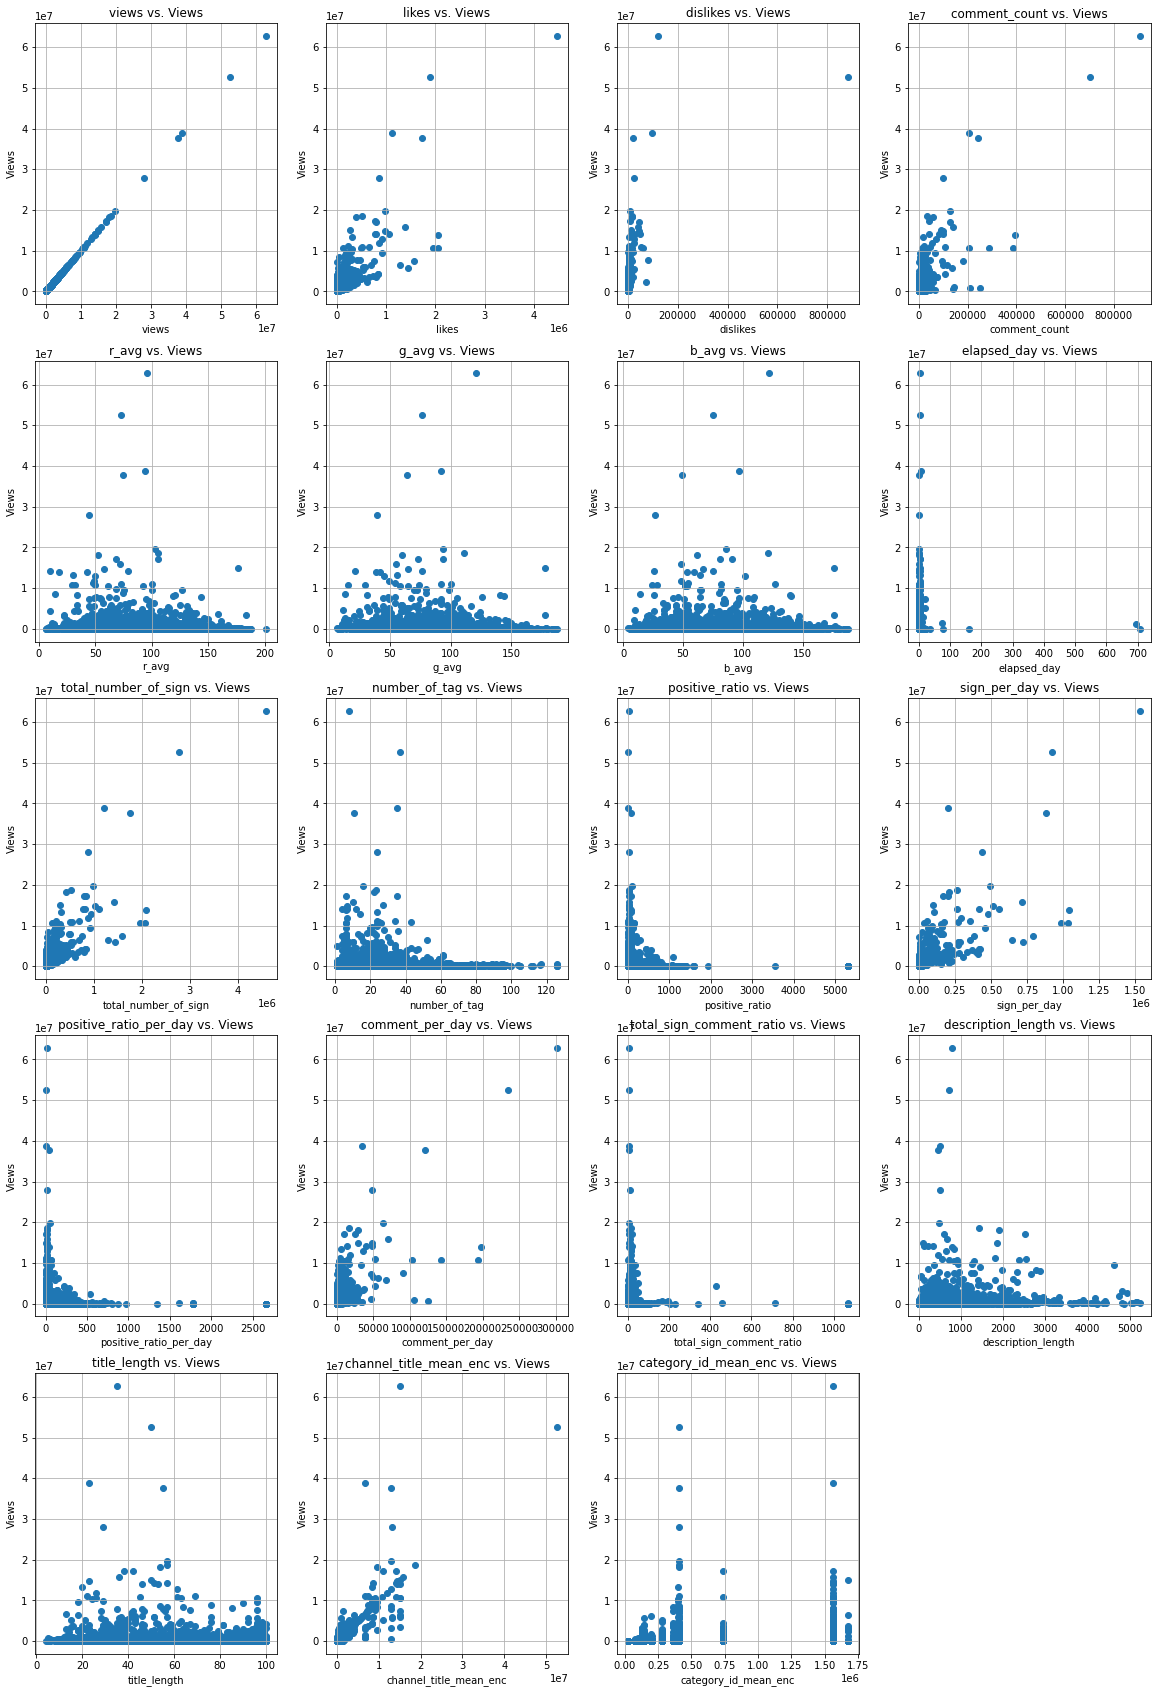

In [42]:
plt.figure(figsize=(20, 30))

for i in range(1, len(df_rgb2.describe().columns)): # 컬럼별로 describe 데이터 추출
    plt.subplot(5, 4, i)
    title = str(df_rgb2.describe().columns[i]) + ' vs. Views'
    plt.title(title)
    plt.xlabel(df_rgb2.describe().columns[i])
    plt.ylabel('Views')
    plt.grid()
    plt.scatter(df_rgb2[df_rgb2.describe().columns[i]], df_rgb2['views'])    

- likes vs. Views : 어느정도 연관성이 있을 것으로 예상된다.
- dislikes vs. Views : outlier값때문에 소수의 값이 몰린 것일 수도 있어 뚜렷한 연관성이 보이지 않는다. 약간의 연관성은 있을 수 있음
- comment_count vs. Views : 연관성은 있는듯 하지만 like에 비하면 약해 보인다.
- r_avg vs. Views : 큰 연관은 없어 보인다.
- g_avg vs. Views : 큰 연관은 없어 보인다.
- b_avg vs. Views : 큰 연관은 없어 보인다.
- elapsed_day vs. Views : outlier 영향으로 값이 한쪽에 몰린듯 하다. 추가 전처리 후 살펴볼 필요 있음.
- total_number_of_sign vs. Views : 어느정도의 연관성이 있어 보인다.
- number_of_tag vs. Views : 큰 연관성은 없는 듯 하다.
- positive_ratio vs. Views : 어느정도 연관이 있을 듯 하다. (분수함수 꼴)
- sign_per_day vs. Views : 어느정도의 연관성이 있어 보인다. 
- positive_ratio_per_day vs. Views : positive_ratio와 비슷
- comment_per_day vs. Views : 어느정도의 연관성이 있어보이지만 뚜렷하지 않음
- total_sign_comment_ratio vs. Views : 어느정도 연관이 있을 듯 하다. (분수함수 꼴)
- description_length vs. Views : 큰 연관성은 없어 보인다.
- title_length vs. Views : 큰 연관성은 없어 보인다.
- channel_title_mean_enc vs. Views : 어느정도의 상관성이 있어 보인다. 
- category_id_mean_enc vs. Views : 큰 연관성은 없어 보인다.

#### outlier 영향이 있어 보이던 feature을 다시 살펴 보기

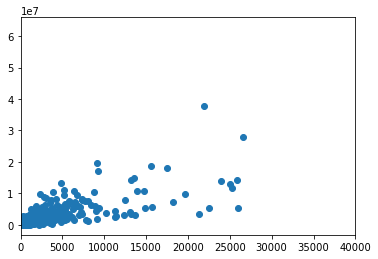

In [43]:
# dislike
plt.xlim(0, 40000)
plt.scatter(df_rgb2['dislikes'], df_rgb2['views'])

# 이상치를 제외하고 봐도 views와 의 인과관게가 크게 있어 보이지는 않는다.

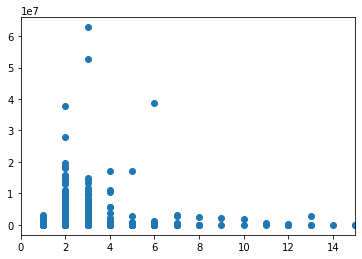

In [44]:
# elapsed_day
plt.xlim(0,15)
plt.scatter(df_rgb2['elapsed_day'], df_rgb2['views'])

# 이상치를 제외하고 봐도 views와 의 인과관게는 크게 없어 보인다.
# 현 단계에서 2~4일의 views가 높다고 해서 "인기 영상이 되려면 업로드 후 4일 내에 조회수가 많이 나와야 한다." 라는 부적절 하다.
# 아직은 그 관계를 단정 지을 수있는 관계성이 보이지 않기 때문

In [45]:
# 전체 컬럼 확인
list(df_rgb2)

['video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description',
 'r_avg',
 'g_avg',
 'b_avg',
 'publish_time2',
 'publish_date',
 'elapsed_day',
 'total_number_of_sign',
 'number_of_tag',
 'positive_ratio',
 'sign_per_day',
 'positive_ratio_per_day',
 'comment_per_day',
 'total_sign_comment_ratio',
 'description_length',
 'title_length',
 'channel_title_mean_enc',
 'category_id_mean_enc']

## 다중공선성 확인 with Hierarchical dendrogram

- Hierarchical dendrogram은 관련이 높은 feature끼리 묶어서 군집화 하는 것을 시각화 한 것.
- 단계가 내려 갈 수록 군집화된 feature들을 구분할 수 있다.

                          likes  dislikes  comment_count  r_avg  g_avg  b_avg  \
likes                      1.00       NaN            NaN    NaN    NaN    NaN   
dislikes                    NaN      1.00            NaN    NaN    NaN    NaN   
comment_count               NaN       NaN           1.00    NaN    NaN    NaN   
r_avg                       NaN       NaN            NaN   1.00    NaN    NaN   
g_avg                       NaN       NaN            NaN    NaN   1.00    NaN   
b_avg                       NaN       NaN            NaN    NaN    NaN   1.00   
elapsed_day                 NaN       NaN            NaN    NaN    NaN    NaN   
number_of_tag               NaN       NaN            NaN    NaN    NaN    NaN   
positive_ratio              NaN       NaN            NaN    NaN    NaN    NaN   
sign_per_day               0.98       NaN            NaN    NaN    NaN    NaN   
positive_ratio_per_day      NaN       NaN            NaN    NaN    NaN    NaN   
comment_per_day             

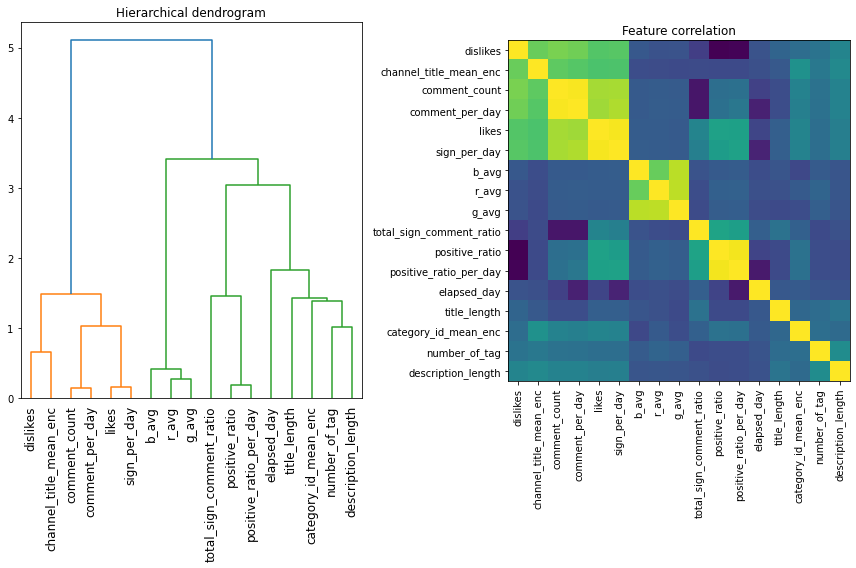

In [46]:
# 분석에 사용할 features만 지정
features = ['likes', 'dislikes', 'comment_count', 'r_avg', 'g_avg', 'b_avg', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'sign_per_day', 'positive_ratio_per_day', 'comment_per_day',
            'total_sign_comment_ratio', 'description_length', 'title_length', 'channel_title_mean_enc',
            'category_id_mean_enc']

x_input = df_rgb2[features] # x값 지정
cor_table = x_input.corr() # 상관관계 구하기

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

# dendrogram에서 나온 각 feature를 x,y로 받아서 heatmap으로 표현
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

# 상관관계가 0.9 이상인 것만 출력
print(cor_table[cor_table > 0.9])

- likes 와 sign_per_day가 0.98로 강한 상관관계를 보인다.
- positive_ratio 와 positive_ratio_per_day 등 도 높은 상관관계를 보이지만 이는 파생변수이므로 당연.
- 기존 데이터 보다 ~per_day 인 컬럼들이 높은 상관관계를 보인다.
- 다만 위에서 elapsed_day와 views 간의 scatter plot이 큰 영향력이 없었으므로 ~per_day 데이터를 지우고 다시 체크해볼 필요가 있다.

###  ~per_day 컬럼 제외 후 다시 다중공선서 확인

                        likes  dislikes  comment_count  elapsed_day  \
likes                    1.00       NaN            NaN          NaN   
dislikes                  NaN      1.00            NaN          NaN   
comment_count             NaN       NaN           1.00          NaN   
elapsed_day               NaN       NaN            NaN         1.00   
number_of_tag             NaN       NaN            NaN          NaN   
positive_ratio            NaN       NaN            NaN          NaN   
description_length        NaN       NaN            NaN          NaN   
title_length              NaN       NaN            NaN          NaN   
r_avg                     NaN       NaN            NaN          NaN   
g_avg                     NaN       NaN            NaN          NaN   
b_avg                     NaN       NaN            NaN          NaN   
channel_title_mean_enc    NaN       NaN            NaN          NaN   
category_id_mean_enc      NaN       NaN            NaN          NaN   

     

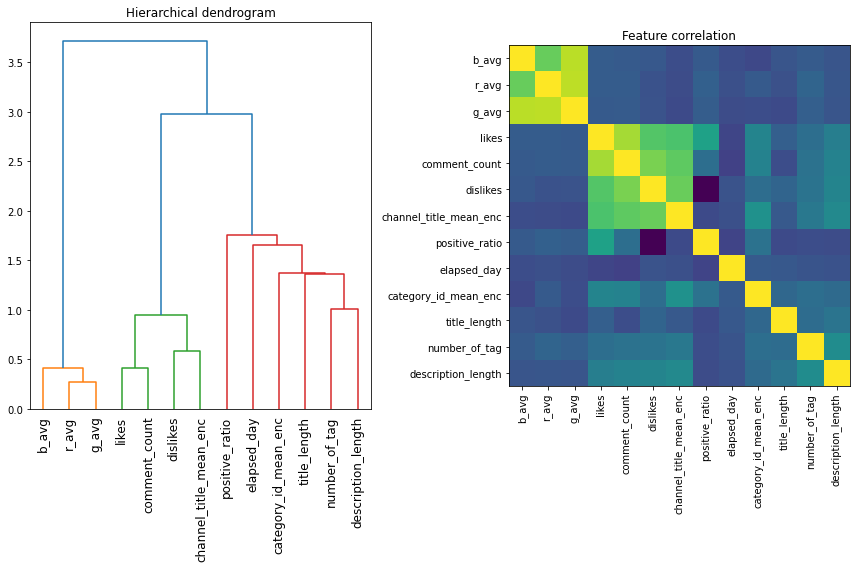

In [47]:
features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'description_length', 'title_length',
            'r_avg', 'g_avg', 'b_avg',  
            'channel_title_mean_enc', 'category_id_mean_enc']            

x_input = df_rgb2[features]
cor_table = x_input.corr()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

# 상관관계가 0.9 이상인 것만 출력
print(cor_table[cor_table > 0.9])

In [48]:
# 상관관계가 -0.9 이상인 것도 확인 (시각화 결과는 동일하므로 생략)
print(cor_table[cor_table < -0.9])

                        likes  dislikes  comment_count  elapsed_day  \
likes                     NaN       NaN            NaN          NaN   
dislikes                  NaN       NaN            NaN          NaN   
comment_count             NaN       NaN            NaN          NaN   
elapsed_day               NaN       NaN            NaN          NaN   
number_of_tag             NaN       NaN            NaN          NaN   
positive_ratio            NaN       NaN            NaN          NaN   
description_length        NaN       NaN            NaN          NaN   
title_length              NaN       NaN            NaN          NaN   
r_avg                     NaN       NaN            NaN          NaN   
g_avg                     NaN       NaN            NaN          NaN   
b_avg                     NaN       NaN            NaN          NaN   
channel_title_mean_enc    NaN       NaN            NaN          NaN   
category_id_mean_enc      NaN       NaN            NaN          NaN   

     

- 음의 상관관계가 큰 데이터들은 보이지 않는다.

### train / test split

In [49]:
# target value설정
y_output = df_rgb2['views']

# train & test split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, random_state=42)

# 4. 데이터 스케일링

In [50]:
# train_set에 대해서 MinMax 스케일링

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 5. 모델 생성 및 최적화
----

- 여러개의 모델을 만들어서 각각에 데이터를 적용

In [51]:
# 여러개의 모델 결과를 df로 만들기 위한 공통 list생성
model_name = []
train_perf = []
test_perf = []

## ElasticNet

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
Best_estimator: ElasticNet(alpha=0.002700000000000001, l1_ratio=0.9, max_iter=100000000,
           random_state=42, tol=0.1)
Best_params: {'alpha': 0.002700000000000001, 'l1_ratio': 0.9, 'tol': 0.1}
Best_score: 0.7474337468194194
Train score: 0.7533408115852761
Test  score: 0.5587733983078278


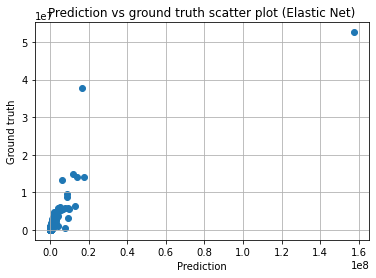

In [52]:
# 모델 선언
# 계산 부하가 적은 모델이므로 max_iter은 충분하게 부여한다.
en_model = ElasticNet(max_iter=100000000, random_state=42)


# 파라미터 최적화 범위 설정
"""
- l1_ratio : L1 & L2 규제 중 어느 것을 더 많이 사용할 것인가.
             0~1 사이 값. 1-l1_ratio = L2 ratio
- alpha : 가중치
- tol : threshold를 어느정도의 값 이하로 진행될 것인가.
"""
en_param = {'l1_ratio': np.arange(0.9, 0.995, 0.005),
            'alpha': np.arange(0.0008, 0.0028, 0.0001),
            'tol': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0]}


# GridSearch 로 hyper parameter 튜닝
"""
n_jobs = -1 : 모든 core를 사용하겠다.
verbose=3 : 진행 상황을 얼마나 자주 report할 것인지
"""
clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=3)
clf.fit(x_train_scaled, y_train) # data input
y_train_pred = clf.predict(x_train_scaled) # train_prediction
y_test_pred = clf.predict(x_test_scaled) # test_prediction

# Parameter 추출
print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)

# Train & Test의 score 추출하여 비교 by r2_score
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

# 결과를 공통 list에 저장
model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

# 결과 시각화 with scatter plot
plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [73]:
# 최적의 결과를 모델에 적용
en_model = ElasticNet(alpha=0.0027, l1_ratio=0.9, tol=0.1, max_iter=100000000, random_state=42)

## Random Forest Regressor

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best_estimator: RandomForestRegressor(max_depth=30, n_estimators=96, n_jobs=-1, random_state=42)
Best_params: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 96}
Best_score: 0.7177836574357326
Train score: 0.9357138691827017
Test  score: 0.7504533464068426


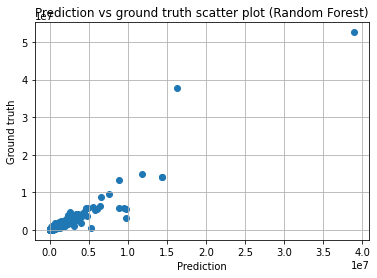

In [54]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42) # 모델 정의

# parameter 정의
"""
n_estimators : bagging 하는 tree의 개수
max_depth : tree의 깊이 (데이터의 성질, 품질, 양에 따라 다르다.)
min_samples_split : split하는 최소 sample의 개수
"""
rf_param = {'n_estimators': range(76, 136, 20),
            'max_depth': range(30, 42, 4),
            'min_samples_split': range(2, 5, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=2)

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

- ElasticNet에 비해 Test score이 많이 향상되었다.

In [72]:
# 최적의 결과를 모델에 적용
rf_model = RandomForestRegressor(n_estimators=96, max_depth=30, min_samples_split=2, n_jobs=-1, random_state=42)

### Random Forest의 feature importance 확인

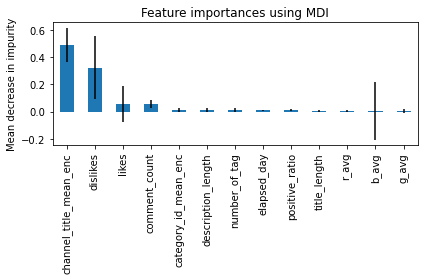

In [74]:
# 적용된 최적의 모델의 feature importance 

rf_model.fit(x_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(x_train_scaled.shape[1])]

# feature importance 추출
importances = rf_model.feature_importances_

# standard deviation 추출
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# Series로 변환 & importance가 큰 순으로 정렬
forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

# 시각화
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

- channel_title_mean_enc와 dislike가 중요한 feature인 것을 알 수 있다. (양/음의 관계 단정 지으면 안된다.)
- likes 이하의 feature들은 사실상 거의 의미없는 feature 인 것으로 보인다.

### Random Forest의 permutation importance 확인

- 특정 feature의 값을 임으로 변경했을때, 얼마나 target값에 대한 정확도가 나빠지는지(error이 얼마나 증가하나)를 확인
- feature importance와 동일 
- 단, feature importance는 tree 기반 모델에서만 추출이 가능하지만, permutation importance는 prediction이 가능한 모든 모델에서 사용 가능하다.

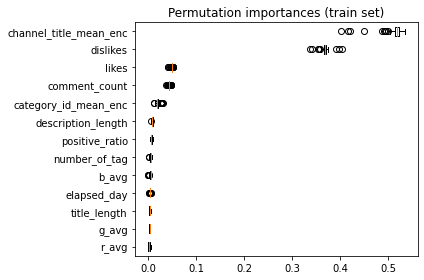

In [75]:
"""
각 feature에서 random value를 사용하기 때문에 random_state를 적용해도 일정하지 않을 수 있다.
이를 보완하기 위해 n_repeats를 충분하게 부여한다.(사양이 허락하는한 최대한 많이 주면 줄수록 좋다.)

"""
result = permutation_importance(rf_model, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42) # permutation 추출
sorted_idx = result.importances_mean.argsort() # 결과 sort

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

- feature importance 와 비슷하게 channel_title_mean_enc와 dislike가 중요한 feature임을 알 수 있다.
- 다만, permutation importance가 조금 더 정교한 결과를 보여준다.

## MLP(Multi Layer Perceptron) Regressor

- Randomized search 사용 : 차원이 넓고, 범위가 넓은 데이터는 Grid search로 촘촘하게 하기보다는 Randomized search 를 하는 것이 효율적이다.
- Grid search 로 세세하게 훑어 보면 좋지만, 하드웨어의 물리적 한계를 고려해 효율성을 따진 것
- 일반적으로 신경망 연산을 할때는 Grid 보다는 Random이 효율적이다.

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best_estimator: MLPRegressor(alpha=0.0006798962421591127, early_stopping=True,
             hidden_layer_sizes=(29, 28, 28, 29), learning_rate='adaptive',
             max_iter=2000000, random_state=42, verbose=0)
Best_params: {'alpha': 0.0006798962421591127, 'hidden_layer_sizes': (29, 28, 28, 29)}
Best_score: 0.697647847386584
Train score: 0.7436959102690992
Test  score: 0.5915119564549477


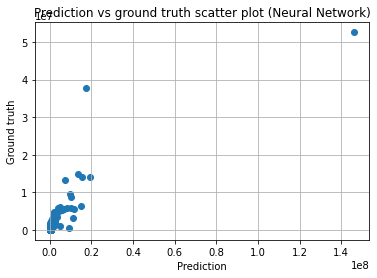

In [58]:
"""
learning_rate : 오차율 변화를 adaptive하게 변화 (default 는 constant)
                초반에는 learning_rate를 크게 가다가, 후반부에 작게 가는 방식
early_stopping : iteration이 진행될때 loss의 변화가 적다면(모델 개선이 없다면) 중지 (before max_iteration)
"""

# 모델 선언
mlp_model = MLPRegressor(learning_rate='adaptive', max_iter=2000000, verbose=0,
                         early_stopping=True, random_state=42)

# 파라미터 설정
"""
hidden_layer_sizes : 각 layer마다 tuple 형태로 입력이 가능하다.
                     itertools.product를 활용해서 24 ~32 사이의 숫자로 4번을 반복해서 값을 생성 -> tuple로 생성
alpha : 규제를 어느정도 할 것인가. log scale이 의미가 있다.
        loguniform을 활용해서 값을 선정
"""

mlp_param = {'hidden_layer_sizes': [x for x in itertools.product((range(24, 32)), repeat=4)],
             'alpha': loguniform(1e-4, 1e-3)}

# Randomized search 사용
# 성능 측정용으로 10회만 (n_iter=10)
rand_clf = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_param, n_iter=10, n_jobs=-1,
                              cv=3, verbose=2, random_state=42)

# data input
rand_clf.fit(x_train_scaled, y_train)

# prediction
y_train_pred = rand_clf.predict(x_train_scaled)
y_test_pred = rand_clf.predict(x_test_scaled)

# 결과 확인
print('Best_estimator:', rand_clf.best_estimator_)
print('Best_params:', rand_clf.best_params_)
print('Best_score:', rand_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

# 결과 시각화 with scatter plot
model_name.append('Neural Network')
train_perf.append(train_score)
test_perf.append(test_score)
plt.title('Prediction vs ground truth scatter plot (Neural Network)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [71]:
# 최적의 결과를 모델에 적용
mlp_model = MLPRegressor(hidden_layer_sizes=(24, 27, 28, 31), alpha=0.0006798962421591127, learning_rate='adaptive',
                         max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

## XGB Regressor

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=120, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.01, reg_lambda=0.316, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best_params: {'max_depth': 3, 'n_estimators': 120, 'reg_alpha': 0.01, 'reg_lambda': 0.316}
Best_score: 0.7728576061581535
Train score: 0.9974929391469998
Test  score: 0.7697238403965264


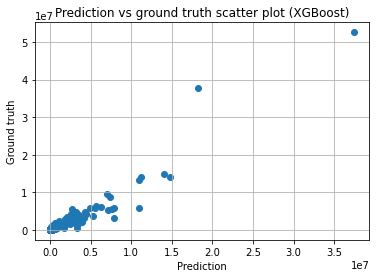

In [60]:
# 모델 선언
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)


# parameter 설정
"""
규제 파라미터 2개 
reg_alpha
reg_lambda
"""
xgb_param = {'n_estimators': range(80, 140, 20),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1],
             'reg_lambda': [0.1, 0.316, 1]}


# hyper parameter tunning
xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=3)

# 모델에 적용
xgb_clf.fit(x_train_scaled, y_train)
y_train_pred = xgb_clf.predict(x_train_scaled)
y_test_pred = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [70]:
# 최적의 결과를 모델에 적용
xgb_model = XGBRegressor(max_depth=3, n_estimators=120, reg_alpha=0.01, reg_lambda=0.316, n_jobs=-1, random_state=42)

## SVM Regressor

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best_estimator: SVR(C=100000000.0, gamma=0.1)
Best_params: {'C': 100000000.0, 'gamma': 0.1}
Best_score: 0.7914325900067363
Train score: 0.7499666867872967
Test  score: -0.6093163425621284


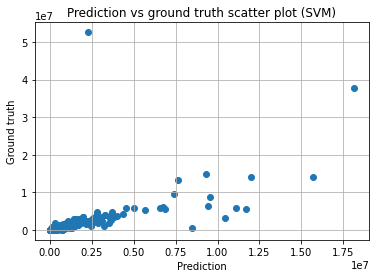

In [62]:
# 모델선언
svr_model = SVR()


# parameter 
"""
C : 얼마나 많은 데이터 샘플이 다른 클래스로 분류되는 것을 허용할 것인가 (높을수록 기준이 tight)
gamma : 하나의 데이터 샘플이 영향력을 행사하는 거리 (클수록 작은 표준편차를 갖는다)
"""
svr_param = {'C': [3.16e7, 1e8],
             'gamma': [0.1, 0.316]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3, cv=3)

svr_clf.fit(x_train_scaled, y_train)
y_train_pred = svr_clf.predict(x_train_scaled)
y_test_pred = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

- SVM의 Test값이 음수값으로 나온다 = 데이터 해석이 불가능 하다 = 현재 데이터에 부적합한 모델이다 = 앙상블을 해도 쓰지 않아야 한다.

In [69]:
# 최적의 결과를 모델에 적용
svr_model = SVR(C=100000000, gamma=0.1)

## KNN Regressor

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best_estimator: KNeighborsRegressor(leaf_size=1, n_jobs=-1, n_neighbors=4, weights='distance')
Best_params: {'leaf_size': 1, 'n_neighbors': 4, 'weights': 'distance'}
Best_score: 0.6356002675099257
Train score: 1.0
Test  score: 0.40071256810039


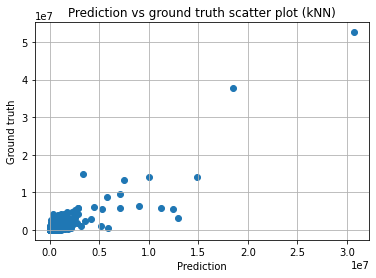

In [64]:
# 모델 선언
knn_model = KNeighborsRegressor(n_jobs=-1)

# parameter
knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(x_train_scaled, y_train)
y_train_pred = knn_clf.predict(x_train_scaled)
y_test_pred = knn_clf.predict(x_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)

train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('KNN')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [68]:
# 최적의 결과를 모델에 적용
knn_model = KNeighborsRegressor(leaf_size=1, n_neighbors=4 , n_jobs=-1, weights='distance')

## 각 모델별 성능 시각화

In [66]:
# 해석 불가 모델인  SVM은 제거
model_name.remove('SVM')
del train_perf[4] # 5번째 model
del test_perf[4]
model_name

['Elastic Net', 'Random Forest', 'Neural Network', 'XGBoost', 'KNN']

In [76]:
dic = {'model_name':model_name,
      'train_perf':train_perf,
      'test_perf':test_perf}

MPC = pd.DataFrame.from_dict(dic, orient='index')
MPC

,0,1,2,3,4
model_name,Elastic Net,Random Forest,Neural Network,XGBoost,KNN
train_perf,0.75,0.94,0.74,1.00,1.00
test_perf,0.56,0.75,0.59,0.77,0.40


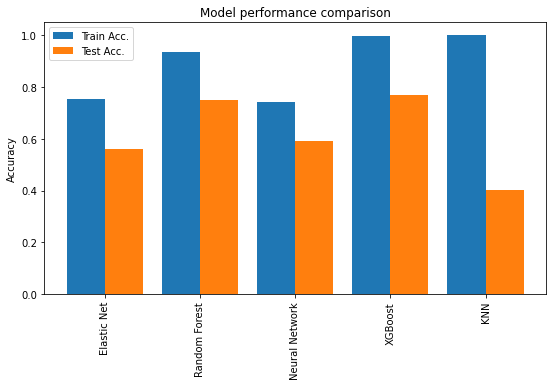

In [77]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.')
plt.legend();

# 모델 앙상블 by Voting

1 Ensemble train score: 0.9974929391469998
1 Ensemble test  score: 0.7697238403965264 

2 Ensemble train score: 0.9844179059971965
2 Ensemble test  score: 0.7646699599356265 

3 Ensemble train score: 0.9459696939727981
3 Ensemble test  score: 0.8579955934106758 

4 Ensemble train score: 0.9132062544470099
4 Ensemble test  score: 0.7791599850635491 

5 Ensemble train score: 0.9469212124110686
5 Ensemble test  score: 0.8209624647024927 



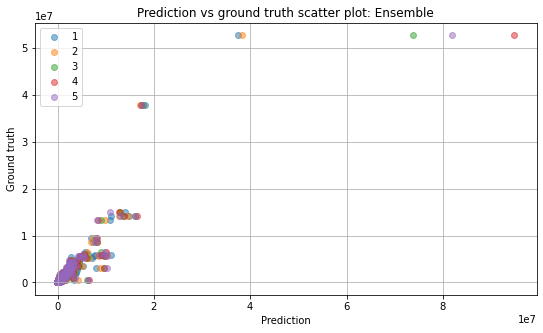

In [78]:
# Test score가 높은 순으로 입력 
ensemble_list = [ ('xgb', xgb_model),
                 ('rf', rf_model),
                  ('mlp', mlp_model),
                  ('en', en_model),
                  ('knn', knn_model) ]

# score 저장용 list 생성
train_perf_ens = []
test_perf_ens = []

# voting estimator를 저장할 list 생성
voting_est = []

# 각각의 모델을 앙상블
for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model) # 모델 이름 저장

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1) # voting classifier 지정
    voting_clf.fit(x_train_scaled, y_train) # 데이터 입력
    y_train_pred = voting_clf.predict(x_train_scaled) 
    y_test_pred = voting_clf.predict(x_test_scaled)
    
    # 결과 출력
    train_score =  r2_score(y_train_pred, y_train)
    print(idx + 1, 'Ensemble train score:',train_score)
    test_score = r2_score(y_test_pred, y_test)
    print(idx + 1, 'Ensemble test  score:', test_score, '\n')
    
    #model_name.append(target_model)
    train_perf_ens.append(train_score)
    test_perf_ens.append(test_score)
    
    # 결과 시각화
    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5)
    title = 'Prediction vs ground truth scatter plot: Ensemble'     
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

- Test score가 가장 높은 3번째 Ensemble가 가장 좋은 조합으로 판단된다.

## Ensemble결과 시각화

In [79]:
dic2 = {
        'train_perf_ens':train_perf_ens,
        'test_perf_ens':test_perf_ens
        }

MPC2 = pd.DataFrame.from_dict(dic2, orient='index')
MPC2

,0,1,2,3,4
train_perf_ens,1.00,0.98,0.95,0.91,0.95
test_perf_ens,0.77,0.76,0.86,0.78,0.82


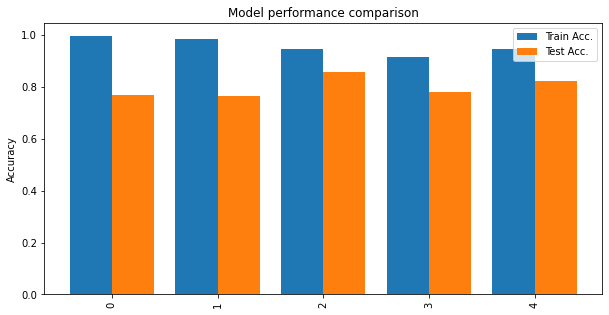

In [80]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

x = np.arange(5)
plt.xticks(x)
plt.bar(x - 0.2, train_perf_ens, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf_ens, width=0.4, label='Test Acc.')
plt.legend();

In [82]:
# 가장 성능이 좋은 3번째 Ensemble로 모델 선언
voting_clf = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('mlp', mlp_model)],
                             n_jobs=-1)
voting_clf.fit(x_train_scaled, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=3,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=No...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                        

# 최적 Voting 모델의 특성(피쳐) 중요도 분석

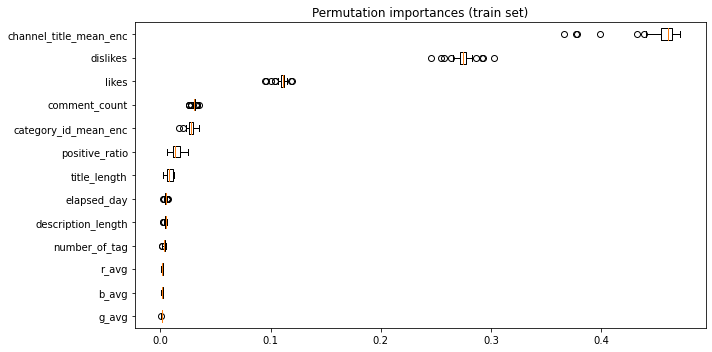

In [83]:
result = permutation_importance(voting_clf, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

# 최종 분석을 위한 데이터 세트 설정 및 스케일링

- 최종 분석에 사용할 모델을 위해 모든 데이터를 최종 모델에 입력

In [84]:
# numpy concat으로 데이터 병합
x_total = np.concatenate((x_train, x_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)

# 데이터 스케일링(MinMax)
x_total_scaled = scaler.transform(x_total)

# 모델에 데이터 입력
voting_clf.fit(x_total_scaled, y_total)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=3,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=No...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                        

# 유전 알고리즘 - 최적 피쳐 탐색: 일반 YouTuber

- Music 카테고리에서 인기 유투버가 되려면 어떤 요소들을 고려해야 할까? with Genetic Algorithm

In [85]:
# target value인 views의 통계량 재확인
# percentiles 옵션으로 원하는 percentiles을 확인 가능

df_rgb2['views'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count       6577.00
mean      370188.47
std      1660059.60
min         2623.00
50%        99510.00
75%       233890.00
90%       568158.80
95%      1155288.00
99%      5177477.80
max     62796390.00
Name: views, dtype: float64

- outlier값이 Top view (99~max) 부분에 몰려있고, 대부분의 views수는 중앙에 몰려있다.
- 일반 유투버의 대상은 views기준 50%인 데이터(9.9만 - 약 10만 views)를 기준으로 분석할 예정

## GA에서 feature를 인식시키기 위해 index로 지정하는 함수 생성

In [86]:
# 실제 모델에 사용된 features
# features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag', 'positive_ratio',
#             'description_length', 'title_length', 'r_avg', 'g_avg', 'b_avg', 'channel_title_mean_enc',
#             'category_id_mean_enc']

# feautre의 list idx_num을 활용해서 함수 생성
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'


# 유전 알고리즘에 사용할 input을 변환하는 함수 생성
"""
feature의 값을 입력하기 위해 idx를 활용해 int로 변환 -> 특정 GA에게 feature를 찾아 달라고 요청할때 활용
"""
def input_conversion(x_input):
    conversion = [int(x_input[0]),
                  int(x_input[1]),
                  int(x_input[2]),
                  int(x_input[3]),
                  int(x_input[4]),
                  x_input[0] / x_input[1], # positive_ratio는 likes / dislikes 이므로 idx 활용
                  int(x_input[5]),
                  int(x_input[6]),
                  int(x_input[7]),
                  int(x_input[8]),
                  int(x_input[9]),
                  mean_encode_channel.iloc[int(x_input[10])], # mean_encoding된 값을 찾고자하면 GA는 알수 없음 -> idx를 입력
                  mean_encode_category.iloc[int(x_input[11])]]

    return conversion

## GA에 input되는 variables의 범위 지정

In [87]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

# GA가 어떤 범위 안에서 값을 찾을 것인지 탐색할 범위를 지정하기 위한 것
"""
mean_encode~ feaure는 GA에 input할 값은 각 feature의 series의 index 값이다.
따라서 범위를 아래와 같이 범위를 지정
극단점의 edge node에 있는 값을 찾고 싶은 것이 아니라면 min 과 max는 실제 값의 범위보다 살짝 좁게 설정해주는게 좋다
-> min+1을 한 이유 
boundary 쪽으로 갈수록 model의 설명력은 떨어질 수 밖에 없다(=데이터수가 작아지기 때문)
"""
varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()], # dislike가 0인 경우 고려해 min+1 
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()], # comment_count 0인 경우 고려해 min+1 
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]], # 모든 카테고리에대한 조건 탐색할 경우 # 제거
                     [2, 2]]) # category_id 컬럼에서 Music 카테고리의 index값이 3번째(=2)

## GA에 직접 사용할 object function함수 생성

In [88]:
def object_function_median(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input) # x data를 model에 사용할 형태로 conversion 
    input_converted = np.array(input_converted).reshape(1, -1) # GA에 쓰기 위한 np.array 형태로 변경

    input_scaled = scaler.transform(input_converted) # input된 데이터 scailing (MinMax)
    prediction = target_model.predict(input_scaled) # 앙상블 모델로 prediction

    target = df_rgb2['views'].median() # 일반 유투버 기준이므로 median -> view수 10만(view의 median)정도가 되기 위한 condition은 무엇인가?
    print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))
    
    """
    GA로 return해서 보내줄 값을 찾아야 한다.
    loss function처럼 prediction - target을 구해준다.
    이 차이를 줄이려고 GA가 작동할 것이기 때문
    prediction - target이 음수값이 될 경우를 감안하여 abs()처리
    GA의 문제점은 target값 근처로 갈수록 차이가 줄어들어서 정확도를 높일 incentive가 감소
    즉, 작은 값을 맞추도록 유도하기 위해 log값을 취해 준 것
    """
    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [89]:
"""
geneticalgorithm의 parameter
max_num_iteration : 몇번 진화연산을 할 것인가
population_size : 초기 generation된 population을 몇%로 할 것인가 (클수록 좋지만, 연산능력 감안해야 함)
mutation_probability : 다음 세대에 생성되는 변수중에 몇 %를 변이데이터로 채울 것인가
elit_ratio : 이전 세대의 해 중에서 몇%의 가장 뛰어난 해를 가져올 것인가
crossover_probability : 가족 세대간의 cross over를 몇 %할 것인가
parents_portion : 각 세대가 진행될 수록 자식세대가 부모세대의 해석결과를 몇%를 가져올 것인가
max_iteration_without_improv : 각 iteration 중에 # 번의 발전이 없으면 iteration을 정지시킬 것인지

해석 
전체 100개의 데이터가 있다면, 이중 30%는 부모세대의 값을 가져오고, 50%를 서로 교차연산하여 새로운 해를 생성하겠다.
"""
# GA에 사용할 parameter 
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

## GA 모델에 적용

Predicted views: 29893209 Difference from target: 29793699
Predicted views: 32226346 Difference from target: 32126836
Predicted views: 16292616 Difference from target: 16193106
Predicted views: 26775542 Difference from target: 26676032
Predicted views: 31344806 Difference from target: 31245296
Predicted views: 28057494 Difference from target: 27957984
Predicted views: 15604651 Difference from target: 15505141
Predicted views: 13456093 Difference from target: 13356583
Predicted views: 10242969 Difference from target: 10143459
Predicted views: 29112752 Difference from target: 29013242
Predicted views: 29311559 Difference from target: 29212049
Predicted views: 14260603 Difference from target: 14161093
Predicted views: 12302449 Difference from target: 12202939
Predicted views: 28649893 Difference from target: 28550383
Predicted views: 26110930 Difference from target: 26011420
Predicted views: 20314887 Difference from target: 20215377
Predicted views: 24809943 Difference from target: 247104

Predicted views: 28568733 Difference from target: 28469223
Predicted views: 26840617 Difference from target: 26741107
Predicted views: 15899194 Difference from target: 15799684
Predicted views: 19794073 Difference from target: 19694563
Predicted views: 23183412 Difference from target: 23083902
Predicted views: 23046997 Difference from target: 22947487
Predicted views: 25166299 Difference from target: 25066789
Predicted views: 20372189 Difference from target: 20272679
Predicted views: 28208990 Difference from target: 28109480
Predicted views: 25552616 Difference from target: 25453106
Predicted views: 24519035 Difference from target: 24419525
Predicted views: 16465763 Difference from target: 16366253
Predicted views: 19972106 Difference from target: 19872596
Predicted views: 20690285 Difference from target: 20590775
Predicted views: 28056666 Difference from target: 27957156
Predicted views: 24160453 Difference from target: 24060943
Predicted views: 15426785 Difference from target: 153272

Predicted views: 18058524 Difference from target: 17959014
Predicted views: 5826381 Difference from target: 5726871
Predicted views: 14206024 Difference from target: 14106514
Predicted views: 28803127 Difference from target: 28703617
Predicted views: 22126680 Difference from target: 22027170
Predicted views: 26333038 Difference from target: 26233528
Predicted views: 18652020 Difference from target: 18552510
Predicted views: 16736743 Difference from target: 16637233
Predicted views: 22890169 Difference from target: 22790659
Predicted views: 15567108 Difference from target: 15467598
Predicted views: 17879524 Difference from target: 17780014
Predicted views: 20932901 Difference from target: 20833391
Predicted views: 9116545 Difference from target: 9017035
Predicted views: 10840349 Difference from target: 10740839
Predicted views: 9141929 Difference from target: 9042419
Predicted views: 9758357 Difference from target: 9658847
Predicted views: 20924293 Difference from target: 20824783
Predi

Predicted views: 19891262 Difference from target: 19791752
Predicted views: 20044234 Difference from target: 19944724
Predicted views: 16607749 Difference from target: 16508239
Predicted views: 5481394 Difference from target: 5381884
Predicted views: 6325513 Difference from target: 6226003
Predicted views: 9006907 Difference from target: 8907397
Predicted views: 20753628 Difference from target: 20654118
Predicted views: 8273171 Difference from target: 8173661
Predicted views: 8284395 Difference from target: 8184885
Predicted views: 3826531 Difference from target: 3727021
Predicted views: 5404250 Difference from target: 5304740
Predicted views: 20200003 Difference from target: 20100493
Predicted views: 8513809 Difference from target: 8414299
Predicted views: 5880676 Difference from target: 5781166
Predicted views: 5400801 Difference from target: 5301291
Predicted views: 19823910 Difference from target: 19724400
Predicted views: 19781751 Difference from target: 19682241
Predicted views: 

Predicted views: 6417531 Difference from target: 6318021
Predicted views: 8192036 Difference from target: 8092526
Predicted views: 11412236 Difference from target: 11312726
Predicted views: 5308909 Difference from target: 5209399
Predicted views: 19888119 Difference from target: 19788609
Predicted views: 5412450 Difference from target: 5312940
Predicted views: 5416697 Difference from target: 5317187
Predicted views: 18219540 Difference from target: 18120030
Predicted views: 6164725 Difference from target: 6065215
Predicted views: 20976785 Difference from target: 20877275
Predicted views: 5109924 Difference from target: 5010414
Predicted views: 8157661 Difference from target: 8058151
Predicted views: 6732062 Difference from target: 6632552
Predicted views: 6066905 Difference from target: 5967395
Predicted views: 3270258 Difference from target: 3170748
Predicted views: 19335752 Difference from target: 19236242
Predicted views: 19900827 Difference from target: 19801317
Predicted views: 13

Predicted views: 5396649 Difference from target: 5297139
Predicted views: 4048636 Difference from target: 3949126
Predicted views: 5353846 Difference from target: 5254336
Predicted views: 21579044 Difference from target: 21479534
Predicted views: 7647085 Difference from target: 7547575
Predicted views: 3245110 Difference from target: 3145600
Predicted views: 4675401 Difference from target: 4575891
Predicted views: 5289655 Difference from target: 5190145
Predicted views: 2750505 Difference from target: 2650995
Predicted views: 1812246 Difference from target: 1712736
Predicted views: 5671674 Difference from target: 5572164
Predicted views: 2900772 Difference from target: 2801262
Predicted views: 2901502 Difference from target: 2801992
Predicted views: 7395222 Difference from target: 7295712
Predicted views: 7849188 Difference from target: 7749678
Predicted views: 9014905 Difference from target: 8915395
Predicted views: 3000072 Difference from target: 2900562
Predicted views: 1955223 Diff

Predicted views: 3634319 Difference from target: 3534809
Predicted views: 2593293 Difference from target: 2493783
Predicted views: 4350914 Difference from target: 4251404
Predicted views: 4350914 Difference from target: 4251404
Predicted views: 2773798 Difference from target: 2674288
Predicted views: 3279983 Difference from target: 3180473
Predicted views: 4853097 Difference from target: 4753587
Predicted views: 2864250 Difference from target: 2764740
Predicted views: 4564330 Difference from target: 4464820
Predicted views: 3756483 Difference from target: 3656973
Predicted views: 4358539 Difference from target: 4259029
Predicted views: 2688663 Difference from target: 2589153
Predicted views: 2688407 Difference from target: 2588897
Predicted views: 2162264 Difference from target: 2062754
Predicted views: 3413312 Difference from target: 3313802
Predicted views: 3218238 Difference from target: 3118728
Predicted views: 7746413 Difference from target: 7646903
Predicted views: 2200217 Differ

Predicted views: 4418027 Difference from target: 4318517
Predicted views: 2458601 Difference from target: 2359091
Predicted views: 2637420 Difference from target: 2537910
Predicted views: 8261585 Difference from target: 8162075
Predicted views: 3033332 Difference from target: 2933822
Predicted views: 8238482 Difference from target: 8138972
Predicted views: 3155647 Difference from target: 3056137
Predicted views: 2549231 Difference from target: 2449721
Predicted views: 2111220 Difference from target: 2011710
Predicted views: 2127466 Difference from target: 2027956
Predicted views: 3005429 Difference from target: 2905919
Predicted views: 4219646 Difference from target: 4120136
Predicted views: 1955786 Difference from target: 1856276
Predicted views: 3414641 Difference from target: 3315131
Predicted views: 10863573 Difference from target: 10764063
Predicted views: 7917416 Difference from target: 7817906
Predicted views: 5396381 Difference from target: 5296871
Predicted views: 2197642 Diff

Predicted views: 2660987 Difference from target: 2561477
Predicted views: 2147814 Difference from target: 2048304
Predicted views: 5550367 Difference from target: 5450857
Predicted views: 1590343 Difference from target: 1490833
Predicted views: 2587655 Difference from target: 2488145
Predicted views: 7826127 Difference from target: 7726617
Predicted views: 23487472 Difference from target: 23387962
Predicted views: 3375183 Difference from target: 3275673
Predicted views: 8725370 Difference from target: 8625860
Predicted views: 2099472 Difference from target: 1999962
Predicted views: 1085922 Difference from target: 986412
Predicted views: 15752107 Difference from target: 15652597
Predicted views: 2662704 Difference from target: 2563194
Predicted views: 7155604 Difference from target: 7056094
Predicted views: 8053937 Difference from target: 7954427
Predicted views: 9882971 Difference from target: 9783461
Predicted views: 3682105 Difference from target: 3582595
Predicted views: 8097835 Dif

Predicted views: 6051281 Difference from target: 5951771
Predicted views: 2988516 Difference from target: 2889006
Predicted views: 2846016 Difference from target: 2746506
Predicted views: 2777156 Difference from target: 2677646
Predicted views: 6099223 Difference from target: 5999713
Predicted views: 2616080 Difference from target: 2516570
Predicted views: 5801663 Difference from target: 5702153
Predicted views: 24101316 Difference from target: 24001806
Predicted views: 10330273 Difference from target: 10230763
Predicted views: 2566213 Difference from target: 2466703
Predicted views: 6060505 Difference from target: 5960995
Predicted views: 5571227 Difference from target: 5471717
Predicted views: 7640211 Difference from target: 7540701
Predicted views: 8840041 Difference from target: 8740531
Predicted views: 4667584 Difference from target: 4568074
Predicted views: 4539251 Difference from target: 4439741
Predicted views: 2548996 Difference from target: 2449486
Predicted views: 14709429 D

Predicted views: 11217227 Difference from target: 11117717
Predicted views: 9870594 Difference from target: 9771084
Predicted views: 4017877 Difference from target: 3918367
Predicted views: 4935745 Difference from target: 4836235
Predicted views: 9602413 Difference from target: 9502903
Predicted views: 7749856 Difference from target: 7650346
Predicted views: 6315902 Difference from target: 6216392
Predicted views: 5874231 Difference from target: 5774721
Predicted views: 4564413 Difference from target: 4464903
Predicted views: 8840129 Difference from target: 8740619
Predicted views: 24440321 Difference from target: 24340811
Predicted views: 27014515 Difference from target: 26915005
Predicted views: 9027156 Difference from target: 8927646
Predicted views: 8907679 Difference from target: 8808169
Predicted views: 5721665 Difference from target: 5622155
Predicted views: 11019909 Difference from target: 10920399
Predicted views: 16139908 Difference from target: 16040398
Predicted views: 1378

Predicted views: 15970298 Difference from target: 15870788
Predicted views: 3017008 Difference from target: 2917498
Predicted views: 7984905 Difference from target: 7885395
Predicted views: 2851480 Difference from target: 2751970
Predicted views: 4029355 Difference from target: 3929845
Predicted views: 2557929 Difference from target: 2458419
Predicted views: 12566187 Difference from target: 12466677
Predicted views: 2698885 Difference from target: 2599375
Predicted views: 2850349 Difference from target: 2750839
Predicted views: 2925002 Difference from target: 2825492
Predicted views: 13898880 Difference from target: 13799370
Predicted views: 5097253 Difference from target: 4997743
Predicted views: 3297660 Difference from target: 3198150
Predicted views: 2517569 Difference from target: 2418059
Predicted views: 1946933 Difference from target: 1847423
Predicted views: 4914704 Difference from target: 4815194
Predicted views: 7245801 Difference from target: 7146291
Predicted views: 18675555

Predicted views: 14099517 Difference from target: 14000007
Predicted views: 1773688 Difference from target: 1674178
Predicted views: 1775674 Difference from target: 1676164
Predicted views: 3524881 Difference from target: 3425371
Predicted views: 2916950 Difference from target: 2817440
Predicted views: 1615700 Difference from target: 1516190
Predicted views: 20668942 Difference from target: 20569432
Predicted views: 4839911 Difference from target: 4740401
Predicted views: 17459129 Difference from target: 17359619
Predicted views: 2424263 Difference from target: 2324753
Predicted views: 16067102 Difference from target: 15967592
Predicted views: 1983646 Difference from target: 1884136
Predicted views: 1515459 Difference from target: 1415949
Predicted views: 2619166 Difference from target: 2519656
Predicted views: 26550680 Difference from target: 26451170
Predicted views: 18011455 Difference from target: 17911945
Predicted views: 1520582 Difference from target: 1421072
Predicted views: 26

Predicted views: 1038544 Difference from target: 939034
Predicted views: 17369957 Difference from target: 17270447
Predicted views: 3455748 Difference from target: 3356238
Predicted views: 20261915 Difference from target: 20162405
Predicted views: 3613121 Difference from target: 3513611
Predicted views: 3074983 Difference from target: 2975473
Predicted views: 3050982 Difference from target: 2951472
Predicted views: 3610983 Difference from target: 3511473
Predicted views: 2247051 Difference from target: 2147541
Predicted views: 4347779 Difference from target: 4248269
Predicted views: 11995193 Difference from target: 11895683
Predicted views: 3553989 Difference from target: 3454479
Predicted views: 16454237 Difference from target: 16354727
Predicted views: 5943635 Difference from target: 5844125
Predicted views: 13809930 Difference from target: 13710420
||||______________________________________________ 8.7% GA is running...Predicted views: 3573125 Difference from target: 3473615
Predict

Predicted views: 2416727 Difference from target: 2317217
Predicted views: 1056851 Difference from target: 957341
Predicted views: 1284175 Difference from target: 1184665
Predicted views: 10551702 Difference from target: 10452192
Predicted views: 1266190 Difference from target: 1166680
Predicted views: 1287553 Difference from target: 1188043
Predicted views: 13312805 Difference from target: 13213295
Predicted views: 2802307 Difference from target: 2702797
Predicted views: 1780926 Difference from target: 1681416
Predicted views: 948336 Difference from target: 848826
Predicted views: 5036639 Difference from target: 4937129
Predicted views: 955353 Difference from target: 855843
Predicted views: 18262514 Difference from target: 18163004
Predicted views: 2950987 Difference from target: 2851477
|||||_____________________________________________ 9.3% GA is running...Predicted views: 2224043 Difference from target: 2124533
Predicted views: 5118815 Difference from target: 5019305
Predicted views

Predicted views: 2213646 Difference from target: 2114136
Predicted views: 2532885 Difference from target: 2433375
Predicted views: 2086770 Difference from target: 1987260
Predicted views: 2430092 Difference from target: 2330582
Predicted views: 5046376 Difference from target: 4946866
Predicted views: 1287806 Difference from target: 1188296
Predicted views: 1553963 Difference from target: 1454453
Predicted views: 1045494 Difference from target: 945984
Predicted views: 15832060 Difference from target: 15732550
Predicted views: 8975466 Difference from target: 8875956
Predicted views: 1820921 Difference from target: 1721411
|||||_____________________________________________ 10.0% GA is running...Predicted views: 2169341 Difference from target: 2069831
Predicted views: 1950574 Difference from target: 1851064
Predicted views: 2686330 Difference from target: 2586820
Predicted views: 953622 Difference from target: 854112
Predicted views: 890562 Difference from target: 791052
Predicted views: 1

Predicted views: 15371314 Difference from target: 15271804
Predicted views: 15458424 Difference from target: 15358914
Predicted views: 1519591 Difference from target: 1420081
Predicted views: 1721664 Difference from target: 1622154
Predicted views: 7336937 Difference from target: 7237427
Predicted views: 1092952 Difference from target: 993442
Predicted views: 1082823 Difference from target: 983313
|||||_____________________________________________ 10.7% GA is running...Predicted views: 1457194 Difference from target: 1357684
Predicted views: 793788 Difference from target: 694278
Predicted views: 1107630 Difference from target: 1008120
Predicted views: 1140407 Difference from target: 1040897
Predicted views: 1356274 Difference from target: 1256764
Predicted views: 13748686 Difference from target: 13649176
Predicted views: 1287806 Difference from target: 1188296
Predicted views: 899335 Difference from target: 799825
Predicted views: 1290354 Difference from target: 1190844
Predicted views

Predicted views: 12379930 Difference from target: 12280420
Predicted views: 999812 Difference from target: 900302
Predicted views: 1022385 Difference from target: 922875
||||||____________________________________________ 11.3% GA is running...Predicted views: 10531045 Difference from target: 10431535
Predicted views: 4590657 Difference from target: 4491147
Predicted views: 1536462 Difference from target: 1436952
Predicted views: 1676268 Difference from target: 1576758
Predicted views: 813646 Difference from target: 714136
Predicted views: 4819207 Difference from target: 4719697
Predicted views: 1263328 Difference from target: 1163818
Predicted views: 1482658 Difference from target: 1383148
Predicted views: 4665148 Difference from target: 4565638
Predicted views: 7655911 Difference from target: 7556401
Predicted views: 4787966 Difference from target: 4688456
Predicted views: 856257 Difference from target: 756747
Predicted views: 4705891 Difference from target: 4606381
Predicted views: 2

||||||____________________________________________ 12.7% GA is running...Predicted views: 1502701 Difference from target: 1403191
Predicted views: 4077470 Difference from target: 3977960
Predicted views: 1568672 Difference from target: 1469162
Predicted views: 929556 Difference from target: 830046
Predicted views: 1345134 Difference from target: 1245624
Predicted views: 1495222 Difference from target: 1395712
Predicted views: 26665300 Difference from target: 26565790
Predicted views: 14282701 Difference from target: 14183191
Predicted views: 2196411 Difference from target: 2096901
Predicted views: 23447842 Difference from target: 23348332
Predicted views: 1138122 Difference from target: 1038612
Predicted views: 1219948 Difference from target: 1120438
Predicted views: 1110621 Difference from target: 1011111
Predicted views: 915792 Difference from target: 816282
Predicted views: 1036742 Difference from target: 937232
Predicted views: 755434 Difference from target: 655924
Predicted views:

Predicted views: 1159057 Difference from target: 1059547
Predicted views: 22026106 Difference from target: 21926596
Predicted views: 5074328 Difference from target: 4974818
Predicted views: 4689097 Difference from target: 4589587
Predicted views: 821567 Difference from target: 722057
Predicted views: 821567 Difference from target: 722057
Predicted views: 912090 Difference from target: 812580
Predicted views: 1418745 Difference from target: 1319235
Predicted views: 2602227 Difference from target: 2502717
Predicted views: 962171 Difference from target: 862661
Predicted views: 777853 Difference from target: 678343
Predicted views: 9364583 Difference from target: 9265073
Predicted views: 10694555 Difference from target: 10595045
Predicted views: 826469 Difference from target: 726959
Predicted views: 3666915 Difference from target: 3567405
Predicted views: 2278342 Difference from target: 2178832
Predicted views: 1379528 Difference from target: 1280018
Predicted views: 4806534 Difference fro

Predicted views: 10557380 Difference from target: 10457870
Predicted views: 2951522 Difference from target: 2852012
Predicted views: 12056966 Difference from target: 11957456
Predicted views: 5086354 Difference from target: 4986844
Predicted views: 1624184 Difference from target: 1524674
Predicted views: 4446960 Difference from target: 4347450
Predicted views: 807585 Difference from target: 708075
Predicted views: 2001762 Difference from target: 1902252
Predicted views: 2279056 Difference from target: 2179546
Predicted views: 2420765 Difference from target: 2321255
Predicted views: 3770817 Difference from target: 3671307
Predicted views: 982331 Difference from target: 882821
Predicted views: 1911315 Difference from target: 1811805
Predicted views: 1161124 Difference from target: 1061614
Predicted views: 6826711 Difference from target: 6727201
Predicted views: 1241934 Difference from target: 1142424
Predicted views: 894630 Difference from target: 795120
Predicted views: 805859 Differenc

Predicted views: 940767 Difference from target: 841257
Predicted views: 1353381 Difference from target: 1253871
Predicted views: 2139485 Difference from target: 2039975
Predicted views: 1400498 Difference from target: 1300988
Predicted views: 3597328 Difference from target: 3497818
Predicted views: 1240834 Difference from target: 1141324
Predicted views: 997717 Difference from target: 898207
Predicted views: 25422142 Difference from target: 25322632
Predicted views: 4701774 Difference from target: 4602264
Predicted views: 1670869 Difference from target: 1571359
Predicted views: 1313201 Difference from target: 1213691
Predicted views: 2178279 Difference from target: 2078769
Predicted views: 734185 Difference from target: 634675
Predicted views: 1547002 Difference from target: 1447492
Predicted views: 1570836 Difference from target: 1471326
Predicted views: 1360629 Difference from target: 1261119
Predicted views: 917144 Difference from target: 817634
Predicted views: 1692781 Difference f

Predicted views: 1827576 Difference from target: 1728066
Predicted views: 1174591 Difference from target: 1075081
Predicted views: 5128849 Difference from target: 5029339
Predicted views: 1692535 Difference from target: 1593025
Predicted views: 776679 Difference from target: 677169
Predicted views: 9484723 Difference from target: 9385213
Predicted views: 2662030 Difference from target: 2562520
Predicted views: 1407229 Difference from target: 1307719
Predicted views: 1378271 Difference from target: 1278761
Predicted views: 3000928 Difference from target: 2901418
Predicted views: 7172216 Difference from target: 7072706
Predicted views: 5319540 Difference from target: 5220030
Predicted views: 1455298 Difference from target: 1355788
Predicted views: 1027848 Difference from target: 928338
Predicted views: 1281363 Difference from target: 1181853
Predicted views: 2925675 Difference from target: 2826165
Predicted views: 10787348 Difference from target: 10687838
Predicted views: 831313 Differen

Predicted views: 1996124 Difference from target: 1896614
Predicted views: 1442840 Difference from target: 1343330
Predicted views: 2262146 Difference from target: 2162636
Predicted views: 29174831 Difference from target: 29075321
Predicted views: 2321612 Difference from target: 2222102
Predicted views: 1563204 Difference from target: 1463694
Predicted views: 1371240 Difference from target: 1271730
Predicted views: 6148387 Difference from target: 6048877
Predicted views: 991389 Difference from target: 891879
Predicted views: 8056513 Difference from target: 7957003
Predicted views: 5581792 Difference from target: 5482282
Predicted views: 1910663 Difference from target: 1811153
Predicted views: 14925355 Difference from target: 14825845
Predicted views: 7975273 Difference from target: 7875763
Predicted views: 2364122 Difference from target: 2264612
Predicted views: 955372 Difference from target: 855862
Predicted views: 2611534 Difference from target: 2512024
Predicted views: 12516521 Diffe

Predicted views: 1320877 Difference from target: 1221367
Predicted views: 16805494 Difference from target: 16705984
Predicted views: 1835860 Difference from target: 1736350
Predicted views: 4635901 Difference from target: 4536391
Predicted views: 2048556 Difference from target: 1949046
Predicted views: 1077687 Difference from target: 978177
Predicted views: 1033908 Difference from target: 934398
Predicted views: 1979482 Difference from target: 1879972
Predicted views: 1555889 Difference from target: 1456379
Predicted views: 1404754 Difference from target: 1305244
Predicted views: 14559805 Difference from target: 14460295
Predicted views: 1179655 Difference from target: 1080145
Predicted views: 1986805 Difference from target: 1887295
Predicted views: 2522032 Difference from target: 2422522
Predicted views: 1100721 Difference from target: 1001211
Predicted views: 952696 Difference from target: 853186
Predicted views: 1645819 Difference from target: 1546309
Predicted views: 1081251 Differ

Predicted views: 17038219 Difference from target: 16938709
Predicted views: 17038219 Difference from target: 16938709
Predicted views: 1256809 Difference from target: 1157299
Predicted views: 11227314 Difference from target: 11127804
Predicted views: 16983129 Difference from target: 16883619
Predicted views: 1454579 Difference from target: 1355069
Predicted views: 3317131 Difference from target: 3217621
Predicted views: 16402343 Difference from target: 16302833
Predicted views: 16316276 Difference from target: 16216766
Predicted views: 15775976 Difference from target: 15676466
Predicted views: 16390816 Difference from target: 16291306
Predicted views: 1237718 Difference from target: 1138208
Predicted views: 764463 Difference from target: 664953
Predicted views: 16049672 Difference from target: 15950162
Predicted views: 1522178 Difference from target: 1422668
Predicted views: 15432083 Difference from target: 15332573
Predicted views: 16247371 Difference from target: 16147861
Predicted v

Predicted views: 672745 Difference from target: 573235
Predicted views: 1546547 Difference from target: 1447037
Predicted views: 2502705 Difference from target: 2403195
Predicted views: 5063833 Difference from target: 4964323
Predicted views: 1464638 Difference from target: 1365128
Predicted views: 701402 Difference from target: 601892
Predicted views: 786621 Difference from target: 687111
Predicted views: 5788038 Difference from target: 5688528
Predicted views: 5191733 Difference from target: 5092223
Predicted views: 1412516 Difference from target: 1313006
Predicted views: 1280262 Difference from target: 1180752
Predicted views: 1584726 Difference from target: 1485216
Predicted views: 3698090 Difference from target: 3598580
Predicted views: 889941 Difference from target: 790431
Predicted views: 889941 Difference from target: 790431
Predicted views: 901647 Difference from target: 802137
Predicted views: 695509 Difference from target: 595999
Predicted views: 3792633 Difference from targ

Predicted views: 1241863 Difference from target: 1142353
Predicted views: 6935549 Difference from target: 6836039
Predicted views: 752642 Difference from target: 653132
Predicted views: 642521 Difference from target: 543011
Predicted views: 6596430 Difference from target: 6496920
Predicted views: 1639554 Difference from target: 1540044
Predicted views: 1299671 Difference from target: 1200161
Predicted views: 657348 Difference from target: 557838
Predicted views: 684198 Difference from target: 584688
Predicted views: 806642 Difference from target: 707132
Predicted views: 1649647 Difference from target: 1550137
Predicted views: 1198851 Difference from target: 1099341
Predicted views: 1271937 Difference from target: 1172427
Predicted views: 777086 Difference from target: 677576
Predicted views: 2162730 Difference from target: 2063220
Predicted views: 7722774 Difference from target: 7623264
Predicted views: 8640258 Difference from target: 8540748
Predicted views: 763779 Difference from tar

Predicted views: 1199029 Difference from target: 1099519
Predicted views: 13444842 Difference from target: 13345332
Predicted views: 637960 Difference from target: 538450
Predicted views: 1280342 Difference from target: 1180832
Predicted views: 18875289 Difference from target: 18775779
Predicted views: 11216732 Difference from target: 11117222
Predicted views: 6718107 Difference from target: 6618597
Predicted views: 8980916 Difference from target: 8881406
Predicted views: 6274342 Difference from target: 6174832
Predicted views: 1299671 Difference from target: 1200161
Predicted views: 13291559 Difference from target: 13192049
Predicted views: 2529781 Difference from target: 2430271
Predicted views: 14161274 Difference from target: 14061764
Predicted views: 719390 Difference from target: 619880
Predicted views: 638815 Difference from target: 539305
Predicted views: 1288328 Difference from target: 1188818
Predicted views: 960964 Difference from target: 861454
Predicted views: 953529 Diffe

Predicted views: 911165 Difference from target: 811655
Predicted views: 1929198 Difference from target: 1829688
Predicted views: 736439 Difference from target: 636929
Predicted views: 2688221 Difference from target: 2588711
Predicted views: 644480 Difference from target: 544970
Predicted views: 922161 Difference from target: 822651
Predicted views: 2153280 Difference from target: 2053770
Predicted views: 1011972 Difference from target: 912462
Predicted views: 7440390 Difference from target: 7340880
Predicted views: 1258609 Difference from target: 1159099
Predicted views: 1007652 Difference from target: 908142
Predicted views: 748699 Difference from target: 649189
Predicted views: 7335178 Difference from target: 7235668
Predicted views: 5242332 Difference from target: 5142822
Predicted views: 5667673 Difference from target: 5568163
Predicted views: 1476181 Difference from target: 1376671
Predicted views: 4790989 Difference from target: 4691479
Predicted views: 1257765 Difference from ta

Predicted views: 1057033 Difference from target: 957523
Predicted views: 4776283 Difference from target: 4676773
Predicted views: 7571065 Difference from target: 7471555
Predicted views: 12480053 Difference from target: 12380543
Predicted views: 2369651 Difference from target: 2270141
Predicted views: 5160415 Difference from target: 5060905
Predicted views: 15847528 Difference from target: 15748018
Predicted views: 3275412 Difference from target: 3175902
Predicted views: 4469097 Difference from target: 4369587
Predicted views: 765799 Difference from target: 666289
Predicted views: 1061836 Difference from target: 962326
Predicted views: 3975215 Difference from target: 3875705
Predicted views: 1695755 Difference from target: 1596245
Predicted views: 618993 Difference from target: 519483
Predicted views: 1064865 Difference from target: 965355
Predicted views: 2778170 Difference from target: 2678660
Predicted views: 746005 Difference from target: 646495
Predicted views: 636361 Difference f

Predicted views: 989371 Difference from target: 889861
Predicted views: 1449358 Difference from target: 1349848
Predicted views: 935707 Difference from target: 836197
Predicted views: 821629 Difference from target: 722119
Predicted views: 1689356 Difference from target: 1589846
Predicted views: 8797361 Difference from target: 8697851
Predicted views: 1496602 Difference from target: 1397092
Predicted views: 1742524 Difference from target: 1643014
Predicted views: 1576032 Difference from target: 1476522
Predicted views: 4681942 Difference from target: 4582432
Predicted views: 14311223 Difference from target: 14211713
Predicted views: 718483 Difference from target: 618973
Predicted views: 766886 Difference from target: 667376
Predicted views: 6845722 Difference from target: 6746212
Predicted views: 1381404 Difference from target: 1281894
Predicted views: 1096779 Difference from target: 997269
Predicted views: 1046644 Difference from target: 947134
Predicted views: 1491468 Difference from 

Predicted views: 1365461 Difference from target: 1265951
Predicted views: 15867895 Difference from target: 15768385
Predicted views: 12143384 Difference from target: 12043874
Predicted views: 8903738 Difference from target: 8804228
Predicted views: 1371193 Difference from target: 1271683
Predicted views: 546913 Difference from target: 447403
Predicted views: 542423 Difference from target: 442913
Predicted views: 1131220 Difference from target: 1031710
Predicted views: 976426 Difference from target: 876916
Predicted views: 1827727 Difference from target: 1728217
Predicted views: 1254633 Difference from target: 1155123
Predicted views: 833635 Difference from target: 734125
Predicted views: 761121 Difference from target: 661611
Predicted views: 1153752 Difference from target: 1054242
Predicted views: 2495053 Difference from target: 2395543
Predicted views: 883227 Difference from target: 783717
Predicted views: 14379087 Difference from target: 14279577
Predicted views: 1234107 Difference f

Predicted views: 1339175 Difference from target: 1239665
Predicted views: 1437968 Difference from target: 1338458
Predicted views: 2319877 Difference from target: 2220367
Predicted views: 1223030 Difference from target: 1123520
Predicted views: 1560349 Difference from target: 1460839
Predicted views: 1245261 Difference from target: 1145751
Predicted views: 6983563 Difference from target: 6884053
Predicted views: 456457 Difference from target: 356947
Predicted views: 13223932 Difference from target: 13124422
Predicted views: 2837063 Difference from target: 2737553
Predicted views: 751567 Difference from target: 652057
Predicted views: 3510666 Difference from target: 3411156
Predicted views: 1973012 Difference from target: 1873502
Predicted views: 491021 Difference from target: 391511
Predicted views: 1363081 Difference from target: 1263571
Predicted views: 1588372 Difference from target: 1488862
Predicted views: 11757302 Difference from target: 11657792
Predicted views: 3373617 Differen

Predicted views: 6781560 Difference from target: 6682050
Predicted views: 11007466 Difference from target: 10907956
Predicted views: 861434 Difference from target: 761924
Predicted views: 6244224 Difference from target: 6144714
Predicted views: 7574978 Difference from target: 7475468
Predicted views: 1173723 Difference from target: 1074213
Predicted views: 917540 Difference from target: 818030
Predicted views: 787760 Difference from target: 688250
Predicted views: 15067578 Difference from target: 14968068
Predicted views: 770821 Difference from target: 671311
Predicted views: 463273 Difference from target: 363763
Predicted views: 9493892 Difference from target: 9394382
Predicted views: 6296657 Difference from target: 6197147
Predicted views: 374051 Difference from target: 274541
Predicted views: 1416171 Difference from target: 1316661
Predicted views: 8512240 Difference from target: 8412730
||||||||||||______________________________________ 24.3% GA is running...Predicted views: 602853

Predicted views: 5293239 Difference from target: 5193729
Predicted views: 806301 Difference from target: 706791
Predicted views: 1900770 Difference from target: 1801260
Predicted views: 1580567 Difference from target: 1481057
Predicted views: 10589631 Difference from target: 10490121
Predicted views: 16648579 Difference from target: 16549069
Predicted views: 1925541 Difference from target: 1826031
Predicted views: 22403920 Difference from target: 22304410
Predicted views: 5031259 Difference from target: 4931749
Predicted views: 10469691 Difference from target: 10370181
Predicted views: 10315792 Difference from target: 10216282
Predicted views: 17430295 Difference from target: 17330785
Predicted views: 1018493 Difference from target: 918983
Predicted views: 1478215 Difference from target: 1378705
||||||||||||______________________________________ 25.0% GA is running...Predicted views: 6706972 Difference from target: 6607462
Predicted views: 342375 Difference from target: 242865
Predicte

Predicted views: 1321729 Difference from target: 1222219
Predicted views: 10474021 Difference from target: 10374511
Predicted views: 711394 Difference from target: 611884
Predicted views: 1223571 Difference from target: 1124061
Predicted views: 403712 Difference from target: 304202
Predicted views: 302836 Difference from target: 203326
Predicted views: 11185813 Difference from target: 11086303
Predicted views: 304255 Difference from target: 204745
Predicted views: 686954 Difference from target: 587444
Predicted views: 4028505 Difference from target: 3928995
Predicted views: 436836 Difference from target: 337326
Predicted views: 1229429 Difference from target: 1129919
|||||||||||||_____________________________________ 25.7% GA is running...Predicted views: 1004971 Difference from target: 905461
Predicted views: 1099314 Difference from target: 999804
Predicted views: 660588 Difference from target: 561078
Predicted views: 435256 Difference from target: 335746
Predicted views: 676070 Diffe

Predicted views: 1340199 Difference from target: 1240689
Predicted views: 715711 Difference from target: 616201
Predicted views: 14913375 Difference from target: 14813865
Predicted views: 307493 Difference from target: 207983
Predicted views: 659254 Difference from target: 559744
Predicted views: 679025 Difference from target: 579515
Predicted views: 1846658 Difference from target: 1747148
Predicted views: 1312745 Difference from target: 1213235
|||||||||||||_____________________________________ 26.3% GA is running...Predicted views: 583863 Difference from target: 484353
Predicted views: 4537879 Difference from target: 4438369
Predicted views: 26687204 Difference from target: 26587694
Predicted views: 6202268 Difference from target: 6102758
Predicted views: 402438 Difference from target: 302928
Predicted views: 4794580 Difference from target: 4695070
Predicted views: 1171044 Difference from target: 1071534
Predicted views: 3912863 Difference from target: 3813353
Predicted views: 679025

Predicted views: 4205975 Difference from target: 4106465
Predicted views: 3742929 Difference from target: 3643419
Predicted views: 3971411 Difference from target: 3871901
Predicted views: 1313903 Difference from target: 1214393
Predicted views: 546678 Difference from target: 447168
||||||||||||||____________________________________ 27.0% GA is running...Predicted views: 9186837 Difference from target: 9087327
Predicted views: 4058870 Difference from target: 3959360
Predicted views: 2467427 Difference from target: 2367917
Predicted views: 2467045 Difference from target: 2367535
Predicted views: 702023 Difference from target: 602513
Predicted views: 1129761 Difference from target: 1030251
Predicted views: 11691366 Difference from target: 11591856
Predicted views: 1084649 Difference from target: 985139
Predicted views: 9364844 Difference from target: 9265334
Predicted views: 3811194 Difference from target: 3711684
Predicted views: 522110 Difference from target: 422600
Predicted views: 165

Predicted views: 1758179 Difference from target: 1658669
||||||||||||||____________________________________ 27.7% GA is running...Predicted views: 1883124 Difference from target: 1783614
Predicted views: 1219575 Difference from target: 1120065
Predicted views: 1353148 Difference from target: 1253638
Predicted views: 701465 Difference from target: 601955
Predicted views: 15092044 Difference from target: 14992534
Predicted views: 576866 Difference from target: 477356
Predicted views: 7280777 Difference from target: 7181267
Predicted views: 1972084 Difference from target: 1872574
Predicted views: 303178 Difference from target: 203668
Predicted views: 695667 Difference from target: 596157
Predicted views: 638787 Difference from target: 539277
Predicted views: 10802917 Difference from target: 10703407
Predicted views: 2521305 Difference from target: 2421795
Predicted views: 9661450 Difference from target: 9561940
Predicted views: 4589359 Difference from target: 4489849
Predicted views: 1138

Predicted views: 2916177 Difference from target: 2816667
Predicted views: 1349343 Difference from target: 1249833
Predicted views: 3728147 Difference from target: 3628637
Predicted views: 352647 Difference from target: 253137
Predicted views: 797656 Difference from target: 698146
Predicted views: 935280 Difference from target: 835770
Predicted views: 1094364 Difference from target: 994854
Predicted views: 3218727 Difference from target: 3119217
Predicted views: 2528944 Difference from target: 2429434
Predicted views: 24687294 Difference from target: 24587784
Predicted views: 1017424 Difference from target: 917914
Predicted views: 6937090 Difference from target: 6837580
Predicted views: 13537824 Difference from target: 13438314
Predicted views: 2579580 Difference from target: 2480070
Predicted views: 2855821 Difference from target: 2756311
Predicted views: 4596185 Difference from target: 4496675
Predicted views: 2806197 Difference from target: 2706687
Predicted views: 2124283 Difference

Predicted views: 5203378 Difference from target: 5103868
Predicted views: 5434835 Difference from target: 5335325
Predicted views: 1481098 Difference from target: 1381588
Predicted views: 6794823 Difference from target: 6695313
Predicted views: 521448 Difference from target: 421938
Predicted views: 6579544 Difference from target: 6480034
Predicted views: 1783366 Difference from target: 1683856
Predicted views: 1651929 Difference from target: 1552419
Predicted views: 479968 Difference from target: 380458
Predicted views: 561294 Difference from target: 461784
Predicted views: 4076609 Difference from target: 3977099
Predicted views: 1063860 Difference from target: 964350
Predicted views: 2252989 Difference from target: 2153479
Predicted views: 13861903 Difference from target: 13762393
Predicted views: 1747827 Difference from target: 1648317
Predicted views: 5115993 Difference from target: 5016483
Predicted views: 6074736 Difference from target: 5975226
Predicted views: 4592319 Difference 

Predicted views: 1117061 Difference from target: 1017551
Predicted views: 304074 Difference from target: 204564
Predicted views: 1613858 Difference from target: 1514348
Predicted views: 1811133 Difference from target: 1711623
Predicted views: 609482 Difference from target: 509972
Predicted views: 1437133 Difference from target: 1337623
Predicted views: 14640752 Difference from target: 14541242
Predicted views: 497574 Difference from target: 398064
Predicted views: 450138 Difference from target: 350628
Predicted views: 14483925 Difference from target: 14384415
Predicted views: 421834 Difference from target: 322324
Predicted views: 558043 Difference from target: 458533
Predicted views: 570224 Difference from target: 470714
Predicted views: 11924084 Difference from target: 11824574
Predicted views: 3888124 Difference from target: 3788614
Predicted views: 1597041 Difference from target: 1497531
Predicted views: 499854 Difference from target: 400344
Predicted views: 3132478 Difference from 

Predicted views: 1786123 Difference from target: 1686613
Predicted views: 507277 Difference from target: 407767
Predicted views: 2816158 Difference from target: 2716648
Predicted views: 2051632 Difference from target: 1952122
Predicted views: 607762 Difference from target: 508252
Predicted views: 4211353 Difference from target: 4111843
Predicted views: 821106 Difference from target: 721596
Predicted views: 13712219 Difference from target: 13612709
Predicted views: 322186 Difference from target: 222676
Predicted views: 694364 Difference from target: 594854
Predicted views: 648743 Difference from target: 549233
Predicted views: 6111920 Difference from target: 6012410
Predicted views: 393665 Difference from target: 294155
Predicted views: 313191 Difference from target: 213681
Predicted views: 351785 Difference from target: 252275
Predicted views: 320055 Difference from target: 220545
Predicted views: 1861225 Difference from target: 1761715
Predicted views: 1928763 Difference from target: 

Predicted views: 1058232 Difference from target: 958722
Predicted views: 958043 Difference from target: 858533
Predicted views: 1259333 Difference from target: 1159823
Predicted views: 2400582 Difference from target: 2301072
Predicted views: 15668758 Difference from target: 15569248
Predicted views: 520382 Difference from target: 420872
Predicted views: 567417 Difference from target: 467907
Predicted views: 4682067 Difference from target: 4582557
Predicted views: 568337 Difference from target: 468827
Predicted views: 4086576 Difference from target: 3987066
Predicted views: 1331511 Difference from target: 1232001
Predicted views: 897169 Difference from target: 797659
Predicted views: 15984184 Difference from target: 15884674
Predicted views: 19782375 Difference from target: 19682865
Predicted views: 735307 Difference from target: 635797
Predicted views: 637988 Difference from target: 538478
Predicted views: 681307 Difference from target: 581797
Predicted views: 13166132 Difference from 

Predicted views: 1094384 Difference from target: 994874
Predicted views: 2883725 Difference from target: 2784215
Predicted views: 2978205 Difference from target: 2878695
Predicted views: 3504890 Difference from target: 3405380
Predicted views: 1301642 Difference from target: 1202132
Predicted views: 434717 Difference from target: 335207
Predicted views: 927803 Difference from target: 828293
Predicted views: 334727 Difference from target: 235217
Predicted views: 14476681 Difference from target: 14377171
Predicted views: 3605338 Difference from target: 3505828
Predicted views: 618972 Difference from target: 519462
Predicted views: 531516 Difference from target: 432006
Predicted views: 3526130 Difference from target: 3426620
Predicted views: 354802 Difference from target: 255292
Predicted views: 1573696 Difference from target: 1474186
Predicted views: 3877629 Difference from target: 3778119
Predicted views: 389355 Difference from target: 289845
Predicted views: 632635 Difference from targ

Predicted views: 1528941 Difference from target: 1429431
Predicted views: 1697713 Difference from target: 1598203
Predicted views: 3343645 Difference from target: 3244135
Predicted views: 635042 Difference from target: 535532
Predicted views: 504419 Difference from target: 404909
Predicted views: 817679 Difference from target: 718169
Predicted views: 1223306 Difference from target: 1123796
Predicted views: 1118549 Difference from target: 1019039
Predicted views: 1582326 Difference from target: 1482816
Predicted views: 4462818 Difference from target: 4363308
Predicted views: 506699 Difference from target: 407189
Predicted views: 691813 Difference from target: 592303
Predicted views: 1248279 Difference from target: 1148769
Predicted views: 1019545 Difference from target: 920035
Predicted views: 4389155 Difference from target: 4289645
Predicted views: 308164 Difference from target: 208654
Predicted views: 524127 Difference from target: 424617
Predicted views: 1024974 Difference from targe

Predicted views: 4036018 Difference from target: 3936508
Predicted views: 847875 Difference from target: 748365
Predicted views: 850718 Difference from target: 751208
Predicted views: 531645 Difference from target: 432135
Predicted views: 3530117 Difference from target: 3430607
Predicted views: 3096524 Difference from target: 2997014
Predicted views: 457122 Difference from target: 357612
Predicted views: 506699 Difference from target: 407189
Predicted views: 307610 Difference from target: 208100
Predicted views: 830036 Difference from target: 730526
Predicted views: 533129 Difference from target: 433619
Predicted views: 1015725 Difference from target: 916215
Predicted views: 582164 Difference from target: 482654
Predicted views: 495854 Difference from target: 396344
Predicted views: 4039236 Difference from target: 3939726
Predicted views: 9338282 Difference from target: 9238772
Predicted views: 2389556 Difference from target: 2290046
Predicted views: 1203602 Difference from target: 110

Predicted views: 520614 Difference from target: 421104
Predicted views: 738221 Difference from target: 638711
Predicted views: 14447441 Difference from target: 14347931
Predicted views: 3484086 Difference from target: 3384576
Predicted views: 9430200 Difference from target: 9330690
Predicted views: 829882 Difference from target: 730372
Predicted views: 310712 Difference from target: 211202
Predicted views: 1224036 Difference from target: 1124526
Predicted views: 652263 Difference from target: 552753
Predicted views: 3232722 Difference from target: 3133212
Predicted views: 5269295 Difference from target: 5169785
Predicted views: 446120 Difference from target: 346610
Predicted views: 542252 Difference from target: 442742
Predicted views: 10487762 Difference from target: 10388252
Predicted views: 15257058 Difference from target: 15157548
Predicted views: 323582 Difference from target: 224072
Predicted views: 655879 Difference from target: 556369
Predicted views: 339170 Difference from tar

Predicted views: 299482 Difference from target: 199972
Predicted views: 939751 Difference from target: 840241
Predicted views: 10446227 Difference from target: 10346717
Predicted views: 993203 Difference from target: 893693
Predicted views: 6386629 Difference from target: 6287119
Predicted views: 1075919 Difference from target: 976409
Predicted views: 2645327 Difference from target: 2545817
Predicted views: 1208430 Difference from target: 1108920
Predicted views: 1684352 Difference from target: 1584842
Predicted views: 1317443 Difference from target: 1217933
Predicted views: 341178 Difference from target: 241668
Predicted views: 928173 Difference from target: 828663
Predicted views: 4765803 Difference from target: 4666293
Predicted views: 723028 Difference from target: 623518
Predicted views: 292736 Difference from target: 193226
Predicted views: 10586277 Difference from target: 10486767
Predicted views: 1568897 Difference from target: 1469387
Predicted views: 1701616 Difference from t

Predicted views: 669003 Difference from target: 569493
Predicted views: 2880075 Difference from target: 2780565
Predicted views: 577680 Difference from target: 478170
Predicted views: 993757 Difference from target: 894247
Predicted views: 347497 Difference from target: 247987
Predicted views: 727797 Difference from target: 628287
Predicted views: 294781 Difference from target: 195271
Predicted views: 290984 Difference from target: 191474
Predicted views: 3639302 Difference from target: 3539792
Predicted views: 14174913 Difference from target: 14075403
Predicted views: 290984 Difference from target: 191474
Predicted views: 12078669 Difference from target: 11979159
Predicted views: 563375 Difference from target: 463865
Predicted views: 1279601 Difference from target: 1180091
Predicted views: 1052812 Difference from target: 953302
Predicted views: 1143336 Difference from target: 1043826
Predicted views: 290984 Difference from target: 191474
Predicted views: 290828 Difference from target: 

Predicted views: 1991126 Difference from target: 1891616
Predicted views: 3343874 Difference from target: 3244364
Predicted views: 1450897 Difference from target: 1351387
Predicted views: 1243716 Difference from target: 1144206
Predicted views: 948811 Difference from target: 849301
Predicted views: 1005270 Difference from target: 905760
Predicted views: 15017792 Difference from target: 14918282
Predicted views: 6234697 Difference from target: 6135187
Predicted views: 516595 Difference from target: 417085
Predicted views: 290828 Difference from target: 191318
Predicted views: 945788 Difference from target: 846278
Predicted views: 417363 Difference from target: 317853
Predicted views: 1231855 Difference from target: 1132345
Predicted views: 297771 Difference from target: 198261
Predicted views: 22856527 Difference from target: 22757017
Predicted views: 290828 Difference from target: 191318
Predicted views: 1405874 Difference from target: 1306364
Predicted views: 1096144 Difference from t

Predicted views: 796857 Difference from target: 697347
Predicted views: 851776 Difference from target: 752266
Predicted views: 1334692 Difference from target: 1235182
Predicted views: 1530644 Difference from target: 1431134
Predicted views: 4728742 Difference from target: 4629232
Predicted views: 11363485 Difference from target: 11263975
Predicted views: 2652517 Difference from target: 2553007
Predicted views: 1264289 Difference from target: 1164779
Predicted views: 15190147 Difference from target: 15090637
Predicted views: 3029994 Difference from target: 2930484
Predicted views: 1153727 Difference from target: 1054217
Predicted views: 1256586 Difference from target: 1157076
Predicted views: 324098 Difference from target: 224588
Predicted views: 796970 Difference from target: 697460
Predicted views: 11158565 Difference from target: 11059055
Predicted views: 2856858 Difference from target: 2757348
Predicted views: 1727413 Difference from target: 1627903
Predicted views: 1244912 Differen

Predicted views: 994771 Difference from target: 895261
Predicted views: 342846 Difference from target: 243336
Predicted views: 1730074 Difference from target: 1630564
Predicted views: 3479146 Difference from target: 3379636
Predicted views: 676436 Difference from target: 576926
Predicted views: 299545 Difference from target: 200035
Predicted views: 13091691 Difference from target: 12992181
Predicted views: 3555107 Difference from target: 3455597
Predicted views: 1122359 Difference from target: 1022849
Predicted views: 1379707 Difference from target: 1280197
Predicted views: 441466 Difference from target: 341956
Predicted views: 1808941 Difference from target: 1709431
Predicted views: 404059 Difference from target: 304549
Predicted views: 372250 Difference from target: 272740
Predicted views: 1705752 Difference from target: 1606242
Predicted views: 1094351 Difference from target: 994841
Predicted views: 1141741 Difference from target: 1042231
|||||||||||||||||||_________________________

Predicted views: 959036 Difference from target: 859526
Predicted views: 8766391 Difference from target: 8666881
Predicted views: 14080921 Difference from target: 13981411
Predicted views: 3502356 Difference from target: 3402846
Predicted views: 614689 Difference from target: 515179
Predicted views: 1771189 Difference from target: 1671679
Predicted views: 21518229 Difference from target: 21418719
Predicted views: 11188320 Difference from target: 11088810
Predicted views: 1034788 Difference from target: 935278
Predicted views: 426634 Difference from target: 327124
Predicted views: 890214 Difference from target: 790704
Predicted views: 1097050 Difference from target: 997540
Predicted views: 2281476 Difference from target: 2181966
Predicted views: 1458607 Difference from target: 1359097
Predicted views: 701345 Difference from target: 601835
|||||||||||||||||||_______________________________ 38.7% GA is running...Predicted views: 1330001 Difference from target: 1230491
Predicted views: 2760

Predicted views: 620205 Difference from target: 520695
Predicted views: 11429389 Difference from target: 11329879
Predicted views: 3918562 Difference from target: 3819052
Predicted views: 4009017 Difference from target: 3909507
Predicted views: 401442 Difference from target: 301932
Predicted views: 9049402 Difference from target: 8949892
Predicted views: 11784896 Difference from target: 11685386
Predicted views: 18884188 Difference from target: 18784678
Predicted views: 2073867 Difference from target: 1974357
Predicted views: 711074 Difference from target: 611564
Predicted views: 6392657 Difference from target: 6293147
Predicted views: 7139431 Difference from target: 7039921
Predicted views: 3269898 Difference from target: 3170388
||||||||||||||||||||______________________________ 39.3% GA is running...Predicted views: 21174370 Difference from target: 21074860
Predicted views: 1758638 Difference from target: 1659128
Predicted views: 1396732 Difference from target: 1297222
Predicted vie

Predicted views: 3481411 Difference from target: 3381901
Predicted views: 868128 Difference from target: 768618
Predicted views: 787993 Difference from target: 688483
Predicted views: 6510264 Difference from target: 6410754
Predicted views: 3359689 Difference from target: 3260179
Predicted views: 415420 Difference from target: 315910
Predicted views: 1481684 Difference from target: 1382174
Predicted views: 478798 Difference from target: 379288
Predicted views: 4641074 Difference from target: 4541564
Predicted views: 17985793 Difference from target: 17886283
Predicted views: 311622 Difference from target: 212112
||||||||||||||||||||______________________________ 40.0% GA is running...Predicted views: 616257 Difference from target: 516747
Predicted views: 8107170 Difference from target: 8007660
Predicted views: 1017484 Difference from target: 917974
Predicted views: 8092126 Difference from target: 7992616
Predicted views: 4512894 Difference from target: 4413384
Predicted views: 1106627 D

Predicted views: 18314560 Difference from target: 18215050
Predicted views: 4175667 Difference from target: 4076157
Predicted views: 4991938 Difference from target: 4892428
Predicted views: 478540 Difference from target: 379030
Predicted views: 1023279 Difference from target: 923769
Predicted views: 331267 Difference from target: 231757
||||||||||||||||||||______________________________ 40.7% GA is running...Predicted views: 2304760 Difference from target: 2205250
Predicted views: 525931 Difference from target: 426421
Predicted views: 7517486 Difference from target: 7417976
Predicted views: 3405135 Difference from target: 3305625
Predicted views: 1389313 Difference from target: 1289803
Predicted views: 596800 Difference from target: 497290
Predicted views: 1124485 Difference from target: 1024975
Predicted views: 283294 Difference from target: 183784
Predicted views: 609649 Difference from target: 510139
Predicted views: 609649 Difference from target: 510139
Predicted views: 392456 Diff

Predicted views: 2586043 Difference from target: 2486533
|||||||||||||||||||||_____________________________ 41.3% GA is running...Predicted views: 792569 Difference from target: 693059
Predicted views: 296379 Difference from target: 196869
Predicted views: 2057527 Difference from target: 1958017
Predicted views: 2445524 Difference from target: 2346014
Predicted views: 1910317 Difference from target: 1810807
Predicted views: 1280539 Difference from target: 1181029
Predicted views: 485982 Difference from target: 386472
Predicted views: 9746612 Difference from target: 9647102
Predicted views: 784581 Difference from target: 685071
Predicted views: 431344 Difference from target: 331834
Predicted views: 7532294 Difference from target: 7432784
Predicted views: 405662 Difference from target: 306152
Predicted views: 5375051 Difference from target: 5275541
Predicted views: 10039982 Difference from target: 9940472
Predicted views: 5900383 Difference from target: 5800873
Predicted views: 1725583 D

Predicted views: 352107 Difference from target: 252597
Predicted views: 8243089 Difference from target: 8143579
Predicted views: 8110578 Difference from target: 8011068
Predicted views: 951653 Difference from target: 852143
Predicted views: 779843 Difference from target: 680333
Predicted views: 16376864 Difference from target: 16277354
Predicted views: 1738191 Difference from target: 1638681
Predicted views: 7834617 Difference from target: 7735107
Predicted views: 1483271 Difference from target: 1383761
Predicted views: 345551 Difference from target: 246041
Predicted views: 355396 Difference from target: 255886
Predicted views: 1764179 Difference from target: 1664669
Predicted views: 11136420 Difference from target: 11036910
Predicted views: 1453631 Difference from target: 1354121
Predicted views: 602308 Difference from target: 502798
Predicted views: 1286092 Difference from target: 1186582
Predicted views: 1139483 Difference from target: 1039973
Predicted views: 283294 Difference from

Predicted views: 529490 Difference from target: 429980
Predicted views: 501568 Difference from target: 402058
Predicted views: 3604552 Difference from target: 3505042
Predicted views: 577967 Difference from target: 478457
Predicted views: 479080 Difference from target: 379570
Predicted views: 9191232 Difference from target: 9091722
Predicted views: 1634681 Difference from target: 1535171
Predicted views: 16377258 Difference from target: 16277748
Predicted views: 581036 Difference from target: 481526
Predicted views: 4300691 Difference from target: 4201181
Predicted views: 944013 Difference from target: 844503
Predicted views: 874230 Difference from target: 774720
Predicted views: 649800 Difference from target: 550290
Predicted views: 28179140 Difference from target: 28079630
Predicted views: 534048 Difference from target: 434538
Predicted views: 2053580 Difference from target: 1954070
Predicted views: 5060481 Difference from target: 4960971
Predicted views: 433862 Difference from targe

Predicted views: 11219859 Difference from target: 11120349
Predicted views: 362687 Difference from target: 263177
Predicted views: 488453 Difference from target: 388943
Predicted views: 857103 Difference from target: 757593
Predicted views: 2857440 Difference from target: 2757930
Predicted views: 323106 Difference from target: 223596
Predicted views: 11556581 Difference from target: 11457071
Predicted views: 492649 Difference from target: 393139
Predicted views: 19642280 Difference from target: 19542770
Predicted views: 427501 Difference from target: 327991
Predicted views: 425852 Difference from target: 326342
Predicted views: 658198 Difference from target: 558688
Predicted views: 16687028 Difference from target: 16587518
Predicted views: 443650 Difference from target: 344140
Predicted views: 1035240 Difference from target: 935730
Predicted views: 321015 Difference from target: 221505
Predicted views: 535241 Difference from target: 435731
Predicted views: 361545 Difference from target

Predicted views: 485526 Difference from target: 386016
Predicted views: 719667 Difference from target: 620157
Predicted views: 4807293 Difference from target: 4707783
Predicted views: 1385131 Difference from target: 1285621
Predicted views: 1219143 Difference from target: 1119633
Predicted views: 7927378 Difference from target: 7827868
Predicted views: 12744700 Difference from target: 12645190
Predicted views: 350441 Difference from target: 250931
Predicted views: 1253463 Difference from target: 1153953
Predicted views: 1538933 Difference from target: 1439423
Predicted views: 661733 Difference from target: 562223
Predicted views: 453294 Difference from target: 353784
Predicted views: 2021665 Difference from target: 1922155
Predicted views: 1012080 Difference from target: 912570
Predicted views: 493439 Difference from target: 393929
Predicted views: 9634125 Difference from target: 9534615
Predicted views: 615691 Difference from target: 516181
Predicted views: 968220 Difference from targ

Predicted views: 2016456 Difference from target: 1916946
Predicted views: 1006856 Difference from target: 907346
Predicted views: 2940879 Difference from target: 2841369
Predicted views: 1114392 Difference from target: 1014882
Predicted views: 5234298 Difference from target: 5134788
Predicted views: 758006 Difference from target: 658496
Predicted views: 760672 Difference from target: 661162
Predicted views: 1753829 Difference from target: 1654319
Predicted views: 729964 Difference from target: 630454
Predicted views: 357610 Difference from target: 258100
Predicted views: 953506 Difference from target: 853996
Predicted views: 331756 Difference from target: 232246
Predicted views: 2761930 Difference from target: 2662420
Predicted views: 12599867 Difference from target: 12500357
Predicted views: 1188523 Difference from target: 1089013
Predicted views: 369405 Difference from target: 269895
Predicted views: 341266 Difference from target: 241756
Predicted views: 1247159 Difference from targe

Predicted views: 741179 Difference from target: 641669
Predicted views: 412067 Difference from target: 312557
Predicted views: 7006146 Difference from target: 6906636
Predicted views: 819018 Difference from target: 719508
Predicted views: 1451163 Difference from target: 1351653
Predicted views: 8647988 Difference from target: 8548478
Predicted views: 9190378 Difference from target: 9090868
Predicted views: 7457792 Difference from target: 7358282
Predicted views: 390795 Difference from target: 291285
Predicted views: 782954 Difference from target: 683444
Predicted views: 15704236 Difference from target: 15604726
Predicted views: 1896430 Difference from target: 1796920
Predicted views: 760358 Difference from target: 660848
Predicted views: 23027324 Difference from target: 22927814
Predicted views: 686208 Difference from target: 586698
Predicted views: 14368373 Difference from target: 14268863
Predicted views: 6609130 Difference from target: 6509620
Predicted views: 801401 Difference from

Predicted views: 3001887 Difference from target: 2902377
Predicted views: 1094676 Difference from target: 995166
Predicted views: 1205257 Difference from target: 1105747
Predicted views: 318195 Difference from target: 218685
Predicted views: 806273 Difference from target: 706763
Predicted views: 1148955 Difference from target: 1049445
Predicted views: 806989 Difference from target: 707479
Predicted views: 3221860 Difference from target: 3122350
Predicted views: 2507372 Difference from target: 2407862
Predicted views: 962509 Difference from target: 862999
Predicted views: 8219243 Difference from target: 8119733
Predicted views: 735158 Difference from target: 635648
Predicted views: 689565 Difference from target: 590055
Predicted views: 1029014 Difference from target: 929504
Predicted views: 999751 Difference from target: 900241
Predicted views: 2155181 Difference from target: 2055671
Predicted views: 2348564 Difference from target: 2249054
Predicted views: 2846457 Difference from target

Predicted views: 553730 Difference from target: 454220
Predicted views: 5664937 Difference from target: 5565427
Predicted views: 4751184 Difference from target: 4651674
Predicted views: 1157725 Difference from target: 1058215
Predicted views: 13153067 Difference from target: 13053557
Predicted views: 4397061 Difference from target: 4297551
Predicted views: 761885 Difference from target: 662375
Predicted views: 1204049 Difference from target: 1104539
Predicted views: 1696524 Difference from target: 1597014
Predicted views: 1041584 Difference from target: 942074
Predicted views: 1525434 Difference from target: 1425924
Predicted views: 16384306 Difference from target: 16284796
Predicted views: 463290 Difference from target: 363780
Predicted views: 958529 Difference from target: 859019
Predicted views: 1166818 Difference from target: 1067308
Predicted views: 1284658 Difference from target: 1185148
Predicted views: 5832575 Difference from target: 5733065
Predicted views: 484186 Difference f

Predicted views: 13140804 Difference from target: 13041294
Predicted views: 391392 Difference from target: 291882
Predicted views: 11787637 Difference from target: 11688127
Predicted views: 683973 Difference from target: 584463
Predicted views: 1697686 Difference from target: 1598176
Predicted views: 4505451 Difference from target: 4405941
Predicted views: 899181 Difference from target: 799671
Predicted views: 288529 Difference from target: 189019
Predicted views: 1057016 Difference from target: 957506
Predicted views: 912312 Difference from target: 812802
Predicted views: 760246 Difference from target: 660736
Predicted views: 1223321 Difference from target: 1123811
Predicted views: 1148508 Difference from target: 1048998
Predicted views: 1146905 Difference from target: 1047395
Predicted views: 4170518 Difference from target: 4071008
Predicted views: 7849731 Difference from target: 7750221
Predicted views: 1600233 Difference from target: 1500723
Predicted views: 1182034 Difference from

Predicted views: 3081795 Difference from target: 2982285
Predicted views: 7268307 Difference from target: 7168797
Predicted views: 1269868 Difference from target: 1170358
Predicted views: 3856330 Difference from target: 3756820
Predicted views: 885179 Difference from target: 785669
Predicted views: 7320875 Difference from target: 7221365
Predicted views: 881374 Difference from target: 781864
Predicted views: 1908288 Difference from target: 1808778
Predicted views: 1538389 Difference from target: 1438879
Predicted views: 21724262 Difference from target: 21624752
Predicted views: 4800313 Difference from target: 4700803
Predicted views: 13782059 Difference from target: 13682549
Predicted views: 2078704 Difference from target: 1979194
Predicted views: 25469718 Difference from target: 25370208
Predicted views: 949772 Difference from target: 850262
Predicted views: 899380 Difference from target: 799870
Predicted views: 1107748 Difference from target: 1008238
Predicted views: 4616743 Differen

Predicted views: 16008856 Difference from target: 15909346
Predicted views: 17818111 Difference from target: 17718601
Predicted views: 851602 Difference from target: 752092
Predicted views: 1039527 Difference from target: 940017
Predicted views: 14024050 Difference from target: 13924540
Predicted views: 4192322 Difference from target: 4092812
Predicted views: 3639988 Difference from target: 3540478
Predicted views: 416931 Difference from target: 317421
Predicted views: 9536854 Difference from target: 9437344
Predicted views: 7552865 Difference from target: 7453355
Predicted views: 6504143 Difference from target: 6404633
Predicted views: 1180565 Difference from target: 1081055
Predicted views: 1184497 Difference from target: 1084987
Predicted views: 1275609 Difference from target: 1176099
Predicted views: 14052360 Difference from target: 13952850
Predicted views: 10161023 Difference from target: 10061513
Predicted views: 6108611 Difference from target: 6009101
Predicted views: 10214959 

Predicted views: 1540027 Difference from target: 1440517
Predicted views: 3494751 Difference from target: 3395241
Predicted views: 2007619 Difference from target: 1908109
Predicted views: 1203797 Difference from target: 1104287
Predicted views: 428870 Difference from target: 329360
Predicted views: 2109488 Difference from target: 2009978
Predicted views: 722550 Difference from target: 623040
Predicted views: 1048845 Difference from target: 949335
Predicted views: 4274234 Difference from target: 4174724
Predicted views: 6857518 Difference from target: 6758008
Predicted views: 833321 Difference from target: 733811
Predicted views: 697756 Difference from target: 598246
Predicted views: 908711 Difference from target: 809201
Predicted views: 5702256 Difference from target: 5602746
Predicted views: 927751 Difference from target: 828241
Predicted views: 4602300 Difference from target: 4502790
||||||||||||||||||||||||||________________________ 51.0% GA is running...Predicted views: 624385 Diff

Predicted views: 12298765 Difference from target: 12199255
Predicted views: 9410870 Difference from target: 9311360
Predicted views: 5569561 Difference from target: 5470051
Predicted views: 11798115 Difference from target: 11698605
Predicted views: 7726087 Difference from target: 7626577
Predicted views: 12239788 Difference from target: 12140278
Predicted views: 354811 Difference from target: 255301
Predicted views: 4633998 Difference from target: 4534488
Predicted views: 779010 Difference from target: 679500
Predicted views: 966338 Difference from target: 866828
Predicted views: 4485170 Difference from target: 4385660
Predicted views: 849594 Difference from target: 750084
Predicted views: 232076 Difference from target: 132566
Predicted views: 273862 Difference from target: 174352
||||||||||||||||||||||||||________________________ 51.7% GA is running...Predicted views: 709700 Difference from target: 610190
Predicted views: 1055755 Difference from target: 956245
Predicted views: 1010545

Predicted views: 5322507 Difference from target: 5222997
Predicted views: 4259803 Difference from target: 4160293
Predicted views: 4904725 Difference from target: 4805215
Predicted views: 16014388 Difference from target: 15914878
Predicted views: 10080080 Difference from target: 9980570
Predicted views: 4358000 Difference from target: 4258490
Predicted views: 16134207 Difference from target: 16034697
Predicted views: 1092926 Difference from target: 993416
Predicted views: 232076 Difference from target: 132566
Predicted views: 367390 Difference from target: 267880
||||||||||||||||||||||||||________________________ 52.3% GA is running...Predicted views: 1013065 Difference from target: 913555
Predicted views: 4943966 Difference from target: 4844456
Predicted views: 814457 Difference from target: 714947
Predicted views: 864096 Difference from target: 764586
Predicted views: 441601 Difference from target: 342091
Predicted views: 421809 Difference from target: 322299
Predicted views: 900132 

Predicted views: 4578137 Difference from target: 4478627
Predicted views: 468405 Difference from target: 368895
Predicted views: 372732 Difference from target: 273222
Predicted views: 12728687 Difference from target: 12629177
Predicted views: 3790882 Difference from target: 3691372
Predicted views: 448828 Difference from target: 349318
||||||||||||||||||||||||||________________________ 53.0% GA is running...Predicted views: 845310 Difference from target: 745800
Predicted views: 551788 Difference from target: 452278
Predicted views: 232076 Difference from target: 132566
Predicted views: 524994 Difference from target: 425484
Predicted views: 1132936 Difference from target: 1033426
Predicted views: 428013 Difference from target: 328503
Predicted views: 2261876 Difference from target: 2162366
Predicted views: 3748774 Difference from target: 3649264
Predicted views: 1097312 Difference from target: 997802
Predicted views: 648762 Difference from target: 549252
Predicted views: 508674 Differen

|||||||||||||||||||||||||||_______________________ 53.7% GA is running...Predicted views: 535265 Difference from target: 435755
Predicted views: 4456036 Difference from target: 4356526
Predicted views: 4418889 Difference from target: 4319379
Predicted views: 595476 Difference from target: 495966
Predicted views: 544641 Difference from target: 445131
Predicted views: 1098162 Difference from target: 998652
Predicted views: 283028 Difference from target: 183518
Predicted views: 236117 Difference from target: 136607
Predicted views: 5923481 Difference from target: 5823971
Predicted views: 335558 Difference from target: 236048
Predicted views: 321954 Difference from target: 222444
Predicted views: 4266631 Difference from target: 4167121
Predicted views: 647986 Difference from target: 548476
Predicted views: 954729 Difference from target: 855219
Predicted views: 12636465 Difference from target: 12536955
Predicted views: 1010230 Difference from target: 910720
Predicted views: 1085228 Differen

Predicted views: 641723 Difference from target: 542213
Predicted views: 562374 Difference from target: 462864
Predicted views: 12347332 Difference from target: 12247822
Predicted views: 3962369 Difference from target: 3862859
Predicted views: 1578598 Difference from target: 1479088
Predicted views: 1081020 Difference from target: 981510
Predicted views: 1443597 Difference from target: 1344087
Predicted views: 1054052 Difference from target: 954542
Predicted views: 15228174 Difference from target: 15128664
Predicted views: 12817571 Difference from target: 12718061
Predicted views: 954897 Difference from target: 855387
Predicted views: 4158511 Difference from target: 4059001
Predicted views: 7965877 Difference from target: 7866367
Predicted views: 6939770 Difference from target: 6840260
Predicted views: 3717348 Difference from target: 3617838
Predicted views: 637093 Difference from target: 537583
Predicted views: 5751726 Difference from target: 5652216
Predicted views: 1232548 Difference

Predicted views: 483662 Difference from target: 384152
Predicted views: 943594 Difference from target: 844084
Predicted views: 3631192 Difference from target: 3531682
Predicted views: 2139105 Difference from target: 2039595
Predicted views: 272473 Difference from target: 172963
Predicted views: 13544642 Difference from target: 13445132
Predicted views: 1532837 Difference from target: 1433327
Predicted views: 666375 Difference from target: 566865
Predicted views: 1205627 Difference from target: 1106117
Predicted views: 4338144 Difference from target: 4238634
Predicted views: 9351572 Difference from target: 9252062
Predicted views: 477574 Difference from target: 378064
Predicted views: 9518721 Difference from target: 9419211
Predicted views: 290707 Difference from target: 191197
Predicted views: 1089587 Difference from target: 990077
Predicted views: 635825 Difference from target: 536315
Predicted views: 2519129 Difference from target: 2419619
Predicted views: 606169 Difference from targ

Predicted views: 1136910 Difference from target: 1037400
Predicted views: 5097091 Difference from target: 4997581
Predicted views: 7062858 Difference from target: 6963348
Predicted views: 961045 Difference from target: 861535
Predicted views: 911878 Difference from target: 812368
Predicted views: 835822 Difference from target: 736312
Predicted views: 11545501 Difference from target: 11445991
Predicted views: 1186269 Difference from target: 1086759
Predicted views: 818556 Difference from target: 719046
Predicted views: 776223 Difference from target: 676713
Predicted views: 1331937 Difference from target: 1232427
Predicted views: 767544 Difference from target: 668034
Predicted views: 947242 Difference from target: 847732
Predicted views: 878692 Difference from target: 779182
Predicted views: 5933033 Difference from target: 5833523
Predicted views: 767197 Difference from target: 667687
Predicted views: 1576280 Difference from target: 1476770
Predicted views: 1054889 Difference from target

Predicted views: 2531060 Difference from target: 2431550
Predicted views: 731267 Difference from target: 631757
Predicted views: 31146231 Difference from target: 31046721
Predicted views: 8322153 Difference from target: 8222643
Predicted views: 1236358 Difference from target: 1136848
Predicted views: 729030 Difference from target: 629520
Predicted views: 811026 Difference from target: 711516
Predicted views: 15616707 Difference from target: 15517197
Predicted views: 6242401 Difference from target: 6142891
Predicted views: 2321985 Difference from target: 2222475
Predicted views: 1243324 Difference from target: 1143814
Predicted views: 408886 Difference from target: 309376
Predicted views: 2251554 Difference from target: 2152044
Predicted views: 1161473 Difference from target: 1061963
Predicted views: 860016 Difference from target: 760506
Predicted views: 788343 Difference from target: 688833
Predicted views: 827724 Difference from target: 728214
Predicted views: 5841023 Difference from 

Predicted views: 1702914 Difference from target: 1603404
Predicted views: 287553 Difference from target: 188043
Predicted views: 303493 Difference from target: 203983
Predicted views: 15525775 Difference from target: 15426265
Predicted views: 1489968 Difference from target: 1390458
Predicted views: 19617041 Difference from target: 19517531
Predicted views: 19101249 Difference from target: 19001739
Predicted views: 12492503 Difference from target: 12392993
Predicted views: 1299904 Difference from target: 1200394
Predicted views: 1357522 Difference from target: 1258012
Predicted views: 1106192 Difference from target: 1006682
Predicted views: 678159 Difference from target: 578649
Predicted views: 1331430 Difference from target: 1231920
Predicted views: 1667956 Difference from target: 1568446
Predicted views: 3929569 Difference from target: 3830059
Predicted views: 578297 Difference from target: 478787
Predicted views: 689474 Difference from target: 589964
Predicted views: 1315481 Differen

Predicted views: 727662 Difference from target: 628152
Predicted views: 5027383 Difference from target: 4927873
Predicted views: 1958574 Difference from target: 1859064
Predicted views: 2036930 Difference from target: 1937420
Predicted views: 880124 Difference from target: 780614
Predicted views: 12229509 Difference from target: 12129999
Predicted views: 4709881 Difference from target: 4610371
Predicted views: 1015837 Difference from target: 916327
Predicted views: 25136727 Difference from target: 25037217
Predicted views: 483169 Difference from target: 383659
Predicted views: 4027517 Difference from target: 3928007
Predicted views: 1871984 Difference from target: 1772474
Predicted views: 665024 Difference from target: 565514
Predicted views: 4764729 Difference from target: 4665219
Predicted views: 3632248 Difference from target: 3532738
Predicted views: 15736842 Difference from target: 15637332
Predicted views: 16771277 Difference from target: 16671767
Predicted views: 655934 Differen

Predicted views: 3468950 Difference from target: 3369440
Predicted views: 231348 Difference from target: 131838
Predicted views: 232064 Difference from target: 132554
Predicted views: 732397 Difference from target: 632887
Predicted views: 325424 Difference from target: 225914
Predicted views: 443611 Difference from target: 344101
Predicted views: 1164644 Difference from target: 1065134
Predicted views: 521579 Difference from target: 422069
Predicted views: 1294361 Difference from target: 1194851
Predicted views: 2070875 Difference from target: 1971365
Predicted views: 2649004 Difference from target: 2549494
Predicted views: 1804051 Difference from target: 1704541
Predicted views: 2514935 Difference from target: 2415425
Predicted views: 363630 Difference from target: 264120
Predicted views: 842152 Difference from target: 742642
Predicted views: 561093 Difference from target: 461583
Predicted views: 409295 Difference from target: 309785
Predicted views: 311997 Difference from target: 212

Predicted views: 2160000 Difference from target: 2060490
Predicted views: 415894 Difference from target: 316384
Predicted views: 13989350 Difference from target: 13889840
Predicted views: 6666204 Difference from target: 6566694
Predicted views: 499531 Difference from target: 400021
Predicted views: 460119 Difference from target: 360609
Predicted views: 289670 Difference from target: 190160
Predicted views: 692411 Difference from target: 592901
Predicted views: 318526 Difference from target: 219016
Predicted views: 3900276 Difference from target: 3800766
Predicted views: 3649398 Difference from target: 3549888
Predicted views: 734995 Difference from target: 635485
Predicted views: 4004239 Difference from target: 3904729
Predicted views: 444517 Difference from target: 345007
Predicted views: 531941 Difference from target: 432431
Predicted views: 1768873 Difference from target: 1669363
Predicted views: 3263381 Difference from target: 3163871
Predicted views: 6405347 Difference from target

Predicted views: 1764763 Difference from target: 1665253
Predicted views: 23157140 Difference from target: 23057630
Predicted views: 509191 Difference from target: 409681
Predicted views: 3919093 Difference from target: 3819583
Predicted views: 598671 Difference from target: 499161
Predicted views: 4419896 Difference from target: 4320386
Predicted views: 5521821 Difference from target: 5422311
Predicted views: 1976323 Difference from target: 1876813
Predicted views: 2312352 Difference from target: 2212842
Predicted views: 518167 Difference from target: 418657
Predicted views: 3979576 Difference from target: 3880066
Predicted views: 1821499 Difference from target: 1721989
Predicted views: 936195 Difference from target: 836685
Predicted views: 858104 Difference from target: 758594
Predicted views: 751650 Difference from target: 652140
Predicted views: 294061 Difference from target: 194551
Predicted views: 347848 Difference from target: 248338
Predicted views: 3853035 Difference from targ

Predicted views: 14660733 Difference from target: 14561223
Predicted views: 630204 Difference from target: 530694
Predicted views: 1984852 Difference from target: 1885342
Predicted views: 893838 Difference from target: 794328
Predicted views: 2564323 Difference from target: 2464813
Predicted views: 1161999 Difference from target: 1062489
Predicted views: 2075766 Difference from target: 1976256
Predicted views: 950104 Difference from target: 850594
Predicted views: 14885312 Difference from target: 14785802
Predicted views: 1049263 Difference from target: 949753
Predicted views: 1436933 Difference from target: 1337423
Predicted views: 1598280 Difference from target: 1498770
Predicted views: 397530 Difference from target: 298020
Predicted views: 835002 Difference from target: 735492
Predicted views: 1822618 Difference from target: 1723108
Predicted views: 1291961 Difference from target: 1192451
Predicted views: 23964849 Difference from target: 23865339
Predicted views: 756036 Difference f

Predicted views: 278088 Difference from target: 178578
Predicted views: 11786919 Difference from target: 11687409
Predicted views: 9093895 Difference from target: 8994385
Predicted views: 9483062 Difference from target: 9383552
Predicted views: 3480153 Difference from target: 3380643
Predicted views: 1247624 Difference from target: 1148114
Predicted views: 829218 Difference from target: 729708
Predicted views: 1414015 Difference from target: 1314505
Predicted views: 1308030 Difference from target: 1208520
Predicted views: 8621171 Difference from target: 8521661
Predicted views: 231908 Difference from target: 132398
Predicted views: 3483773 Difference from target: 3384263
Predicted views: 927321 Difference from target: 827811
Predicted views: 2119236 Difference from target: 2019726
Predicted views: 964337 Difference from target: 864827
Predicted views: 1745821 Difference from target: 1646311
Predicted views: 15127002 Difference from target: 15027492
Predicted views: 1460222 Difference f

Predicted views: 6302046 Difference from target: 6202536
Predicted views: 6254495 Difference from target: 6154985
Predicted views: 1658667 Difference from target: 1559157
Predicted views: 14272348 Difference from target: 14172838
Predicted views: 4232638 Difference from target: 4133128
Predicted views: 862279 Difference from target: 762769
Predicted views: 1627161 Difference from target: 1527651
Predicted views: 6361993 Difference from target: 6262483
Predicted views: 832450 Difference from target: 732940
Predicted views: 1076484 Difference from target: 976974
Predicted views: 1593648 Difference from target: 1494138
Predicted views: 647545 Difference from target: 548035
Predicted views: 1922996 Difference from target: 1823486
Predicted views: 794370 Difference from target: 694860
Predicted views: 811583 Difference from target: 712073
Predicted views: 1163666 Difference from target: 1064156
Predicted views: 1633121 Difference from target: 1533611
Predicted views: 384858 Difference from 

Predicted views: 799454 Difference from target: 699944
Predicted views: 965950 Difference from target: 866440
Predicted views: 976960 Difference from target: 877450
Predicted views: 4077200 Difference from target: 3977690
Predicted views: 829650 Difference from target: 730140
Predicted views: 4039867 Difference from target: 3940357
Predicted views: 694310 Difference from target: 594800
Predicted views: 17635523 Difference from target: 17536013
Predicted views: 787574 Difference from target: 688064
Predicted views: 3761804 Difference from target: 3662294
Predicted views: 9643525 Difference from target: 9544015
Predicted views: 1143395 Difference from target: 1043885
Predicted views: 701873 Difference from target: 602363
||||||||||||||||||||||||||||||||__________________ 63.3% GA is running...Predicted views: 813268 Difference from target: 713758
Predicted views: 4427136 Difference from target: 4327626
Predicted views: 1316215 Difference from target: 1216705
Predicted views: 995185 Diffe

||||||||||||||||||||||||||||||||__________________ 64.7% GA is running...Predicted views: 1144151 Difference from target: 1044641
Predicted views: 10989541 Difference from target: 10890031
Predicted views: 12760742 Difference from target: 12661232
Predicted views: 4246376 Difference from target: 4146866
Predicted views: 809877 Difference from target: 710367
Predicted views: 11141982 Difference from target: 11042472
Predicted views: 5120929 Difference from target: 5021419
Predicted views: 1306411 Difference from target: 1206901
Predicted views: 1502555 Difference from target: 1403045
Predicted views: 1894291 Difference from target: 1794781
Predicted views: 12991998 Difference from target: 12892488
Predicted views: 11134800 Difference from target: 11035290
Predicted views: 793919 Difference from target: 694409
Predicted views: 985553 Difference from target: 886043
Predicted views: 4872358 Difference from target: 4772848
Predicted views: 606243 Difference from target: 506733
Predicted vie

Predicted views: 1702760 Difference from target: 1603250
Predicted views: 594168 Difference from target: 494658
Predicted views: 1012811 Difference from target: 913301
Predicted views: 658574 Difference from target: 559064
Predicted views: 6930908 Difference from target: 6831398
Predicted views: 4431114 Difference from target: 4331604
Predicted views: 8376144 Difference from target: 8276634
Predicted views: 808568 Difference from target: 709058
Predicted views: 1047678 Difference from target: 948168
Predicted views: 1124931 Difference from target: 1025421
Predicted views: 796926 Difference from target: 697416
Predicted views: 758350 Difference from target: 658840
Predicted views: 1692761 Difference from target: 1593251
Predicted views: 792114 Difference from target: 692604
Predicted views: 1014482 Difference from target: 914972
Predicted views: 633161 Difference from target: 533651
Predicted views: 702371 Difference from target: 602861
Predicted views: 932931 Difference from target: 83

Predicted views: 11959397 Difference from target: 11859887
Predicted views: 727712 Difference from target: 628202
Predicted views: 552977 Difference from target: 453467
Predicted views: 735394 Difference from target: 635884
Predicted views: 282726 Difference from target: 183216
Predicted views: 8654684 Difference from target: 8555174
Predicted views: 1869473 Difference from target: 1769963
Predicted views: 4573456 Difference from target: 4473946
Predicted views: 13541245 Difference from target: 13441735
Predicted views: 6969297 Difference from target: 6869787
Predicted views: 609389 Difference from target: 509879
Predicted views: 1550096 Difference from target: 1450586
Predicted views: 15076199 Difference from target: 14976689
Predicted views: 480973 Difference from target: 381463
Predicted views: 651805 Difference from target: 552295
Predicted views: 1011803 Difference from target: 912293
Predicted views: 663543 Difference from target: 564033
Predicted views: 595121 Difference from ta

Predicted views: 1302157 Difference from target: 1202647
Predicted views: 525639 Difference from target: 426129
Predicted views: 525639 Difference from target: 426129
Predicted views: 4711450 Difference from target: 4611940
Predicted views: 7049917 Difference from target: 6950407
Predicted views: 27772198 Difference from target: 27672688
Predicted views: 995186 Difference from target: 895676
Predicted views: 5155697 Difference from target: 5056187
Predicted views: 777503 Difference from target: 677993
Predicted views: 652536 Difference from target: 553026
Predicted views: 449017 Difference from target: 349507
Predicted views: 1340385 Difference from target: 1240875
Predicted views: 478676 Difference from target: 379166
Predicted views: 7038448 Difference from target: 6938938
Predicted views: 808970 Difference from target: 709460
Predicted views: 808923 Difference from target: 709413
Predicted views: 14342555 Difference from target: 14243045
Predicted views: 810253 Difference from targe

Predicted views: 346577 Difference from target: 247067
Predicted views: 2795384 Difference from target: 2695874
Predicted views: 1323413 Difference from target: 1223903
Predicted views: 628725 Difference from target: 529215
Predicted views: 1002555 Difference from target: 903045
Predicted views: 12880631 Difference from target: 12781121
Predicted views: 286568 Difference from target: 187058
Predicted views: 1718002 Difference from target: 1618492
Predicted views: 521805 Difference from target: 422295
Predicted views: 3950745 Difference from target: 3851235
Predicted views: 407392 Difference from target: 307882
Predicted views: 1258289 Difference from target: 1158779
Predicted views: 521805 Difference from target: 422295
Predicted views: 4726639 Difference from target: 4627129
Predicted views: 1042392 Difference from target: 942882
Predicted views: 778863 Difference from target: 679353
Predicted views: 2011660 Difference from target: 1912150
Predicted views: 7300548 Difference from targ

Predicted views: 749486 Difference from target: 649976
Predicted views: 683813 Difference from target: 584303
Predicted views: 1758869 Difference from target: 1659359
Predicted views: 15259085 Difference from target: 15159575
Predicted views: 799577 Difference from target: 700067
Predicted views: 1720286 Difference from target: 1620776
Predicted views: 542387 Difference from target: 442877
Predicted views: 490690 Difference from target: 391180
Predicted views: 840502 Difference from target: 740992
Predicted views: 3972212 Difference from target: 3872702
Predicted views: 16322526 Difference from target: 16223016
Predicted views: 759742 Difference from target: 660232
Predicted views: 241079 Difference from target: 141569
Predicted views: 15349016 Difference from target: 15249506
Predicted views: 4728708 Difference from target: 4629198
Predicted views: 344227 Difference from target: 244717
Predicted views: 12569824 Difference from target: 12470314
Predicted views: 303449 Difference from t

Predicted views: 990319 Difference from target: 890809
Predicted views: 10232877 Difference from target: 10133367
Predicted views: 13553143 Difference from target: 13453633
Predicted views: 5257469 Difference from target: 5157959
Predicted views: 464187 Difference from target: 364677
Predicted views: 553235 Difference from target: 453725
Predicted views: 1328379 Difference from target: 1228869
Predicted views: 496095 Difference from target: 396585
Predicted views: 9509521 Difference from target: 9410011
Predicted views: 490690 Difference from target: 391180
Predicted views: 518941 Difference from target: 419431
Predicted views: 767259 Difference from target: 667749
Predicted views: 838336 Difference from target: 738826
Predicted views: 862320 Difference from target: 762810
Predicted views: 499484 Difference from target: 399974
Predicted views: 778242 Difference from target: 678732
Predicted views: 370787 Difference from target: 271277
Predicted views: 893252 Difference from target: 793

Predicted views: 25365619 Difference from target: 25266109
Predicted views: 492751 Difference from target: 393241
Predicted views: 3402260 Difference from target: 3302750
Predicted views: 883151 Difference from target: 783641
Predicted views: 1501821 Difference from target: 1402311
Predicted views: 13978169 Difference from target: 13878659
Predicted views: 14209041 Difference from target: 14109531
Predicted views: 17500147 Difference from target: 17400637
Predicted views: 232582 Difference from target: 133072
Predicted views: 263810 Difference from target: 164300
Predicted views: 776414 Difference from target: 676904
Predicted views: 17165125 Difference from target: 17065615
Predicted views: 17114279 Difference from target: 17014769
Predicted views: 489227 Difference from target: 389717
Predicted views: 549045 Difference from target: 449535
Predicted views: 1083747 Difference from target: 984237
Predicted views: 450603 Difference from target: 351093
Predicted views: 1424035 Difference 

Predicted views: 3610317 Difference from target: 3510807
Predicted views: 762534 Difference from target: 663024
Predicted views: 13795811 Difference from target: 13696301
Predicted views: 307866 Difference from target: 208356
Predicted views: 1421050 Difference from target: 1321540
Predicted views: 275193 Difference from target: 175683
Predicted views: 547533 Difference from target: 448023
Predicted views: 3458814 Difference from target: 3359304
Predicted views: 390402 Difference from target: 290892
Predicted views: 2356909 Difference from target: 2257399
Predicted views: 1242745 Difference from target: 1143235
Predicted views: 6929484 Difference from target: 6829974
Predicted views: 583024 Difference from target: 483514
Predicted views: 3340707 Difference from target: 3241197
Predicted views: 911674 Difference from target: 812164
Predicted views: 553200 Difference from target: 453690
Predicted views: 3334694 Difference from target: 3235184
Predicted views: 747582 Difference from targe

Predicted views: 517190 Difference from target: 417680
Predicted views: 641201 Difference from target: 541691
Predicted views: 315610 Difference from target: 216100
Predicted views: 12392735 Difference from target: 12293225
Predicted views: 570481 Difference from target: 470971
Predicted views: 759979 Difference from target: 660469
Predicted views: 320807 Difference from target: 221297
Predicted views: 644596 Difference from target: 545086
Predicted views: 13591752 Difference from target: 13492242
Predicted views: 673197 Difference from target: 573687
Predicted views: 4903930 Difference from target: 4804420
Predicted views: 270710 Difference from target: 171200
Predicted views: 233169 Difference from target: 133659
Predicted views: 4546442 Difference from target: 4446932
Predicted views: 657303 Difference from target: 557793
Predicted views: 15489044 Difference from target: 15389534
Predicted views: 6901326 Difference from target: 6801816
Predicted views: 3937517 Difference from target

Predicted views: 271149 Difference from target: 171639
Predicted views: 274105 Difference from target: 174595
Predicted views: 468099 Difference from target: 368589
Predicted views: 15456541 Difference from target: 15357031
Predicted views: 6136331 Difference from target: 6036821
Predicted views: 6132087 Difference from target: 6032577
Predicted views: 847118 Difference from target: 747608
Predicted views: 477085 Difference from target: 377575
Predicted views: 413010 Difference from target: 313500
Predicted views: 548450 Difference from target: 448940
Predicted views: 12934886 Difference from target: 12835376
Predicted views: 1227341 Difference from target: 1127831
Predicted views: 701342 Difference from target: 601832
Predicted views: 764179 Difference from target: 664669
Predicted views: 17501279 Difference from target: 17401769
Predicted views: 8988233 Difference from target: 8888723
Predicted views: 5752545 Difference from target: 5653035
||||||||||||||||||||||||||||||||||||_______

Predicted views: 242547 Difference from target: 143037
Predicted views: 1188947 Difference from target: 1089437
Predicted views: 4443478 Difference from target: 4343968
Predicted views: 6571801 Difference from target: 6472291
Predicted views: 890869 Difference from target: 791359
Predicted views: 671851 Difference from target: 572341
Predicted views: 429927 Difference from target: 330417
Predicted views: 862811 Difference from target: 763301
Predicted views: 2133313 Difference from target: 2033803
Predicted views: 231248 Difference from target: 131738
Predicted views: 1221612 Difference from target: 1122102
Predicted views: 462651 Difference from target: 363141
Predicted views: 2254267 Difference from target: 2154757
Predicted views: 643674 Difference from target: 544164
||||||||||||||||||||||||||||||||||||______________ 72.3% GA is running...Predicted views: 661122 Difference from target: 561612
Predicted views: 15217323 Difference from target: 15117813
Predicted views: 1050324 Differ

Predicted views: 523651 Difference from target: 424141
Predicted views: 4200276 Difference from target: 4100766
Predicted views: 4177170 Difference from target: 4077660
Predicted views: 519857 Difference from target: 420347
Predicted views: 1357324 Difference from target: 1257814
Predicted views: 628694 Difference from target: 529184
||||||||||||||||||||||||||||||||||||______________ 73.0% GA is running...Predicted views: 2188556 Difference from target: 2089046
Predicted views: 386282 Difference from target: 286772
Predicted views: 865046 Difference from target: 765536
Predicted views: 7319605 Difference from target: 7220095
Predicted views: 433935 Difference from target: 334425
Predicted views: 543983 Difference from target: 444473
Predicted views: 13308311 Difference from target: 13208801
Predicted views: 7324440 Difference from target: 7224930
Predicted views: 438060 Difference from target: 338550
Predicted views: 10802931 Difference from target: 10703421
Predicted views: 1335996 Di

Predicted views: 278878 Difference from target: 179368
Predicted views: 6395485 Difference from target: 6295975
|||||||||||||||||||||||||||||||||||||_____________ 73.7% GA is running...Predicted views: 3539635 Difference from target: 3440125
Predicted views: 231606 Difference from target: 132096
Predicted views: 2405295 Difference from target: 2305785
Predicted views: 270365 Difference from target: 170855
Predicted views: 259998 Difference from target: 160488
Predicted views: 913896 Difference from target: 814386
Predicted views: 1258090 Difference from target: 1158580
Predicted views: 11815739 Difference from target: 11716229
Predicted views: 1030362 Difference from target: 930852
Predicted views: 519549 Difference from target: 420039
Predicted views: 474519 Difference from target: 375009
Predicted views: 448800 Difference from target: 349290
Predicted views: 282327 Difference from target: 182817
Predicted views: 542311 Difference from target: 442801
Predicted views: 302921 Difference

Predicted views: 271637 Difference from target: 172127
Predicted views: 750451 Difference from target: 650941
Predicted views: 4626227 Difference from target: 4526717
Predicted views: 655477 Difference from target: 555967
Predicted views: 18988483 Difference from target: 18888973
Predicted views: 319295 Difference from target: 219785
Predicted views: 6110264 Difference from target: 6010754
Predicted views: 2309297 Difference from target: 2209787
Predicted views: 24528387 Difference from target: 24428877
Predicted views: 4193802 Difference from target: 4094292
Predicted views: 629248 Difference from target: 529738
Predicted views: 243680 Difference from target: 144170
Predicted views: 25889909 Difference from target: 25790399
Predicted views: 1625877 Difference from target: 1526367
Predicted views: 14449369 Difference from target: 14349859
Predicted views: 439566 Difference from target: 340056
Predicted views: 377834 Difference from target: 278324
Predicted views: 1200118 Difference fro

Predicted views: 1952369 Difference from target: 1852859
Predicted views: 4586720 Difference from target: 4487210
Predicted views: 1408008 Difference from target: 1308498
Predicted views: 7833885 Difference from target: 7734375
Predicted views: 18487167 Difference from target: 18387657
Predicted views: 814442 Difference from target: 714932
Predicted views: 784938 Difference from target: 685428
Predicted views: 271637 Difference from target: 172127
Predicted views: 3960875 Difference from target: 3861365
Predicted views: 5345356 Difference from target: 5245846
Predicted views: 13857086 Difference from target: 13757576
Predicted views: 1957444 Difference from target: 1857934
Predicted views: 1406924 Difference from target: 1307414
Predicted views: 9663134 Difference from target: 9563624
Predicted views: 542383 Difference from target: 442873
Predicted views: 8354575 Difference from target: 8255065
Predicted views: 739651 Difference from target: 640141
Predicted views: 7118850 Difference f

Predicted views: 1643929 Difference from target: 1544419
Predicted views: 755355 Difference from target: 655845
Predicted views: 3185840 Difference from target: 3086330
Predicted views: 1601571 Difference from target: 1502061
Predicted views: 1311137 Difference from target: 1211627
Predicted views: 14667732 Difference from target: 14568222
Predicted views: 233077 Difference from target: 133567
Predicted views: 377557 Difference from target: 278047
Predicted views: 1138401 Difference from target: 1038891
Predicted views: 6118800 Difference from target: 6019290
Predicted views: 18665107 Difference from target: 18565597
Predicted views: 12397565 Difference from target: 12298055
Predicted views: 4050973 Difference from target: 3951463
Predicted views: 688356 Difference from target: 588846
Predicted views: 2387098 Difference from target: 2287588
Predicted views: 8316353 Difference from target: 8216843
Predicted views: 774681 Difference from target: 675171
Predicted views: 9049257 Difference

Predicted views: 612272 Difference from target: 512762
Predicted views: 2612622 Difference from target: 2513112
Predicted views: 1746687 Difference from target: 1647177
Predicted views: 1786474 Difference from target: 1686964
Predicted views: 1136034 Difference from target: 1036524
Predicted views: 877021 Difference from target: 777511
Predicted views: 12364428 Difference from target: 12264918
Predicted views: 12642584 Difference from target: 12543074
Predicted views: 2747584 Difference from target: 2648074
Predicted views: 1236240 Difference from target: 1136730
Predicted views: 875047 Difference from target: 775537
Predicted views: 14886263 Difference from target: 14786753
Predicted views: 4326311 Difference from target: 4226801
Predicted views: 733678 Difference from target: 634168
Predicted views: 12905345 Difference from target: 12805835
Predicted views: 11969102 Difference from target: 11869592
Predicted views: 2143154 Difference from target: 2043644
Predicted views: 1495066 Diff

Predicted views: 14087748 Difference from target: 13988238
Predicted views: 12092449 Difference from target: 11992939
Predicted views: 14176436 Difference from target: 14076926
Predicted views: 417465 Difference from target: 317955
Predicted views: 1434170 Difference from target: 1334660
Predicted views: 734632 Difference from target: 635122
Predicted views: 1714897 Difference from target: 1615387
Predicted views: 3351518 Difference from target: 3252008
Predicted views: 15079825 Difference from target: 14980315
Predicted views: 247350 Difference from target: 147840
Predicted views: 609540 Difference from target: 510030
Predicted views: 872245 Difference from target: 772735
Predicted views: 1291540 Difference from target: 1192030
Predicted views: 600049 Difference from target: 500539
Predicted views: 1550449 Difference from target: 1450939
Predicted views: 13148302 Difference from target: 13048792
Predicted views: 421308 Difference from target: 321798
Predicted views: 14554544 Differenc

Predicted views: 4218505 Difference from target: 4118995
Predicted views: 435635 Difference from target: 336125
Predicted views: 1659667 Difference from target: 1560157
Predicted views: 4033284 Difference from target: 3933774
Predicted views: 2147700 Difference from target: 2048190
Predicted views: 324370 Difference from target: 224860
Predicted views: 1991388 Difference from target: 1891878
Predicted views: 4027897 Difference from target: 3928387
Predicted views: 312548 Difference from target: 213038
Predicted views: 1849996 Difference from target: 1750486
Predicted views: 245978 Difference from target: 146468
Predicted views: 1545013 Difference from target: 1445503
Predicted views: 1041977 Difference from target: 942467
Predicted views: 462532 Difference from target: 363022
Predicted views: 18012407 Difference from target: 17912897
Predicted views: 2070823 Difference from target: 1971313
Predicted views: 2653991 Difference from target: 2554481
Predicted views: 4027897 Difference from

Predicted views: 11752593 Difference from target: 11653083
Predicted views: 569753 Difference from target: 470243
Predicted views: 349821 Difference from target: 250311
Predicted views: 16294270 Difference from target: 16194760
Predicted views: 2270086 Difference from target: 2170576
Predicted views: 1355769 Difference from target: 1256259
Predicted views: 269689 Difference from target: 170179
Predicted views: 1207209 Difference from target: 1107699
Predicted views: 1223570 Difference from target: 1124060
Predicted views: 17955540 Difference from target: 17856030
Predicted views: 14747469 Difference from target: 14647959
Predicted views: 236037 Difference from target: 136527
Predicted views: 238223 Difference from target: 138713
Predicted views: 21258623 Difference from target: 21159113
Predicted views: 3913334 Difference from target: 3813824
Predicted views: 905346 Difference from target: 805836
Predicted views: 316290 Difference from target: 216780
Predicted views: 238223 Difference 

Predicted views: 1075514 Difference from target: 976004
Predicted views: 4180241 Difference from target: 4080731
Predicted views: 843751 Difference from target: 744241
Predicted views: 12083462 Difference from target: 11983952
Predicted views: 3727517 Difference from target: 3628007
Predicted views: 473496 Difference from target: 373986
Predicted views: 1705395 Difference from target: 1605885
Predicted views: 3717965 Difference from target: 3618455
Predicted views: 4827881 Difference from target: 4728371
Predicted views: 1428413 Difference from target: 1328903
Predicted views: 932981 Difference from target: 833471
Predicted views: 4037022 Difference from target: 3937512
Predicted views: 1225097 Difference from target: 1125587
Predicted views: 2103008 Difference from target: 2003498
Predicted views: 6621652 Difference from target: 6522142
Predicted views: 939944 Difference from target: 840434
Predicted views: 4699972 Difference from target: 4600462
Predicted views: 4379343 Difference fr

Predicted views: 304457 Difference from target: 204947
Predicted views: 9978157 Difference from target: 9878647
Predicted views: 2734266 Difference from target: 2634756
Predicted views: 4633350 Difference from target: 4533840
Predicted views: 609133 Difference from target: 509623
Predicted views: 1018934 Difference from target: 919424
Predicted views: 4002018 Difference from target: 3902508
Predicted views: 278742 Difference from target: 179232
Predicted views: 238502 Difference from target: 138992
Predicted views: 8394916 Difference from target: 8295406
Predicted views: 1085761 Difference from target: 986251
Predicted views: 1118025 Difference from target: 1018515
Predicted views: 3223089 Difference from target: 3123579
Predicted views: 345704 Difference from target: 246194
Predicted views: 3958146 Difference from target: 3858636
Predicted views: 5088489 Difference from target: 4988979
Predicted views: 384530 Difference from target: 285020
Predicted views: 709771 Difference from targe

Predicted views: 593194 Difference from target: 493684
Predicted views: 395643 Difference from target: 296133
Predicted views: 1226807 Difference from target: 1127297
Predicted views: 369801 Difference from target: 270291
Predicted views: 682935 Difference from target: 583425
Predicted views: 269102 Difference from target: 169592
Predicted views: 899786 Difference from target: 800276
Predicted views: 4968204 Difference from target: 4868694
Predicted views: 3916244 Difference from target: 3816734
Predicted views: 352640 Difference from target: 253130
Predicted views: 833299 Difference from target: 733789
Predicted views: 5022435 Difference from target: 4922925
Predicted views: 632631 Difference from target: 533121
Predicted views: 234807 Difference from target: 135297
Predicted views: 2035101 Difference from target: 1935591
Predicted views: 513783 Difference from target: 414273
Predicted views: 361006 Difference from target: 261496
Predicted views: 387898 Difference from target: 288388


Predicted views: 568418 Difference from target: 468908
Predicted views: 1094590 Difference from target: 995080
Predicted views: 344326 Difference from target: 244816
Predicted views: 6413325 Difference from target: 6313815
Predicted views: 465399 Difference from target: 365889
Predicted views: 1406284 Difference from target: 1306774
Predicted views: 667425 Difference from target: 567915
Predicted views: 905076 Difference from target: 805566
Predicted views: 414006 Difference from target: 314496
|||||||||||||||||||||||||||||||||||||||||_________ 82.0% GA is running...Predicted views: 634581 Difference from target: 535071
Predicted views: 497334 Difference from target: 397824
Predicted views: 830913 Difference from target: 731403
Predicted views: 5636064 Difference from target: 5536554
Predicted views: 1076143 Difference from target: 976633
Predicted views: 279615 Difference from target: 180105
Predicted views: 690475 Difference from target: 590965
Predicted views: 319957 Difference from

Predicted views: 758996 Difference from target: 659486
Predicted views: 821737 Difference from target: 722227
Predicted views: 1319266 Difference from target: 1219756
Predicted views: 546854 Difference from target: 447344
Predicted views: 13761139 Difference from target: 13661629
|||||||||||||||||||||||||||||||||||||||||_________ 82.7% GA is running...Predicted views: 435130 Difference from target: 335620
Predicted views: 2806671 Difference from target: 2707161
Predicted views: 566853 Difference from target: 467343
Predicted views: 15441758 Difference from target: 15342248
Predicted views: 1449094 Difference from target: 1349584
Predicted views: 1455023 Difference from target: 1355513
Predicted views: 633296 Difference from target: 533786
Predicted views: 279817 Difference from target: 180307
Predicted views: 7217203 Difference from target: 7117693
Predicted views: 437661 Difference from target: 338151
Predicted views: 340875 Difference from target: 241365
Predicted views: 797451 Diffe

Predicted views: 291837 Difference from target: 192327
Predicted views: 465513 Difference from target: 366003
||||||||||||||||||||||||||||||||||||||||||________ 83.3% GA is running...Predicted views: 1336547 Difference from target: 1237037
Predicted views: 14587654 Difference from target: 14488144
Predicted views: 14913067 Difference from target: 14813557
Predicted views: 1110866 Difference from target: 1011356
Predicted views: 2822088 Difference from target: 2722578
Predicted views: 14671248 Difference from target: 14571738
Predicted views: 1594214 Difference from target: 1494704
Predicted views: 5006817 Difference from target: 4907307
Predicted views: 1825373 Difference from target: 1725863
Predicted views: 1113710 Difference from target: 1014200
Predicted views: 3980241 Difference from target: 3880731
Predicted views: 19121961 Difference from target: 19022451
Predicted views: 10781679 Difference from target: 10682169
Predicted views: 3690333 Difference from target: 3590823
Predicted

Predicted views: 2379967 Difference from target: 2280457
Predicted views: 779264 Difference from target: 679754
Predicted views: 1048304 Difference from target: 948794
Predicted views: 4218357 Difference from target: 4118847
Predicted views: 1156189 Difference from target: 1056679
Predicted views: 704591 Difference from target: 605081
Predicted views: 1432634 Difference from target: 1333124
Predicted views: 444087 Difference from target: 344577
Predicted views: 444087 Difference from target: 344577
Predicted views: 14889608 Difference from target: 14790098
Predicted views: 513284 Difference from target: 413774
Predicted views: 3986049 Difference from target: 3886539
Predicted views: 13278158 Difference from target: 13178648
Predicted views: 2518801 Difference from target: 2419291
Predicted views: 2531147 Difference from target: 2431637
Predicted views: 15587574 Difference from target: 15488064
Predicted views: 1726987 Difference from target: 1627477
Predicted views: 12673616 Difference

Predicted views: 1611660 Difference from target: 1512150
Predicted views: 1185244 Difference from target: 1085734
Predicted views: 765029 Difference from target: 665519
Predicted views: 1010725 Difference from target: 911215
Predicted views: 1099281 Difference from target: 999771
Predicted views: 2512955 Difference from target: 2413445
Predicted views: 2616652 Difference from target: 2517142
Predicted views: 17785105 Difference from target: 17685595
Predicted views: 408747 Difference from target: 309237
Predicted views: 1212637 Difference from target: 1113127
Predicted views: 2770130 Difference from target: 2670620
Predicted views: 789492 Difference from target: 689982
Predicted views: 1691849 Difference from target: 1592339
Predicted views: 948667 Difference from target: 849157
Predicted views: 753102 Difference from target: 653592
Predicted views: 1525564 Difference from target: 1426054
Predicted views: 986170 Difference from target: 886660
Predicted views: 2530176 Difference from ta

Predicted views: 715751 Difference from target: 616241
Predicted views: 1369917 Difference from target: 1270407
Predicted views: 3785296 Difference from target: 3685786
Predicted views: 2181146 Difference from target: 2081636
Predicted views: 1905787 Difference from target: 1806277
Predicted views: 2544546 Difference from target: 2445036
Predicted views: 761044 Difference from target: 661534
Predicted views: 16562197 Difference from target: 16462687
Predicted views: 1084327 Difference from target: 984817
Predicted views: 1238101 Difference from target: 1138591
Predicted views: 2468361 Difference from target: 2368851
Predicted views: 2037921 Difference from target: 1938411
Predicted views: 15138915 Difference from target: 15039405
Predicted views: 2365413 Difference from target: 2265903
Predicted views: 1283846 Difference from target: 1184336
Predicted views: 1772099 Difference from target: 1672589
Predicted views: 15980826 Difference from target: 15881316
Predicted views: 2024214 Diffe

Predicted views: 874212 Difference from target: 774702
Predicted views: 4181516 Difference from target: 4082006
Predicted views: 2709416 Difference from target: 2609906
Predicted views: 578159 Difference from target: 478649
Predicted views: 1148483 Difference from target: 1048973
Predicted views: 633718 Difference from target: 534208
Predicted views: 752962 Difference from target: 653452
Predicted views: 2144288 Difference from target: 2044778
Predicted views: 2032762 Difference from target: 1933252
Predicted views: 1932170 Difference from target: 1832660
Predicted views: 2250555 Difference from target: 2151045
Predicted views: 19801478 Difference from target: 19701968
Predicted views: 1589152 Difference from target: 1489642
Predicted views: 377190 Difference from target: 277680
Predicted views: 1261507 Difference from target: 1161997
Predicted views: 1592190 Difference from target: 1492680
Predicted views: 1171394 Difference from target: 1071884
Predicted views: 449699 Difference from

Predicted views: 1595885 Difference from target: 1496375
Predicted views: 2376004 Difference from target: 2276494
Predicted views: 1954952 Difference from target: 1855442
Predicted views: 1315197 Difference from target: 1215687
Predicted views: 666185 Difference from target: 566675
Predicted views: 650421 Difference from target: 550911
Predicted views: 16220899 Difference from target: 16121389
Predicted views: 2002952 Difference from target: 1903442
Predicted views: 2497038 Difference from target: 2397528
Predicted views: 15453337 Difference from target: 15353827
Predicted views: 15274428 Difference from target: 15174918
Predicted views: 2007969 Difference from target: 1908459
Predicted views: 1610122 Difference from target: 1510612
Predicted views: 19548088 Difference from target: 19448578
Predicted views: 1455694 Difference from target: 1356184
Predicted views: 1959481 Difference from target: 1859971
Predicted views: 773099 Difference from target: 673589
Predicted views: 2598549 Diff

Predicted views: 3929286 Difference from target: 3829776
Predicted views: 1621413 Difference from target: 1521903
Predicted views: 17276846 Difference from target: 17177336
Predicted views: 2462673 Difference from target: 2363163
Predicted views: 1319232 Difference from target: 1219722
Predicted views: 9445165 Difference from target: 9345655
Predicted views: 519545 Difference from target: 420035
Predicted views: 1195209 Difference from target: 1095699
Predicted views: 2925622 Difference from target: 2826112
Predicted views: 1912534 Difference from target: 1813024
Predicted views: 2745212 Difference from target: 2645702
Predicted views: 1989129 Difference from target: 1889619
Predicted views: 1039735 Difference from target: 940225
Predicted views: 2214395 Difference from target: 2114885
Predicted views: 2299967 Difference from target: 2200457
Predicted views: 1681676 Difference from target: 1582166
Predicted views: 485929 Difference from target: 386419
Predicted views: 16069106 Differen

Predicted views: 551693 Difference from target: 452183
Predicted views: 298957 Difference from target: 199447
Predicted views: 1334129 Difference from target: 1234619
Predicted views: 618983 Difference from target: 519473
Predicted views: 1023969 Difference from target: 924459
Predicted views: 1043828 Difference from target: 944318
Predicted views: 3752480 Difference from target: 3652970
Predicted views: 670615 Difference from target: 571105
Predicted views: 4272697 Difference from target: 4173187
Predicted views: 979639 Difference from target: 880129
Predicted views: 946377 Difference from target: 846867
Predicted views: 2240206 Difference from target: 2140696
Predicted views: 987169 Difference from target: 887659
Predicted views: 2009891 Difference from target: 1910381
Predicted views: 2512028 Difference from target: 2412518
Predicted views: 870019 Difference from target: 770509
Predicted views: 544260 Difference from target: 444750
Predicted views: 366202 Difference from target: 266

Predicted views: 10830618 Difference from target: 10731108
Predicted views: 1567733 Difference from target: 1468223
Predicted views: 499964 Difference from target: 400454
Predicted views: 3565675 Difference from target: 3466165
Predicted views: 408812 Difference from target: 309302
Predicted views: 231159 Difference from target: 131649
Predicted views: 231159 Difference from target: 131649
Predicted views: 1293199 Difference from target: 1193689
Predicted views: 2036270 Difference from target: 1936760
Predicted views: 891859 Difference from target: 792349
Predicted views: 4340117 Difference from target: 4240607
Predicted views: 1452586 Difference from target: 1353076
Predicted views: 10180866 Difference from target: 10081356
Predicted views: 1309316 Difference from target: 1209806
Predicted views: 246130 Difference from target: 146620
Predicted views: 5732213 Difference from target: 5632703
Predicted views: 7070708 Difference from target: 6971198
Predicted views: 7036202 Difference fro

Predicted views: 6734828 Difference from target: 6635318
Predicted views: 633633 Difference from target: 534123
Predicted views: 2622980 Difference from target: 2523470
Predicted views: 351762 Difference from target: 252252
Predicted views: 12118929 Difference from target: 12019419
Predicted views: 1173740 Difference from target: 1074230
Predicted views: 2792708 Difference from target: 2693198
Predicted views: 27667005 Difference from target: 27567495
Predicted views: 301060 Difference from target: 201550
Predicted views: 4155279 Difference from target: 4055769
Predicted views: 297988 Difference from target: 198478
Predicted views: 4169725 Difference from target: 4070215
Predicted views: 3642963 Difference from target: 3543453
Predicted views: 14518942 Difference from target: 14419432
Predicted views: 439236 Difference from target: 339726
Predicted views: 247965 Difference from target: 148455
Predicted views: 12762057 Difference from target: 12662547
Predicted views: 444032 Difference 

Predicted views: 1498613 Difference from target: 1399103
Predicted views: 430735 Difference from target: 331225
Predicted views: 1193687 Difference from target: 1094177
Predicted views: 829216 Difference from target: 729706
Predicted views: 751670 Difference from target: 652160
Predicted views: 429116 Difference from target: 329606
Predicted views: 579212 Difference from target: 479702
Predicted views: 1427145 Difference from target: 1327635
Predicted views: 8265931 Difference from target: 8166421
Predicted views: 15615620 Difference from target: 15516110
Predicted views: 231159 Difference from target: 131649
Predicted views: 312298 Difference from target: 212788
Predicted views: 310943 Difference from target: 211433
Predicted views: 723814 Difference from target: 624304
Predicted views: 4227923 Difference from target: 4128413
Predicted views: 3747241 Difference from target: 3647731
Predicted views: 9090664 Difference from target: 8991154
Predicted views: 1473674 Difference from target

Predicted views: 150353 Difference from target: 50843
Predicted views: 570494 Difference from target: 470984
Predicted views: 312298 Difference from target: 212788
Predicted views: 393123 Difference from target: 293613
Predicted views: 235329 Difference from target: 135819
Predicted views: 340759 Difference from target: 241249
Predicted views: 878073 Difference from target: 778563
Predicted views: 608430 Difference from target: 508920
Predicted views: 1237200 Difference from target: 1137690
Predicted views: 4099622 Difference from target: 4000112
Predicted views: 736853 Difference from target: 637343
Predicted views: 455375 Difference from target: 355865
Predicted views: 329713 Difference from target: 230203
Predicted views: 1330757 Difference from target: 1231247
Predicted views: 21595344 Difference from target: 21495834
Predicted views: 3580564 Difference from target: 3481054
Predicted views: 345515 Difference from target: 246005
Predicted views: 293047 Difference from target: 193537

Predicted views: 678471 Difference from target: 578961
Predicted views: 574487 Difference from target: 474977
Predicted views: 604890 Difference from target: 505380
Predicted views: 14825294 Difference from target: 14725784
Predicted views: 1355184 Difference from target: 1255674
Predicted views: 434784 Difference from target: 335274
Predicted views: 8722632 Difference from target: 8623122
Predicted views: 290684 Difference from target: 191174
Predicted views: 494548 Difference from target: 395038
Predicted views: 4347062 Difference from target: 4247552
Predicted views: 842176 Difference from target: 742666
Predicted views: 1198063 Difference from target: 1098553
Predicted views: 535573 Difference from target: 436063
Predicted views: 1824806 Difference from target: 1725296
Predicted views: 8374284 Difference from target: 8274774
Predicted views: 4373478 Difference from target: 4273968
Predicted views: 12009898 Difference from target: 11910388
Predicted views: 372497 Difference from tar

Predicted views: 4905578 Difference from target: 4806068
Predicted views: 434380 Difference from target: 334870
Predicted views: 184648 Difference from target: 85138
Predicted views: 668288 Difference from target: 568778
Predicted views: 1923226 Difference from target: 1823716
Predicted views: 2716978 Difference from target: 2617468
Predicted views: 391099 Difference from target: 291589
Predicted views: 10295668 Difference from target: 10196158
Predicted views: 346071 Difference from target: 246561
Predicted views: 609539 Difference from target: 510029
Predicted views: 447726 Difference from target: 348216
Predicted views: 443543 Difference from target: 344033
Predicted views: 424111 Difference from target: 324601
Predicted views: 3654564 Difference from target: 3555054
Predicted views: 2159944 Difference from target: 2060434
Predicted views: 330574 Difference from target: 231064
Predicted views: 1438017 Difference from target: 1338507
Predicted views: 423345 Difference from target: 32

Predicted views: 1575512 Difference from target: 1476002
Predicted views: 267896 Difference from target: 168386
Predicted views: 2027712 Difference from target: 1928202
Predicted views: 231533 Difference from target: 132023
Predicted views: 232408 Difference from target: 132898
Predicted views: 1081366 Difference from target: 981856
Predicted views: 1697727 Difference from target: 1598217
Predicted views: 150509 Difference from target: 50999
Predicted views: 13928666 Difference from target: 13829156
Predicted views: 4573393 Difference from target: 4473883
Predicted views: 420323 Difference from target: 320813
Predicted views: 18520971 Difference from target: 18421461
Predicted views: 315498 Difference from target: 215988
Predicted views: 824120 Difference from target: 724610
|||||||||||||||||||||||||||||||||||||||||||||||___ 94.3% GA is running...Predicted views: 520127 Difference from target: 420617
Predicted views: 14908113 Difference from target: 14808603
Predicted views: 13714233 D

Predicted views: 2320621 Difference from target: 2221111
Predicted views: 1803517 Difference from target: 1704007
Predicted views: 1919829 Difference from target: 1820319
Predicted views: 1077879 Difference from target: 978369
Predicted views: 10105498 Difference from target: 10005988
Predicted views: 5305117 Difference from target: 5205607
Predicted views: 629319 Difference from target: 529809
Predicted views: 5648111 Difference from target: 5548601
Predicted views: 5508498 Difference from target: 5408988
Predicted views: 1018737 Difference from target: 919227
Predicted views: 15199121 Difference from target: 15099611
||||||||||||||||||||||||||||||||||||||||||||||||__ 95.0% GA is running...Predicted views: 452816 Difference from target: 353306
Predicted views: 263142 Difference from target: 163632
Predicted views: 3860511 Difference from target: 3761001
Predicted views: 579195 Difference from target: 479685
Predicted views: 2351786 Difference from target: 2252276
Predicted views: 4432

Predicted views: 909569 Difference from target: 810059
Predicted views: 3115087 Difference from target: 3015577
Predicted views: 157496 Difference from target: 57986
Predicted views: 271512 Difference from target: 172002
Predicted views: 2198896 Difference from target: 2099386
Predicted views: 389107 Difference from target: 289597
||||||||||||||||||||||||||||||||||||||||||||||||__ 95.7% GA is running...Predicted views: 281287 Difference from target: 181777
Predicted views: 594025 Difference from target: 494515
Predicted views: 11630388 Difference from target: 11530878
Predicted views: 478462 Difference from target: 378952
Predicted views: 2356624 Difference from target: 2257114
Predicted views: 3192151 Difference from target: 3092641
Predicted views: 3703573 Difference from target: 3604063
Predicted views: 580691 Difference from target: 481181
Predicted views: 9259364 Difference from target: 9159854
Predicted views: 1150312 Difference from target: 1050802
Predicted views: 1932618 Diffe

Predicted views: 273063 Difference from target: 173553
Predicted views: 798259 Difference from target: 698749
||||||||||||||||||||||||||||||||||||||||||||||||__ 96.3% GA is running...Predicted views: 2115121 Difference from target: 2015611
Predicted views: 3478487 Difference from target: 3378977
Predicted views: 232662 Difference from target: 133152
Predicted views: 196142 Difference from target: 96632
Predicted views: 1660089 Difference from target: 1560579
Predicted views: 357623 Difference from target: 258113
Predicted views: 762896 Difference from target: 663386
Predicted views: 270253 Difference from target: 170743
Predicted views: 709938 Difference from target: 610428
Predicted views: 509865 Difference from target: 410355
Predicted views: 689807 Difference from target: 590297
Predicted views: 5114814 Difference from target: 5015304
Predicted views: 166529 Difference from target: 67019
Predicted views: 144690 Difference from target: 45180
Predicted views: 592815 Difference from ta

Predicted views: 13743692 Difference from target: 13644182
Predicted views: 2083541 Difference from target: 1984031
Predicted views: 144784 Difference from target: 45274
Predicted views: 143759 Difference from target: 44249
Predicted views: 143759 Difference from target: 44249
Predicted views: 2112241 Difference from target: 2012731
Predicted views: 4440592 Difference from target: 4341082
Predicted views: 576587 Difference from target: 477077
Predicted views: 2029615 Difference from target: 1930105
Predicted views: 1370264 Difference from target: 1270754
Predicted views: 572141 Difference from target: 472631
Predicted views: 1361411 Difference from target: 1261901
Predicted views: 2080152 Difference from target: 1980642
Predicted views: 146677 Difference from target: 47167
Predicted views: 388575 Difference from target: 289065
Predicted views: 4289005 Difference from target: 4189495
Predicted views: 548160 Difference from target: 448650
Predicted views: 705426 Difference from target: 6

Predicted views: 6497982 Difference from target: 6398472
Predicted views: 1808826 Difference from target: 1709316
Predicted views: 1279663 Difference from target: 1180153
Predicted views: 623511 Difference from target: 524001
Predicted views: 1292313 Difference from target: 1192803
Predicted views: 18390457 Difference from target: 18290947
Predicted views: 1910064 Difference from target: 1810554
Predicted views: 565657 Difference from target: 466147
Predicted views: 3580465 Difference from target: 3480955
Predicted views: 514207 Difference from target: 414697
Predicted views: 576572 Difference from target: 477062
Predicted views: 834983 Difference from target: 735473
Predicted views: 229031 Difference from target: 129521
Predicted views: 988035 Difference from target: 888525
Predicted views: 6717373 Difference from target: 6617863
Predicted views: 7417289 Difference from target: 7317779
Predicted views: 5113331 Difference from target: 5013821
Predicted views: 287552 Difference from tar

Predicted views: 230038 Difference from target: 130528
Predicted views: 1250298 Difference from target: 1150788
Predicted views: 622402 Difference from target: 522892
Predicted views: 3468368 Difference from target: 3368858
Predicted views: 1435431 Difference from target: 1335921
Predicted views: 629375 Difference from target: 529865
Predicted views: 2244716 Difference from target: 2145206
Predicted views: 672949 Difference from target: 573439
Predicted views: 845414 Difference from target: 745904
Predicted views: 752269 Difference from target: 652759
Predicted views: 506897 Difference from target: 407387
Predicted views: 559103 Difference from target: 459593
Predicted views: 367041 Difference from target: 267531
Predicted views: 13389056 Difference from target: 13289546
Predicted views: 4881448 Difference from target: 4781938
Predicted views: 234820 Difference from target: 135310
Predicted views: 2706452 Difference from target: 2606942
Predicted views: 896590 Difference from target: 7

Predicted views: 486998 Difference from target: 387488
Predicted views: 10215080 Difference from target: 10115570
Predicted views: 891881 Difference from target: 792371
Predicted views: 143759 Difference from target: 44249
Predicted views: 3499456 Difference from target: 3399946
Predicted views: 10145405 Difference from target: 10045895
Predicted views: 307257 Difference from target: 207747
Predicted views: 258806 Difference from target: 159296
Predicted views: 226925 Difference from target: 127415
Predicted views: 1246257 Difference from target: 1146747
Predicted views: 163584 Difference from target: 64074
Predicted views: 176107 Difference from target: 76597
Predicted views: 552446 Difference from target: 452936
Predicted views: 144062 Difference from target: 44552
Predicted views: 912225 Difference from target: 812715
Predicted views: 149302 Difference from target: 49792
Predicted views: 18755192 Difference from target: 18655682
Predicted views: 3490905 Difference from target: 33913

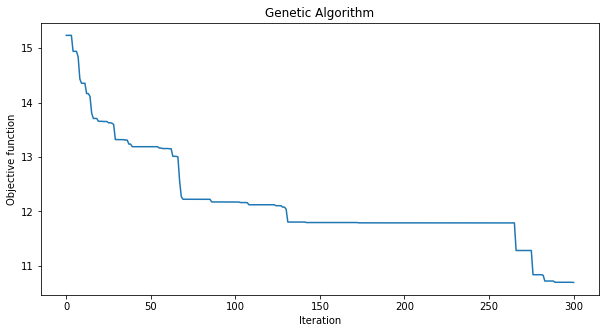

In [90]:
# GA 모델 생성
"""
function : 실제 해석을 위한 function을 무엇으로 할것인가? (데이터 input 형식과, model을 지정한 object_function_median를 사용)
dimension : 몇 차원의 문제를 풀것인가? = 몇개의 미지수를 푸는가? = 몇개의 feature를 사용하는가?
            실제 idx는 0~12로 13개지만 positive_ratio는 likes / dislikes 이므로 12개
"""
model_ga_median = geneticalgorithm(function=object_function_median,
                                   dimension=12,
                                   variable_type='int',
                                   variable_boundaries=varbound,
                                   algorithm_parameters=algorithm_param)

model_ga_median.run()

## GA 결과 해석

### GA 통해 나온 결과 출력

In [93]:
"""
model_ga_median.report : 지정한 iteration동안 conversion된 objection function의 output을 담은 값
model_ga_median.output_dict : 최종 솔루션
"""
convergence_median = model_ga_median.report
solution_median = model_ga_median.output_dict

print(convergence_median)
print(solution_median)

[15.23345037769471, 15.23345037769471, 15.23345037769471, 15.23345037769471, 14.940025458585495, 14.940025458585495, 14.940025458585495, 14.837776216707026, 14.43314940170204, 14.35360264984254, 14.35360264984254, 14.35360264984254, 14.164422951112822, 14.164422951112822, 14.112971659469194, 13.801829396208396, 13.707056372953522, 13.707056372953522, 13.707056372953522, 13.654454087962868, 13.654454087962868, 13.654454087962868, 13.65086702014261, 13.65086702014261, 13.65086702014261, 13.62687591551369, 13.62687591551369, 13.620314073851, 13.596134899218983, 13.319121884773827, 13.319121884773827, 13.319121884773827, 13.319121884773827, 13.317153543669685, 13.317153543669685, 13.310023989377207, 13.310023989377207, 13.236008084199852, 13.236008084199852, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942333, 13.188151117942

- 현재 결과는 제대로 값을 알아보거나 해석하기가 힘들어서 적절한 조정이 필요하다.

### GA 결과를 DataFrame으로 변환

In [94]:
ga_solution = input_conversion(solution_median['variable']) # 10만 view를 만드는 각 feature의 condition 값
ga_solution = np.array(ga_solution).reshape(1, -1) # ga_solution를 np.array로 변경

# ga_solution를 DataFrame으로 변경
ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title_mean_enc,category_id_mean_enc
0,22059.00,2017.00,711.00,1.00,120.00,10.94,243.00,26.00,200.00,173.00,4.00,10591.00,1566611.81


- channel_title_mean이나 category_id_mean_enc는 int여서 해석이 어렵다.
- 기존 데이터셋에 있는 형태로 변경해서 해석할 수 있도록 해줘야 한다.

### GA로 예측한 Views의 50%에 해당하는 데이터

In [95]:
# 위의 df에서 channel_title_mean_enc의 값이 있는 실제 데이터를 찾아서 값을 replace
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'})

# 동일 방식으로 category_id도 처리
category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category_id
0,22059.00,2017.00,711.00,1.00,120.00,10.94,243.00,26.00,200.00,173.00,4.00,eSportsTV,10


In [96]:
# category_id의 실제 category 확인
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category
0,22059.00,2017.00,711.00,1.00,120.00,10.94,243.00,26.00,200.00,173.00,4.00,eSportsTV,Music


In [97]:
# GA로 찾은 최적 df의 Views 값 확인
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['Views'] = int(prediction[0])
ga_solution_median = ga_solution_df
ga_solution_median

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,22059.00,2017.00,711.00,1.00,120.00,10.94,243.00,26.00,200.00,173.00,4.00,eSportsTV,Music,143620


- 모델 성능이 다소 떨어져서 완벽하게 일치하지는 않는다.
- 원본 데이터의 Views의 50%인 약 9.9만일때보다 Views가 약 5만정도 많다. 

# 결과 검토 및 분석: 일반 YouTuber

- 위에서 찾은 condition은 일반적인 views를 가진 영상의 조건을 확인한 것.
- 이를 기반으로 다른 조건은 모두 동일한데 하나의 조건(e.g : comment_count)이 바뀌면 어떻게 값이 변하는지를 확인해볼 것.
- 일종의 몬테카를로 분석과 같은 것 (근데 이제 난수는 없는..)

In [80]:
df_rgb2.describe()

,category_id,views,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
count,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00,6578.00
mean,21.15,370133.64,15298.94,521.37,2372.07,94.63,87.25,85.70,2.54,15820.30,21.60,107.83,7259.14,50.86,1084.77,9.76,431.50,43.33,370133.64,370133.64
std,6.78,1659939.35,103540.35,11320.54,18720.62,31.17,29.39,29.58,12.44,108516.71,17.97,419.03,46981.96,195.53,7528.75,48.07,536.08,19.57,1359135.13,371093.88
min,1.00,2623.00,2.00,0.00,0.00,6.00,6.00,4.00,1.00,2.00,1.00,0.16,0.04,0.01,0.00,0.19,1.00,4.00,2623.00,23327.10
25%,20.00,44530.25,676.25,20.00,150.25,74.00,68.00,66.00,2.00,735.00,8.00,14.14,332.50,6.39,66.50,2.79,120.00,28.00,61167.94,132860.43
50%,24.00,99507.00,2017.50,54.00,429.00,95.00,87.00,84.00,2.00,2136.00,17.00,35.10,995.58,16.43,199.17,5.14,259.00,41.00,123279.91,277000.79
75%,25.00,233765.75,4760.00,142.00,1087.00,116.00,106.00,105.00,2.00,4917.50,30.00,78.80,2398.50,37.75,521.88,9.06,534.00,55.00,242365.00,408503.16
max,43.00,62796390.00,4470923.00,884965.00,905925.00,201.00,188.00,188.00,706.00,4589976.00,126.00,5325.75,1529992.00,2662.88,301975.00,1071.00,5235.00,100.00,52611730.00,1678646.17


## comment_count에 대한 의존성 확인

- comment_count의 숫자가 달라지면 Views에 어떤 변화가 생길까? 

In [98]:
# model_ga_median의 값 copy
# 여러번 검증작업을 할 것이기 때문에 원본 데이터에 영향을 주지 않는 deepcopy()를 사용
inf_input = copy.deepcopy(model_ga_median)


# comment_count를 split하면서 inference(학습된 model을 사용해서 입력에 대한 답을 추론하는 것) 결과를 확인해볼 예정
comment_count_dep_median = []

# comment_count 값의 범위가 0~90만으로 1000단위로 끊어서 분석
for i in tqdm_notebook(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i  # comment_count의 idx
    input_converted = input_conversion(inf_input.output_dict['variable']) # input_conversion 함수로 GA에 맞게 conversion
    input_converted = np.array(input_converted).reshape(1, -1) # np.array로 변경

    input_scaled = scaler.transform(input_converted) # 데이터 scailing (MinMax)
    prediction = voting_clf.predict(input_scaled)    # 예측
    comment_count_dep_median.append([i, int(prediction)]) # comment_count에 대한 결과 입력

  0%|          | 0/906 [00:00<?, ?it/s]

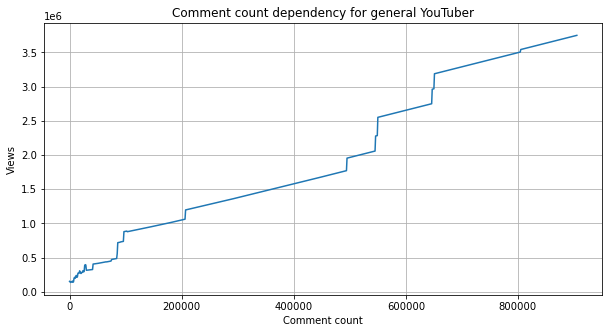

In [99]:
# 결과를 df로 변경해서 결과 확인
comment_count_dep_median_df = pd.DataFrame(comment_count_dep_median, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_median_df['comment_count'], comment_count_dep_median_df['views']);

In [130]:
# 해석용 GA 예측 데이터 출력
ga_solution_median

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,22059.00,2017.00,711.00,1.00,120.00,10.94,243.00,26.00,200.00,173.00,4.00,eSportsTV,Music,143620


- 전체적인 trend는 views의 증가에 따라 comment 수도 증가한다.
- 이를 통해 다른 feature는 변하지 않고, comment 수만 늘어날때 영상의 view가 어떻게 변하는지를 알 수 있다.
- 이는 전반적인 trend일뿐이다. 왜냐하면 comment가 매우 많은 일부 동영상 몇개가 확장되어 전체 데이터로 본것이어서 약간의 왜곡이 발생할 수 있다.

- 결국 이를 통해 알 수 있는 것은 '일반적인 영상(ga_solution_median 에서 찾은 정도의 condition을 가진 영상)이라면 "comment 수만 늘어난다면 위와 같이 View 수를 높일 수 있을 것이다." 라고 해석할 수 있다.

## positive_ratio에 대한 의존성 확인

- positive_ratio의 숫자가 달라지면 Views에 어떤 변화가 생길까? 

In [100]:
inf_input = copy.deepcopy(model_ga_median)

positive_ratio_dep_median = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

"""
positive_ratio는 likes와 dislikes의 값이 연동되어 있는 feature이다.
즉, positive_ratio가 변할때 동일한 값이어도 likes와 dislikes의 둘 모두의 변화가 있을 수 있다.
따라서, 기준 positive_ratio 값을 중심으로 input되는 likes 수와 dislikes의 수가 서로 교차하도록 하여 연산하는 것이 바람직해 보인다.
"""
for i in tqdm_notebook(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i) # total_sign = likes + dislikes
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_median.append([ratio, int(prediction)])

  0%|          | 0/500 [00:00<?, ?it/s]

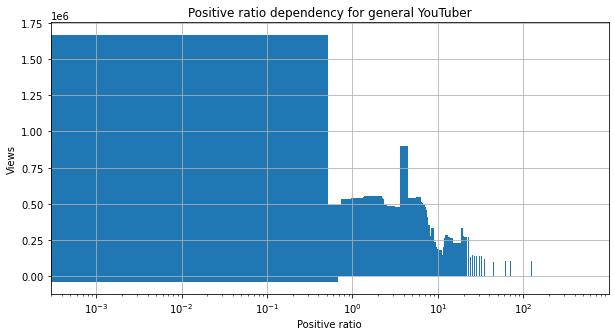

In [101]:
positive_ratio_dep_median_df = pd.DataFrame(positive_ratio_dep_median, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for general YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log') # 값을 확대해서 보기 위해 log scaling
plt.grid()
plt.bar(positive_ratio_dep_median_df['positive_ratio'], positive_ratio_dep_median_df['views']);

- ** 모든 조건(features)는 동일하고 positive ratio에 변화가 있을때에 대한 예측결과
---
- positive ratio가 증가하면 (like 수 > dislike 수) Views가 증가한다.
- 일반적으로 likes가 높아지면 조회수가 잘 나올거라 생각했지만, 반대의 경우인 것
- 굳이 해석을 하자면, 영상에 부정적인 이슈가 있었을때 view의 수가 증가할 수 있다. (일종의 노이즈 마케팅 효과 같은?)
- 단, 현재 그래프는 log scale을 적용한 결과임으로 어느정도의 왜곡은 존재한다.

In [105]:
# 해석용 GA 예측 데이터 출력
ga_solution_median

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,22059.00,2017.00,711.00,1.00,120.00,10.94,243.00,26.00,200.00,173.00,4.00,eSportsTV,Music,143620


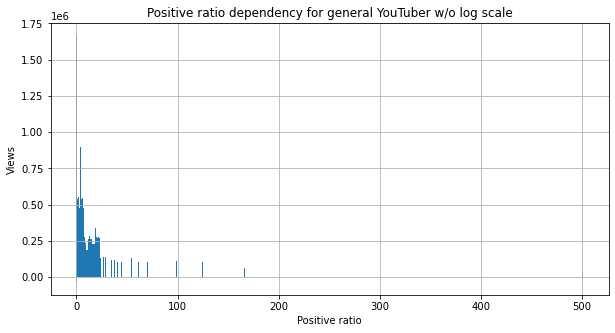

In [102]:
# log값이 제외된 경우 -> 제대로 값을 확인하기 어렵다.

plt.title('Positive ratio dependency for general YouTuber w/o log scale')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.grid()
plt.bar(positive_ratio_dep_median_df['positive_ratio'], positive_ratio_dep_median_df['views']);

## number_of_tag 에 대한 의존성 확인

- tag의 숫자가 달라지면 Views에 어떤 변화가 생길까? 

In [103]:
inf_input = copy.deepcopy(model_ga_median)

number_of_tag_dep_median = []

for i in tqdm_notebook(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_median.append([i, int(prediction)])

  0%|          | 0/125 [00:00<?, ?it/s]

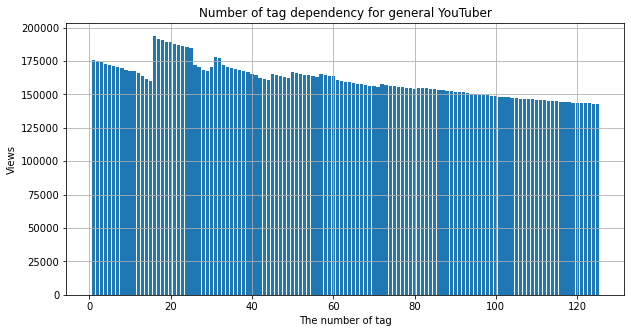

In [104]:
number_of_tag_dep_median_df = pd.DataFrame(number_of_tag_dep_median, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for general YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_median_df['number_of_tag'], number_of_tag_dep_median_df['views']);

In [106]:
# 해석용 GA 예측 데이터 출력
ga_solution_median

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,22059.00,2017.00,711.00,1.00,120.00,10.94,243.00,26.00,200.00,173.00,4.00,eSportsTV,Music,143620


- 유전알고리즘으로 찾은 10만  views의 기준이 되는 값은 tag가 120개 일때 이다.
- 즉, tag 수가 많으면, 다양한 tag로 인해 다양한 시청자가 유입되어서 views가 많을 것이라 생각했다.
- 하지만, 위의 그래프로 보면 tag수가 많을때 views가 높지 않고 되려 감소한다.
- 오히려 tag 수가 적을때 (10개 후반 ~ 20개 초중반)일때 View가 높은 수치를 기록하는 것을 알 수 있다.
---
- 결론적으로 tag의 수는 많다고 무조건 좋은 것이 아니다.
- tag수가 많으면 되려 유입되는 경로가 분산되어 views를 감소시키는 것 같다. (youtube의 추천 알고리즘과도 연관이 있을 듯하다.)

## 썸네일에 대한 의존성 확인

- 썸네일 수치의 변화는 views에 어떤 영향을 미칠까?
- 몬테카를로 시뮬레이션 시행
- 기존에는 rgb 의 avg를 사용했다.
- 썸네일은 결국 이미지이고, 동일 카테고리의 영상을 다른 이미지로 변했을때 views에 어떤 효과가 있느지를 확인하고 싶은 것.
- 따라서, rgb 값을 min ~ max범위내의 값중 임의의 값을 생성해서 rgb에 입력하고 그 결과가 어떤지를 살펴 볼 것이다.

In [107]:
inf_input = copy.deepcopy(model_ga_median)

random_image_dep_median = []

# 2000개 정도의 난수를 생성
for i in tqdm_notebook(range(2000)):    
    # 각각 r, g, b의 min~max 범위내에서 난수생성
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_median.append([i, int(prediction)])

  0%|          | 0/2000 [00:00<?, ?it/s]

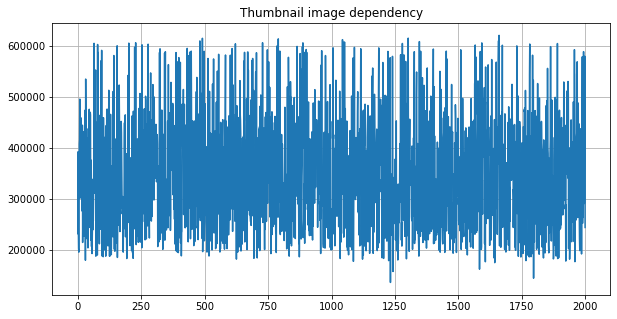

In [108]:
random_image_dep_median_df = pd.DataFrame(random_image_dep_median, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_median_df['Random_image'], random_image_dep_median_df['Views']);

- 조회수 10만을 목표로 할때 영상의 썸네일이 바뀌면 위의 그림과 같이 조회수 변동이 있을 수 있다.
- 다만 이 그림으로는 실질적 파악이 어렵다.
- 따라서 histogram을 통해 insight를 얻어야 한다.

Average views: 346958.0425
Median views: 326251.5
Standard deviation of views [count]: 109464.8963885015
Standard deviation of views     [%]: 31.549894505904557


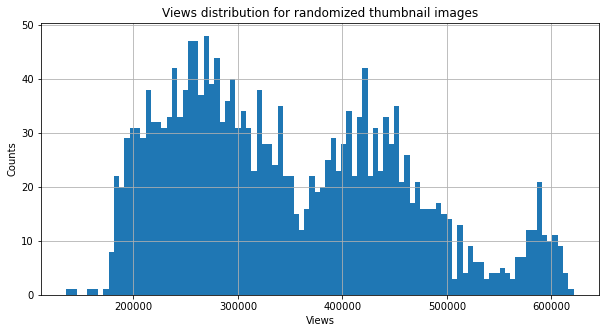

In [109]:
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_median_df['Views'], bins=96)

# 별도의 계산값 확인
print('Average views:', random_image_dep_median_df['Views'].mean())
print('Median views:', random_image_dep_median_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_median_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_median_df['Views'].std()*100 / random_image_dep_median_df['Views'].mean())

- 썸네일의 변화를 통해 최대 60만 정도의 View를 기록할 수도 있다.
- Std %로 보아 일반적인 Youtube 영상은 썸네일에 따라 Views의 변화가 31%가량 변동될 수 있다.
- 즉, 썸네일의 Views에 대한 영향력은 31% 정도 이다.
- 전체 대비로 보면 약 1/3 수준으로 영상 조회수에 썸네일이 지대한 영향을 끼치는 것을 알 수 있다.

# channel_title 에 대한 의존성 확인(mean_encode_channel)

- 

In [111]:
inf_input = copy.deepcopy(model_ga_median)

channel_title_dep_median = []

for i in tqdm_notebook(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i  # # 11: 'channel_title_mean_enc'
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_median.append([mean_encode_channel.index[i], int(prediction)])

  0%|          | 0/1483 [00:00<?, ?it/s]

<BarContainer object of 1483 artists>

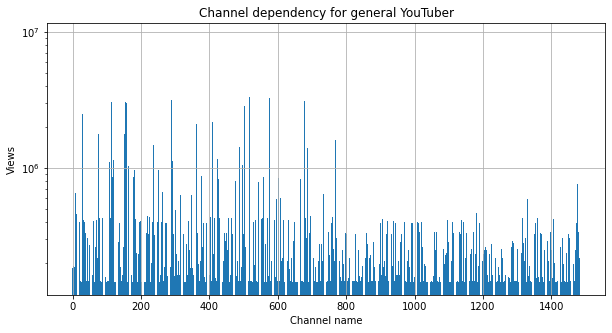

In [112]:
channel_title_dep_median_df = pd.DataFrame(channel_title_dep_median, columns=['channel_title', 'views'])

plt.title('Channel dependency for general YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_median_df['channel_title'])), channel_title_dep_median_df['views'])

- y scale이 log값이다.
- 기준점은 model_ga_median의 기준이었던 약 10만
- 데이터 내의 Unique한 채널 1483개에 대한 분포 확인
- 특정 채널의 경우 채널만 바꿨는데도 조회수가 급증 하는 현상이 보여진다.
- 하지만 이것만으로는 실질적인 데이터 확인이 어려우니 histogram과 채널별 views 를 확인해봐야 한다.

In [113]:
# Views가 높은 상위 10개의 채널 
channel_title_dep_median_df.sort_values(by='views', ascending=False).head(10)

,channel_title,views
625,YouTube Spotlight,9385277
177,FoxStarHindi,3844418
517,T-Series,3280196
16,20th Century Fox,3243690
51,ArianaGrandeVevo,3231654
576,Troom Troom,3228504
55,AsapSCIENCE,3221069
165,Ed Sheeran,3166387
289,KatyPerryVEVO,3131478
565,TheWeekndVEVO,3129968


- 비슷한 feature를 가진 영상이라도 채널이 어딘가에 따라 조회수가 차이가 날 수 있다는 것을 알 수 있다.
- 다시 말하면 이는 모델내에서 channel_title이 가진 영향력이 크다는 것이다.

Average views: 354069.5826028321
Median views: 205173.0
Standard deviation of views [count]: 522818.47073121514
Standard deviation of views     [%]: 147.65980937641643


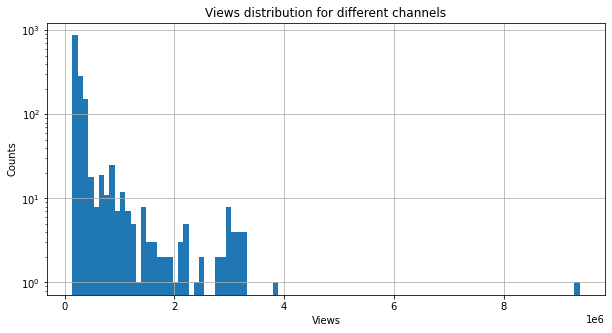

In [118]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_median_df['views'], bins=96)

print('Average views:', channel_title_dep_median_df['views'].mean())
print('Median views:', channel_title_dep_median_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_median_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_median_df['views'].std()*100 / channel_title_dep_median_df['views'].mean())

- 기준점(분석의 기준)이 되는 범위는 Views가 10만인 부분 = 1 부근
- 2~4 범위를 보면 채널명이 변경되었을때 안좋아지는 경우도 꽤 많이 관찰된다.
- Std로 보면 147%로 일반적인  Youtube의 경우 채널이 가진 영향력이 매우 크다 는 것을 알 수 있다.
- 동일한 동영상이라도 채널명을 바꾸면 조회수가 감소할 수 있다. 

# 유전 알고리즘 - 최적 피쳐 탐색: Top YouTuber

- 그렇다면 많은 Views를 자랑하는 상위 동영상은 어떤 조건을 갖고 있을까?

- 관련 함수는 일반 YouTuber 부분에서 미리 정의 했기 때문에 skip
- GA에 입력될 데이터 범주를 변경할 예정 : 기존 분석에 비해 더 넓은 범위의 데이터를 입력
- 일반 YouTuber 때와 마찬가지로 'Music' 카테고리에서 상위 Youtuber에 대한 조건을 살펴 볼 것
---

- like & dislike & comment_count 는  기존 데이터보다 2배 더 넓게 범위 설정

## GA에 input되는 variables의 범위 설정

In [119]:
# 실제 모델에 사용된 features
# features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag', 'positive_ratio',
#             'description_length', 'title_length', 'r_avg', 'g_avg', 'b_avg', 'channel_title_mean_enc',
#             'category_id_mean_enc']

# feautre의 list idx_num을 활용해서 함수 생성
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()*2],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()*2],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()*2],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()*2],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]],
                     [2, 2]])

## GA에 직접 사용할 object function함수 생성

In [120]:
def object_function_top(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = 70000000
    print('Predicted views:', int(prediction), 'Difference from target:', int(target - prediction))

    # return abs(int(prediction) - target)
    # target값을 median에서 70000000으로 변경
    # 과도한 target값은 되려 분석에 악영향을 주니 reasonable한 값을 지정해주는게 중요하다.
    return math.log(abs(target - int(prediction))) 

In [121]:
# GA 모델에 적용할 parameter 지정
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

## GA 모델에 적용

Predicted views: 41955285 Difference from target: 28044714
Predicted views: 35917199 Difference from target: 34082800
Predicted views: 33012373 Difference from target: 36987626
Predicted views: 35243892 Difference from target: 34756107
Predicted views: 42261371 Difference from target: 27738628
Predicted views: 19618028 Difference from target: 50381971
Predicted views: 43005380 Difference from target: 26994619
Predicted views: 24678076 Difference from target: 45321923
Predicted views: 31668941 Difference from target: 38331058
Predicted views: 31986417 Difference from target: 38013582
Predicted views: 38016551 Difference from target: 31983448
Predicted views: 28353534 Difference from target: 41646465
Predicted views: 49092595 Difference from target: 20907404
Predicted views: 25405978 Difference from target: 44594021
Predicted views: 25347252 Difference from target: 44652747
Predicted views: 31561957 Difference from target: 38438042
Predicted views: 23723528 Difference from target: 462764

Predicted views: 44539260 Difference from target: 25460739
Predicted views: 35939171 Difference from target: 34060828
Predicted views: 33576596 Difference from target: 36423403
Predicted views: 41357612 Difference from target: 28642387
Predicted views: 35371069 Difference from target: 34628930
Predicted views: 20237594 Difference from target: 49762405
Predicted views: 29196062 Difference from target: 40803937
Predicted views: 45882533 Difference from target: 24117466
Predicted views: 33424790 Difference from target: 36575209
Predicted views: 27719854 Difference from target: 42280145
Predicted views: 40293015 Difference from target: 29706984
Predicted views: 31188036 Difference from target: 38811963
Predicted views: 36234314 Difference from target: 33765685
Predicted views: 41447900 Difference from target: 28552099
Predicted views: 30709504 Difference from target: 39290495
Predicted views: 34620502 Difference from target: 35379497
Predicted views: 41403074 Difference from target: 285969

Predicted views: 32211543 Difference from target: 37788456
Predicted views: 35567222 Difference from target: 34432777
Predicted views: 38206410 Difference from target: 31793589
Predicted views: 35280887 Difference from target: 34719112
Predicted views: 36565656 Difference from target: 33434343
Predicted views: 41444355 Difference from target: 28555644
Predicted views: 39280976 Difference from target: 30719023
Predicted views: 30825951 Difference from target: 39174048
Predicted views: 36947168 Difference from target: 33052831
Predicted views: 42189060 Difference from target: 27810939
Predicted views: 26861824 Difference from target: 43138175
Predicted views: 35616016 Difference from target: 34383983
Predicted views: 35373250 Difference from target: 34626749
Predicted views: 30833683 Difference from target: 39166316
Predicted views: 36971178 Difference from target: 33028821
Predicted views: 45373167 Difference from target: 24626832
Predicted views: 47694069 Difference from target: 223059

Predicted views: 39053129 Difference from target: 30946870
Predicted views: 33854002 Difference from target: 36145997
Predicted views: 39562525 Difference from target: 30437474
Predicted views: 56499261 Difference from target: 13500738
Predicted views: 34663679 Difference from target: 35336320
Predicted views: 34819925 Difference from target: 35180074
Predicted views: 43024987 Difference from target: 26975012
Predicted views: 45153247 Difference from target: 24846752
Predicted views: 30892484 Difference from target: 39107515
Predicted views: 43945920 Difference from target: 26054079
Predicted views: 42539755 Difference from target: 27460244
Predicted views: 40863126 Difference from target: 29136873
Predicted views: 52998252 Difference from target: 17001747
Predicted views: 35757482 Difference from target: 34242517
Predicted views: 25031039 Difference from target: 44968960
Predicted views: 35079320 Difference from target: 34920679
Predicted views: 34003828 Difference from target: 359961

Predicted views: 56305645 Difference from target: 13694354
Predicted views: 43848368 Difference from target: 26151631
Predicted views: 57609157 Difference from target: 12390842
Predicted views: 42834092 Difference from target: 27165907
Predicted views: 45018108 Difference from target: 24981891
Predicted views: 33702919 Difference from target: 36297080
Predicted views: 38122109 Difference from target: 31877890
Predicted views: 49890675 Difference from target: 20109324
Predicted views: 31357586 Difference from target: 38642413
Predicted views: 41479032 Difference from target: 28520967
Predicted views: 30034619 Difference from target: 39965380
Predicted views: 58906605 Difference from target: 11093394
Predicted views: 43514519 Difference from target: 26485480
Predicted views: 57598603 Difference from target: 12401396
Predicted views: 48007112 Difference from target: 21992887
Predicted views: 41009918 Difference from target: 28990081
Predicted views: 30437620 Difference from target: 395623

Predicted views: 42271932 Difference from target: 27728067
Predicted views: 48210014 Difference from target: 21789985
Predicted views: 39194037 Difference from target: 30805962
Predicted views: 42964007 Difference from target: 27035992
Predicted views: 53951794 Difference from target: 16048205
Predicted views: 40778051 Difference from target: 29221948
Predicted views: 48626790 Difference from target: 21373209
Predicted views: 28659068 Difference from target: 41340931
Predicted views: 44540139 Difference from target: 25459860
Predicted views: 35949353 Difference from target: 34050646
Predicted views: 41429226 Difference from target: 28570773
Predicted views: 42432713 Difference from target: 27567286
Predicted views: 38273130 Difference from target: 31726869
Predicted views: 31313641 Difference from target: 38686358
Predicted views: 44037005 Difference from target: 25962994
Predicted views: 40696112 Difference from target: 29303887
Predicted views: 42837852 Difference from target: 271621

Predicted views: 50851906 Difference from target: 19148093
Predicted views: 51631684 Difference from target: 18368315
Predicted views: 37604613 Difference from target: 32395386
Predicted views: 29878589 Difference from target: 40121410
Predicted views: 39108185 Difference from target: 30891814
Predicted views: 49236127 Difference from target: 20763872
Predicted views: 53586334 Difference from target: 16413665
Predicted views: 45837097 Difference from target: 24162902
Predicted views: 41428762 Difference from target: 28571237
Predicted views: 41130385 Difference from target: 28869614
Predicted views: 47690203 Difference from target: 22309796
Predicted views: 54576919 Difference from target: 15423080
Predicted views: 33566162 Difference from target: 36433837
Predicted views: 31299166 Difference from target: 38700833
Predicted views: 34558475 Difference from target: 35441524
Predicted views: 36827949 Difference from target: 33172050
Predicted views: 42935543 Difference from target: 270644

Predicted views: 56951178 Difference from target: 13048821
Predicted views: 56847645 Difference from target: 13152354
Predicted views: 38044464 Difference from target: 31955535
Predicted views: 33774953 Difference from target: 36225046
Predicted views: 43758544 Difference from target: 26241455
Predicted views: 43976510 Difference from target: 26023489
Predicted views: 36034098 Difference from target: 33965901
Predicted views: 38969938 Difference from target: 31030061
Predicted views: 44271223 Difference from target: 25728776
Predicted views: 51993405 Difference from target: 18006594
Predicted views: 51562425 Difference from target: 18437574
Predicted views: 41657707 Difference from target: 28342292
Predicted views: 56836357 Difference from target: 13163642
Predicted views: 37606405 Difference from target: 32393594
Predicted views: 43388948 Difference from target: 26611051
Predicted views: 36725453 Difference from target: 33274546
Predicted views: 59059188 Difference from target: 109408

Predicted views: 42429027 Difference from target: 27570972
Predicted views: 42400582 Difference from target: 27599417
Predicted views: 56978808 Difference from target: 13021191
Predicted views: 37920210 Difference from target: 32079789
Predicted views: 56608873 Difference from target: 13391126
Predicted views: 51156956 Difference from target: 18843043
Predicted views: 56883054 Difference from target: 13116945
Predicted views: 55949029 Difference from target: 14050970
Predicted views: 43344499 Difference from target: 26655500
Predicted views: 43855987 Difference from target: 26144012
Predicted views: 43927857 Difference from target: 26072142
Predicted views: 56727525 Difference from target: 13272474
Predicted views: 38075615 Difference from target: 31924384
Predicted views: 59139404 Difference from target: 10860595
Predicted views: 56761651 Difference from target: 13238348
Predicted views: 50006635 Difference from target: 19993364
Predicted views: 51806179 Difference from target: 181938

Predicted views: 52238853 Difference from target: 17761146
Predicted views: 60407954 Difference from target: 9592045
Predicted views: 44199999 Difference from target: 25800000
Predicted views: 31653962 Difference from target: 38346037
Predicted views: 37117640 Difference from target: 32882359
Predicted views: 59859808 Difference from target: 10140191
Predicted views: 55039332 Difference from target: 14960667
Predicted views: 55918940 Difference from target: 14081059
Predicted views: 56970832 Difference from target: 13029167
Predicted views: 56372446 Difference from target: 13627553
Predicted views: 43376249 Difference from target: 26623750
Predicted views: 51344928 Difference from target: 18655071
Predicted views: 59257575 Difference from target: 10742424
Predicted views: 58128507 Difference from target: 11871492
Predicted views: 36034221 Difference from target: 33965778
Predicted views: 57033517 Difference from target: 12966482
Predicted views: 58065687 Difference from target: 1193431

Predicted views: 60877071 Difference from target: 9122928
Predicted views: 59063665 Difference from target: 10936334
Predicted views: 58818350 Difference from target: 11181649
Predicted views: 44009940 Difference from target: 25990059
Predicted views: 61010113 Difference from target: 8989886
Predicted views: 58012149 Difference from target: 11987850
Predicted views: 58668284 Difference from target: 11331715
Predicted views: 58840862 Difference from target: 11159137
Predicted views: 36788712 Difference from target: 33211287
Predicted views: 57807248 Difference from target: 12192751
Predicted views: 58938994 Difference from target: 11061005
Predicted views: 52677802 Difference from target: 17322197
Predicted views: 60339471 Difference from target: 9660528
Predicted views: 44796010 Difference from target: 25203989
Predicted views: 59350803 Difference from target: 10649196
Predicted views: 42667936 Difference from target: 27332063
Predicted views: 43513056 Difference from target: 26486943


Predicted views: 57598138 Difference from target: 12401861
Predicted views: 58783155 Difference from target: 11216844
Predicted views: 59985557 Difference from target: 10014442
Predicted views: 45805239 Difference from target: 24194760
Predicted views: 57757843 Difference from target: 12242156
Predicted views: 58772773 Difference from target: 11227226
Predicted views: 60231145 Difference from target: 9768854
Predicted views: 58671004 Difference from target: 11328995
Predicted views: 56753427 Difference from target: 13246572
Predicted views: 46242275 Difference from target: 23757724
Predicted views: 42297094 Difference from target: 27702905
Predicted views: 58764941 Difference from target: 11235058
Predicted views: 60168169 Difference from target: 9831830
Predicted views: 57996905 Difference from target: 12003094
Predicted views: 39039583 Difference from target: 30960416
Predicted views: 59091673 Difference from target: 10908326
Predicted views: 60106303 Difference from target: 9893696


Predicted views: 60200048 Difference from target: 9799951
Predicted views: 60513267 Difference from target: 9486732
Predicted views: 57517523 Difference from target: 12482476
Predicted views: 61433808 Difference from target: 8566191
Predicted views: 59292397 Difference from target: 10707602
Predicted views: 56569072 Difference from target: 13430927
Predicted views: 57296596 Difference from target: 12703403
Predicted views: 59932553 Difference from target: 10067446
Predicted views: 45572181 Difference from target: 24427818
Predicted views: 57067643 Difference from target: 12932356
Predicted views: 46599143 Difference from target: 23400856
Predicted views: 59182501 Difference from target: 10817498
Predicted views: 60263123 Difference from target: 9736876
Predicted views: 60009969 Difference from target: 9990030
Predicted views: 46163851 Difference from target: 23836148
Predicted views: 58735910 Difference from target: 11264089
Predicted views: 57543147 Difference from target: 12456852
Pr

Predicted views: 42195396 Difference from target: 27804603
Predicted views: 52681619 Difference from target: 17318380
Predicted views: 57470782 Difference from target: 12529217
Predicted views: 60277441 Difference from target: 9722558
Predicted views: 56522351 Difference from target: 13477648
Predicted views: 56750648 Difference from target: 13249351
Predicted views: 59016408 Difference from target: 10983591
Predicted views: 59273633 Difference from target: 10726366
Predicted views: 50333846 Difference from target: 19666153
Predicted views: 59260551 Difference from target: 10739448
Predicted views: 56512053 Difference from target: 13487946
Predicted views: 58559377 Difference from target: 11440622
Predicted views: 25619373 Difference from target: 44380626
Predicted views: 57703416 Difference from target: 12296583
Predicted views: 39116911 Difference from target: 30883088
Predicted views: 59078290 Difference from target: 10921709
Predicted views: 60633578 Difference from target: 9366421

Predicted views: 60356610 Difference from target: 9643389
Predicted views: 50244769 Difference from target: 19755230
Predicted views: 58287943 Difference from target: 11712056
Predicted views: 58822994 Difference from target: 11177005
Predicted views: 57653336 Difference from target: 12346663
Predicted views: 50759342 Difference from target: 19240657
Predicted views: 53229658 Difference from target: 16770341
Predicted views: 47857700 Difference from target: 22142299
Predicted views: 60183013 Difference from target: 9816986
Predicted views: 50881761 Difference from target: 19118238
Predicted views: 49657490 Difference from target: 20342509
Predicted views: 58943785 Difference from target: 11056214
Predicted views: 61056858 Difference from target: 8943141
Predicted views: 57785701 Difference from target: 12214298
Predicted views: 60236917 Difference from target: 9763082
Predicted views: 57308795 Difference from target: 12691204
Predicted views: 36810350 Difference from target: 33189649
P

Predicted views: 57420694 Difference from target: 12579305
Predicted views: 59209507 Difference from target: 10790492
Predicted views: 54667863 Difference from target: 15332136
Predicted views: 60620678 Difference from target: 9379321
Predicted views: 60509391 Difference from target: 9490608
Predicted views: 46059264 Difference from target: 23940735
Predicted views: 60018330 Difference from target: 9981669
Predicted views: 53676297 Difference from target: 16323702
Predicted views: 59653704 Difference from target: 10346295
Predicted views: 60739198 Difference from target: 9260801
Predicted views: 44818856 Difference from target: 25181143
Predicted views: 59579737 Difference from target: 10420262
Predicted views: 60379326 Difference from target: 9620673
Predicted views: 59083420 Difference from target: 10916579
Predicted views: 56653005 Difference from target: 13346994
Predicted views: 60412462 Difference from target: 9587537
Predicted views: 60173955 Difference from target: 9826044
Pred

Predicted views: 60657111 Difference from target: 9342888
Predicted views: 55379220 Difference from target: 14620779
Predicted views: 60058980 Difference from target: 9941019
Predicted views: 50858374 Difference from target: 19141625
Predicted views: 61399224 Difference from target: 8600775
Predicted views: 46179875 Difference from target: 23820124
Predicted views: 46194598 Difference from target: 23805401
Predicted views: 44195125 Difference from target: 25804874
Predicted views: 49737430 Difference from target: 20262569
Predicted views: 60321331 Difference from target: 9678668
Predicted views: 60641402 Difference from target: 9358597
Predicted views: 41662289 Difference from target: 28337710
Predicted views: 44381318 Difference from target: 25618681
Predicted views: 54891477 Difference from target: 15108522
Predicted views: 56341476 Difference from target: 13658523
Predicted views: 46103232 Difference from target: 23896767
Predicted views: 43746739 Difference from target: 26253260
Pr

Predicted views: 41304770 Difference from target: 28695229
Predicted views: 60379096 Difference from target: 9620903
Predicted views: 44448398 Difference from target: 25551601
Predicted views: 60816214 Difference from target: 9183785
Predicted views: 50545557 Difference from target: 19454442
Predicted views: 61332215 Difference from target: 8667784
Predicted views: 36466131 Difference from target: 33533868
Predicted views: 46744701 Difference from target: 23255298
Predicted views: 58352350 Difference from target: 11647649
Predicted views: 59860438 Difference from target: 10139561
Predicted views: 45478400 Difference from target: 24521599
Predicted views: 52094437 Difference from target: 17905562
Predicted views: 60483619 Difference from target: 9516380
Predicted views: 46326379 Difference from target: 23673620
Predicted views: 57798596 Difference from target: 12201403
Predicted views: 60267689 Difference from target: 9732310
Predicted views: 46547198 Difference from target: 23452801
Pr

Predicted views: 58552053 Difference from target: 11447946
Predicted views: 58767613 Difference from target: 11232386
Predicted views: 53313925 Difference from target: 16686074
Predicted views: 45019636 Difference from target: 24980363
Predicted views: 59695378 Difference from target: 10304621
Predicted views: 60930059 Difference from target: 9069940
Predicted views: 46843201 Difference from target: 23156798
Predicted views: 62151892 Difference from target: 7848107
Predicted views: 60650310 Difference from target: 9349689
Predicted views: 61937910 Difference from target: 8062089
Predicted views: 59094392 Difference from target: 10905607
Predicted views: 59979749 Difference from target: 10020250
Predicted views: 58547431 Difference from target: 11452568
Predicted views: 57828571 Difference from target: 12171428
Predicted views: 59710604 Difference from target: 10289395
Predicted views: 61060862 Difference from target: 8939137
Predicted views: 58367374 Difference from target: 11632625
Pr

|||||||___________________________________________ 14.3% GA is running...Predicted views: 51299580 Difference from target: 18700419
Predicted views: 59417379 Difference from target: 10582620
Predicted views: 59755749 Difference from target: 10244250
Predicted views: 59263713 Difference from target: 10736286
Predicted views: 59546295 Difference from target: 10453704
Predicted views: 58704625 Difference from target: 11295374
Predicted views: 62400189 Difference from target: 7599810
Predicted views: 57741536 Difference from target: 12258463
Predicted views: 60586771 Difference from target: 9413228
Predicted views: 55989077 Difference from target: 14010922
Predicted views: 45640503 Difference from target: 24359496
Predicted views: 54976173 Difference from target: 15023826
Predicted views: 61382512 Difference from target: 8617487
Predicted views: 58711363 Difference from target: 11288636
Predicted views: 50949343 Difference from target: 19050656
Predicted views: 60390846 Difference from tar

Predicted views: 60380050 Difference from target: 9619949
Predicted views: 54056461 Difference from target: 15943538
Predicted views: 52030150 Difference from target: 17969849
Predicted views: 61920500 Difference from target: 8079499
||||||||__________________________________________ 15.7% GA is running...Predicted views: 65816892 Difference from target: 4183107
Predicted views: 59655449 Difference from target: 10344550
Predicted views: 56145467 Difference from target: 13854532
Predicted views: 58339914 Difference from target: 11660085
Predicted views: 67414502 Difference from target: 2585497
Predicted views: 64675791 Difference from target: 5324208
Predicted views: 59878048 Difference from target: 10121951
Predicted views: 60204354 Difference from target: 9795645
Predicted views: 61452248 Difference from target: 8547751
Predicted views: 60647342 Difference from target: 9352657
Predicted views: 62663482 Difference from target: 7336517
Predicted views: 60452393 Difference from target: 9

Predicted views: 60421925 Difference from target: 9578074
Predicted views: 49235857 Difference from target: 20764142
Predicted views: 66871085 Difference from target: 3128914
Predicted views: 59896199 Difference from target: 10103800
Predicted views: 46797634 Difference from target: 23202365
||||||||__________________________________________ 16.3% GA is running...Predicted views: 66275834 Difference from target: 3724165
Predicted views: 66226954 Difference from target: 3773045
Predicted views: 60031310 Difference from target: 9968689
Predicted views: 49117842 Difference from target: 20882157
Predicted views: 55974247 Difference from target: 14025752
Predicted views: 55216663 Difference from target: 14783336
Predicted views: 49874866 Difference from target: 20125133
Predicted views: 67138274 Difference from target: 2861725
Predicted views: 59971328 Difference from target: 10028671
Predicted views: 50329853 Difference from target: 19670146
Predicted views: 50356600 Difference from target

Predicted views: 60082894 Difference from target: 9917105
Predicted views: 67292062 Difference from target: 2707937
Predicted views: 60534299 Difference from target: 9465700
Predicted views: 60507305 Difference from target: 9492694
Predicted views: 60568784 Difference from target: 9431215
Predicted views: 66294871 Difference from target: 3705128
||||||||__________________________________________ 17.0% GA is running...Predicted views: 64567990 Difference from target: 5432009
Predicted views: 66618425 Difference from target: 3381574
Predicted views: 65497845 Difference from target: 4502154
Predicted views: 53523777 Difference from target: 16476222
Predicted views: 66229070 Difference from target: 3770929
Predicted views: 32357517 Difference from target: 37642482
Predicted views: 67326535 Difference from target: 2673464
Predicted views: 67555676 Difference from target: 2444323
Predicted views: 60411691 Difference from target: 9588308
Predicted views: 45831189 Difference from target: 24168

Predicted views: 59473024 Difference from target: 10526975
Predicted views: 67485402 Difference from target: 2514597
Predicted views: 65586180 Difference from target: 4413819
|||||||||_________________________________________ 17.7% GA is running...Predicted views: 65779194 Difference from target: 4220805
Predicted views: 62518426 Difference from target: 7481573
Predicted views: 66104703 Difference from target: 3895296
Predicted views: 66135100 Difference from target: 3864899
Predicted views: 66793152 Difference from target: 3206847
Predicted views: 45314309 Difference from target: 24685690
Predicted views: 65786045 Difference from target: 4213954
Predicted views: 67509859 Difference from target: 2490140
Predicted views: 60535471 Difference from target: 9464528
Predicted views: 60535471 Difference from target: 9464528
Predicted views: 58883989 Difference from target: 11116010
Predicted views: 46091550 Difference from target: 23908449
Predicted views: 60779314 Difference from target: 922

Predicted views: 55308546 Difference from target: 14691453
Predicted views: 59294300 Difference from target: 10705699
Predicted views: 45800411 Difference from target: 24199588
Predicted views: 65089388 Difference from target: 4910611
Predicted views: 66159283 Difference from target: 3840716
Predicted views: 61976049 Difference from target: 8023950
Predicted views: 65884309 Difference from target: 4115690
||||||||||________________________________________ 19.0% GA is running...Predicted views: 63239166 Difference from target: 6760833
Predicted views: 66187205 Difference from target: 3812794
Predicted views: 67706969 Difference from target: 2293030
Predicted views: 65142919 Difference from target: 4857080
Predicted views: 61654758 Difference from target: 8345241
Predicted views: 66769213 Difference from target: 3230786
Predicted views: 65968398 Difference from target: 4031601
Predicted views: 66664057 Difference from target: 3335942
Predicted views: 65619776 Difference from target: 4380

Predicted views: 67628133 Difference from target: 2371866
Predicted views: 67695894 Difference from target: 2304105
Predicted views: 67586053 Difference from target: 2413946
Predicted views: 65849362 Difference from target: 4150637
Predicted views: 46546578 Difference from target: 23453421
||||||||||________________________________________ 19.7% GA is running...Predicted views: 66950913 Difference from target: 3049086
Predicted views: 67476341 Difference from target: 2523658
Predicted views: 66392069 Difference from target: 3607930
Predicted views: 47241352 Difference from target: 22758647
Predicted views: 66651171 Difference from target: 3348828
Predicted views: 67813229 Difference from target: 2186770
Predicted views: 67039568 Difference from target: 2960431
Predicted views: 66184823 Difference from target: 3815176
Predicted views: 63062781 Difference from target: 6937218
Predicted views: 67638062 Difference from target: 2361937
Predicted views: 46071390 Difference from target: 23928

Predicted views: 66566796 Difference from target: 3433203
Predicted views: 65154907 Difference from target: 4845092
Predicted views: 67764135 Difference from target: 2235864
Predicted views: 65911917 Difference from target: 4088082
Predicted views: 67603522 Difference from target: 2396477
Predicted views: 52840146 Difference from target: 17159853
Predicted views: 67776017 Difference from target: 2223982
||||||||||________________________________________ 20.3% GA is running...Predicted views: 62157430 Difference from target: 7842569
Predicted views: 67257619 Difference from target: 2742380
Predicted views: 66772175 Difference from target: 3227824
Predicted views: 65721792 Difference from target: 4278207
Predicted views: 67529844 Difference from target: 2470155
Predicted views: 67735477 Difference from target: 2264522
Predicted views: 67376824 Difference from target: 2623175
Predicted views: 64128081 Difference from target: 5871918
Predicted views: 66372462 Difference from target: 362753

Predicted views: 66366846 Difference from target: 3633153
Predicted views: 58767337 Difference from target: 11232662
Predicted views: 67782396 Difference from target: 2217603
Predicted views: 56818766 Difference from target: 13181233
Predicted views: 66495824 Difference from target: 3504175
Predicted views: 66106568 Difference from target: 3893431
Predicted views: 67017843 Difference from target: 2982156
||||||||||________________________________________ 21.0% GA is running...Predicted views: 58515936 Difference from target: 11484063
Predicted views: 68218368 Difference from target: 1781631
Predicted views: 66290669 Difference from target: 3709330
Predicted views: 61391420 Difference from target: 8608579
Predicted views: 65379159 Difference from target: 4620840
Predicted views: 66302551 Difference from target: 3697448
Predicted views: 66106130 Difference from target: 3893869
Predicted views: 67767292 Difference from target: 2232707
Predicted views: 67966644 Difference from target: 2033

Predicted views: 67124891 Difference from target: 2875108
Predicted views: 67734501 Difference from target: 2265498
Predicted views: 66495828 Difference from target: 3504171
Predicted views: 46787000 Difference from target: 23212999
Predicted views: 68171932 Difference from target: 1828067
Predicted views: 66744641 Difference from target: 3255358
Predicted views: 58947029 Difference from target: 11052970
|||||||||||_______________________________________ 21.7% GA is running...Predicted views: 66652105 Difference from target: 3347894
Predicted views: 67776211 Difference from target: 2223788
Predicted views: 66916048 Difference from target: 3083951
Predicted views: 67469282 Difference from target: 2530717
Predicted views: 67237811 Difference from target: 2762188
Predicted views: 43471639 Difference from target: 26528360
Predicted views: 67361206 Difference from target: 2638793
Predicted views: 67350224 Difference from target: 2649775
Predicted views: 67863495 Difference from target: 2136

Predicted views: 66168988 Difference from target: 3831011
Predicted views: 67320245 Difference from target: 2679754
Predicted views: 67473120 Difference from target: 2526879
Predicted views: 60641026 Difference from target: 9358973
Predicted views: 65964196 Difference from target: 4035803
Predicted views: 67993085 Difference from target: 2006914
Predicted views: 64006253 Difference from target: 5993746
Predicted views: 66492519 Difference from target: 3507480
|||||||||||_______________________________________ 22.3% GA is running...Predicted views: 53447330 Difference from target: 16552669
Predicted views: 67344983 Difference from target: 2655016
Predicted views: 55561008 Difference from target: 14438991
Predicted views: 67479466 Difference from target: 2520533
Predicted views: 65626655 Difference from target: 4373344
Predicted views: 67424728 Difference from target: 2575271
Predicted views: 66751036 Difference from target: 3248963
Predicted views: 66873517 Difference from target: 31264

Predicted views: 66860178 Difference from target: 3139821
Predicted views: 66907872 Difference from target: 3092127
Predicted views: 48095551 Difference from target: 21904448
Predicted views: 46353840 Difference from target: 23646159
Predicted views: 47359161 Difference from target: 22640838
Predicted views: 67042572 Difference from target: 2957427
||||||||||||______________________________________ 23.0% GA is running...Predicted views: 67251832 Difference from target: 2748167
Predicted views: 47421314 Difference from target: 22578685
Predicted views: 67987264 Difference from target: 2012735
Predicted views: 67690753 Difference from target: 2309246
Predicted views: 67835194 Difference from target: 2164805
Predicted views: 66572728 Difference from target: 3427271
Predicted views: 66206948 Difference from target: 3793051
Predicted views: 65819019 Difference from target: 4180980
Predicted views: 47935923 Difference from target: 22064076
Predicted views: 67284012 Difference from target: 27

Predicted views: 65616152 Difference from target: 4383847
Predicted views: 60997418 Difference from target: 9002581
Predicted views: 45290440 Difference from target: 24709559
Predicted views: 61998822 Difference from target: 8001177
Predicted views: 66919465 Difference from target: 3080534
Predicted views: 67937451 Difference from target: 2062548
Predicted views: 67063515 Difference from target: 2936484
||||||||||||______________________________________ 23.7% GA is running...Predicted views: 47487763 Difference from target: 22512236
Predicted views: 66832701 Difference from target: 3167298
Predicted views: 67961003 Difference from target: 2038996
Predicted views: 66709765 Difference from target: 3290234
Predicted views: 64031795 Difference from target: 5968204
Predicted views: 60851524 Difference from target: 9148475
Predicted views: 67403232 Difference from target: 2596767
Predicted views: 47366672 Difference from target: 22633327
Predicted views: 67407860 Difference from target: 2592

Predicted views: 63876691 Difference from target: 6123308
Predicted views: 54430496 Difference from target: 15569503
Predicted views: 67311069 Difference from target: 2688930
Predicted views: 62199403 Difference from target: 7800596
Predicted views: 67217859 Difference from target: 2782140
Predicted views: 66292476 Difference from target: 3707523
Predicted views: 65392055 Difference from target: 4607944
||||||||||||______________________________________ 24.3% GA is running...Predicted views: 67726634 Difference from target: 2273365
Predicted views: 54041586 Difference from target: 15958413
Predicted views: 56349136 Difference from target: 13650863
Predicted views: 67709328 Difference from target: 2290671
Predicted views: 67739034 Difference from target: 2260965
Predicted views: 62036001 Difference from target: 7963998
Predicted views: 68025460 Difference from target: 1974539
Predicted views: 47572632 Difference from target: 22427367
Predicted views: 67436298 Difference from target: 256

Predicted views: 68102001 Difference from target: 1897998
Predicted views: 59752236 Difference from target: 10247763
Predicted views: 56438471 Difference from target: 13561528
Predicted views: 47901819 Difference from target: 22098180
Predicted views: 68279634 Difference from target: 1720365
Predicted views: 67682875 Difference from target: 2317124
Predicted views: 67921715 Difference from target: 2078284
||||||||||||______________________________________ 25.0% GA is running...Predicted views: 67510992 Difference from target: 2489007
Predicted views: 47743597 Difference from target: 22256402
Predicted views: 67205783 Difference from target: 2794216
Predicted views: 68036992 Difference from target: 1963007
Predicted views: 66791460 Difference from target: 3208539
Predicted views: 67293934 Difference from target: 2706065
Predicted views: 67938485 Difference from target: 2061514
Predicted views: 65928520 Difference from target: 4071479
Predicted views: 68186950 Difference from target: 181

Predicted views: 47343397 Difference from target: 22656602
Predicted views: 46758191 Difference from target: 23241808
Predicted views: 66604770 Difference from target: 3395229
Predicted views: 47985517 Difference from target: 22014482
|||||||||||||_____________________________________ 25.7% GA is running...Predicted views: 62050031 Difference from target: 7949968
Predicted views: 62193621 Difference from target: 7806378
Predicted views: 66879051 Difference from target: 3120948
Predicted views: 66380979 Difference from target: 3619020
Predicted views: 68330326 Difference from target: 1669673
Predicted views: 68797775 Difference from target: 1202224
Predicted views: 68384306 Difference from target: 1615693
Predicted views: 67418666 Difference from target: 2581333
Predicted views: 67905784 Difference from target: 2094215
Predicted views: 57709501 Difference from target: 12290498
Predicted views: 47926503 Difference from target: 22073496
Predicted views: 66329685 Difference from target: 36

Predicted views: 43034452 Difference from target: 26965547
Predicted views: 61752584 Difference from target: 8247415
Predicted views: 33114342 Difference from target: 36885657
Predicted views: 67315782 Difference from target: 2684217
|||||||||||||_____________________________________ 26.3% GA is running...Predicted views: 63576800 Difference from target: 6423199
Predicted views: 64507643 Difference from target: 5492356
Predicted views: 67933590 Difference from target: 2066409
Predicted views: 63498142 Difference from target: 6501857
Predicted views: 68069595 Difference from target: 1930404
Predicted views: 67149216 Difference from target: 2850783
Predicted views: 63318696 Difference from target: 6681303
Predicted views: 62096691 Difference from target: 7903308
Predicted views: 62418435 Difference from target: 7581564
Predicted views: 64265542 Difference from target: 5734457
Predicted views: 67938166 Difference from target: 2061833
Predicted views: 67976859 Difference from target: 20231

Predicted views: 68203024 Difference from target: 1796975
Predicted views: 67662662 Difference from target: 2337337
Predicted views: 63498142 Difference from target: 6501857
Predicted views: 46561421 Difference from target: 23438578
Predicted views: 67953700 Difference from target: 2046299
||||||||||||||____________________________________ 27.0% GA is running...Predicted views: 62530444 Difference from target: 7469555
Predicted views: 61739887 Difference from target: 8260112
Predicted views: 61647139 Difference from target: 8352860
Predicted views: 68343455 Difference from target: 1656544
Predicted views: 63365922 Difference from target: 6634077
Predicted views: 63610089 Difference from target: 6389910
Predicted views: 68193398 Difference from target: 1806601
Predicted views: 56924960 Difference from target: 13075039
Predicted views: 68223091 Difference from target: 1776908
Predicted views: 68155347 Difference from target: 1844652
Predicted views: 58659711 Difference from target: 11340

Predicted views: 68824737 Difference from target: 1175262
Predicted views: 68165098 Difference from target: 1834901
Predicted views: 68326170 Difference from target: 1673829
Predicted views: 66865133 Difference from target: 3134866
||||||||||||||____________________________________ 27.7% GA is running...Predicted views: 67978135 Difference from target: 2021864
Predicted views: 68830150 Difference from target: 1169849
Predicted views: 63614715 Difference from target: 6385284
Predicted views: 67708644 Difference from target: 2291355
Predicted views: 67205241 Difference from target: 2794758
Predicted views: 67105754 Difference from target: 2894245
Predicted views: 55240818 Difference from target: 14759181
Predicted views: 68154120 Difference from target: 1845879
Predicted views: 68186368 Difference from target: 1813631
Predicted views: 63272295 Difference from target: 6727704
Predicted views: 63574706 Difference from target: 6425293
Predicted views: 67739784 Difference from target: 226021

Predicted views: 66709892 Difference from target: 3290107
||||||||||||||____________________________________ 28.3% GA is running...Predicted views: 67929260 Difference from target: 2070739
Predicted views: 63559642 Difference from target: 6440357
Predicted views: 67553086 Difference from target: 2446913
Predicted views: 66148640 Difference from target: 3851359
Predicted views: 68130389 Difference from target: 1869610
Predicted views: 48141345 Difference from target: 21858654
Predicted views: 67699851 Difference from target: 2300148
Predicted views: 60231115 Difference from target: 9768884
Predicted views: 62578969 Difference from target: 7421030
Predicted views: 47851058 Difference from target: 22148941
Predicted views: 62999999 Difference from target: 7000000
Predicted views: 62940766 Difference from target: 7059233
Predicted views: 63811996 Difference from target: 6188003
Predicted views: 68079087 Difference from target: 1920912
Predicted views: 68454556 Difference from target: 15454

||||||||||||||____________________________________ 29.0% GA is running...Predicted views: 68236112 Difference from target: 1763887
Predicted views: 68574198 Difference from target: 1425801
Predicted views: 67537408 Difference from target: 2462591
Predicted views: 67609134 Difference from target: 2390865
Predicted views: 66588328 Difference from target: 3411671
Predicted views: 66918110 Difference from target: 3081889
Predicted views: 67836124 Difference from target: 2163875
Predicted views: 66788775 Difference from target: 3211224
Predicted views: 67842794 Difference from target: 2157205
Predicted views: 66222289 Difference from target: 3777710
Predicted views: 68065528 Difference from target: 1934471
Predicted views: 47344362 Difference from target: 22655637
Predicted views: 68147478 Difference from target: 1852521
Predicted views: 67165481 Difference from target: 2834518
Predicted views: 47713455 Difference from target: 22286544
Predicted views: 47809811 Difference from target: 22190

|||||||||||||||___________________________________ 29.7% GA is running...Predicted views: 67709159 Difference from target: 2290840
Predicted views: 67526110 Difference from target: 2473889
Predicted views: 53638640 Difference from target: 16361359
Predicted views: 66223799 Difference from target: 3776200
Predicted views: 65941519 Difference from target: 4058480
Predicted views: 68621142 Difference from target: 1378857
Predicted views: 42371064 Difference from target: 27628935
Predicted views: 68482027 Difference from target: 1517972
Predicted views: 67754132 Difference from target: 2245867
Predicted views: 68446492 Difference from target: 1553507
Predicted views: 48212671 Difference from target: 21787328
Predicted views: 61622052 Difference from target: 8377947
Predicted views: 47909046 Difference from target: 22090953
Predicted views: 66202881 Difference from target: 3797118
Predicted views: 53212301 Difference from target: 16787698
Predicted views: 63213359 Difference from target: 67

|||||||||||||||___________________________________ 30.3% GA is running...Predicted views: 65051083 Difference from target: 4948916
Predicted views: 68621142 Difference from target: 1378857
Predicted views: 35967438 Difference from target: 34032561
Predicted views: 67090707 Difference from target: 2909292
Predicted views: 66668368 Difference from target: 3331631
Predicted views: 65703905 Difference from target: 4296094
Predicted views: 65798518 Difference from target: 4201481
Predicted views: 68517204 Difference from target: 1482795
Predicted views: 68381239 Difference from target: 1618760
Predicted views: 67461906 Difference from target: 2538093
Predicted views: 68607327 Difference from target: 1392672
Predicted views: 53226117 Difference from target: 16773882
Predicted views: 65821953 Difference from target: 4178046
Predicted views: 52942730 Difference from target: 17057269
Predicted views: 66571602 Difference from target: 3428397
Predicted views: 54546404 Difference from target: 1545

Predicted views: 48843649 Difference from target: 21156350
||||||||||||||||__________________________________ 31.0% GA is running...Predicted views: 44838810 Difference from target: 25161189
Predicted views: 68370988 Difference from target: 1629011
Predicted views: 65857895 Difference from target: 4142104
Predicted views: 57477392 Difference from target: 12522607
Predicted views: 68066998 Difference from target: 1933001
Predicted views: 68248477 Difference from target: 1751522
Predicted views: 68729344 Difference from target: 1270655
Predicted views: 68515751 Difference from target: 1484248
Predicted views: 61802515 Difference from target: 8197484
Predicted views: 65602196 Difference from target: 4397803
Predicted views: 68744768 Difference from target: 1255231
Predicted views: 68620058 Difference from target: 1379941
Predicted views: 57394697 Difference from target: 12605302
Predicted views: 66873599 Difference from target: 3126400
Predicted views: 66594140 Difference from target: 340

Predicted views: 38338434 Difference from target: 31661565
||||||||||||||||__________________________________ 31.7% GA is running...Predicted views: 51651301 Difference from target: 18348698
Predicted views: 68193017 Difference from target: 1806982
Predicted views: 60828095 Difference from target: 9171904
Predicted views: 67800737 Difference from target: 2199262
Predicted views: 53727310 Difference from target: 16272689
Predicted views: 41575236 Difference from target: 28424763
Predicted views: 64587991 Difference from target: 5412008
Predicted views: 58677771 Difference from target: 11322228
Predicted views: 46578387 Difference from target: 23421612
Predicted views: 59655311 Difference from target: 10344688
Predicted views: 68268108 Difference from target: 1731891
Predicted views: 66422318 Difference from target: 3577681
Predicted views: 68579413 Difference from target: 1420586
Predicted views: 41795845 Difference from target: 28204154
Predicted views: 67005157 Difference from target:

Predicted views: 65848180 Difference from target: 4151819
Predicted views: 66163559 Difference from target: 3836440
||||||||||||||||__________________________________ 32.3% GA is running...Predicted views: 66971304 Difference from target: 3028695
Predicted views: 66275307 Difference from target: 3724692
Predicted views: 55694875 Difference from target: 14305124
Predicted views: 65001264 Difference from target: 4998735
Predicted views: 60309812 Difference from target: 9690187
Predicted views: 40341375 Difference from target: 29658624
Predicted views: 53540336 Difference from target: 16459663
Predicted views: 66628773 Difference from target: 3371226
Predicted views: 47018049 Difference from target: 22981950
Predicted views: 60528449 Difference from target: 9471550
Predicted views: 41081206 Difference from target: 28918793
Predicted views: 67537558 Difference from target: 2462441
Predicted views: 67115031 Difference from target: 2884968
Predicted views: 67019045 Difference from target: 29

Predicted views: 60350993 Difference from target: 9649006
Predicted views: 50580619 Difference from target: 19419380
Predicted views: 55367566 Difference from target: 14632433
||||||||||||||||__________________________________ 33.0% GA is running...Predicted views: 45622878 Difference from target: 24377121
Predicted views: 66390527 Difference from target: 3609472
Predicted views: 68071218 Difference from target: 1928781
Predicted views: 68997438 Difference from target: 1002561
Predicted views: 65089660 Difference from target: 4910339
Predicted views: 47450610 Difference from target: 22549389
Predicted views: 66505911 Difference from target: 3494088
Predicted views: 64480175 Difference from target: 5519824
Predicted views: 60578956 Difference from target: 9421043
Predicted views: 67414124 Difference from target: 2585875
Predicted views: 52083569 Difference from target: 17916430
Predicted views: 47625629 Difference from target: 22374370
Predicted views: 68085543 Difference from target: 1

Predicted views: 67053735 Difference from target: 2946264
Predicted views: 68073206 Difference from target: 1926793
Predicted views: 59290499 Difference from target: 10709500
Predicted views: 36828106 Difference from target: 33171893
|||||||||||||||||_________________________________ 33.7% GA is running...Predicted views: 66326291 Difference from target: 3673708
Predicted views: 54996060 Difference from target: 15003939
Predicted views: 68006275 Difference from target: 1993724
Predicted views: 68013433 Difference from target: 1986566
Predicted views: 68779083 Difference from target: 1220916
Predicted views: 68771303 Difference from target: 1228696
Predicted views: 68217960 Difference from target: 1782039
Predicted views: 67478655 Difference from target: 2521344
Predicted views: 68153770 Difference from target: 1846229
Predicted views: 68193751 Difference from target: 1806248
Predicted views: 48772743 Difference from target: 21227256
Predicted views: 67313137 Difference from target: 268

Predicted views: 67885516 Difference from target: 2114483
Predicted views: 60518837 Difference from target: 9481162
Predicted views: 48728805 Difference from target: 21271194
Predicted views: 67867220 Difference from target: 2132779
Predicted views: 68244604 Difference from target: 1755395
Predicted views: 68480176 Difference from target: 1519823
||||||||||||||||||________________________________ 35.0% GA is running...Predicted views: 67576503 Difference from target: 2423496
Predicted views: 66235847 Difference from target: 3764152
Predicted views: 68382508 Difference from target: 1617491
Predicted views: 68425768 Difference from target: 1574231
Predicted views: 66723836 Difference from target: 3276163
Predicted views: 67597623 Difference from target: 2402376
Predicted views: 45848117 Difference from target: 24151882
Predicted views: 47726485 Difference from target: 22273514
Predicted views: 68334973 Difference from target: 1665026
Predicted views: 65705037 Difference from target: 4294

Predicted views: 68100557 Difference from target: 1899442
Predicted views: 66036322 Difference from target: 3963677
Predicted views: 68250070 Difference from target: 1749929
Predicted views: 68114560 Difference from target: 1885439
Predicted views: 59005438 Difference from target: 10994561
Predicted views: 68070006 Difference from target: 1929993
Predicted views: 66400180 Difference from target: 3599819
||||||||||||||||||________________________________ 35.7% GA is running...Predicted views: 67931411 Difference from target: 2068588
Predicted views: 68680258 Difference from target: 1319741
Predicted views: 65865974 Difference from target: 4134025
Predicted views: 53776994 Difference from target: 16223005
Predicted views: 44047858 Difference from target: 25952141
Predicted views: 65842051 Difference from target: 4157948
Predicted views: 68552856 Difference from target: 1447143
Predicted views: 47939426 Difference from target: 22060573
Predicted views: 66588647 Difference from target: 341

Predicted views: 64919715 Difference from target: 5080284
Predicted views: 68358885 Difference from target: 1641114
Predicted views: 69063322 Difference from target: 936677
Predicted views: 66191829 Difference from target: 3808170
Predicted views: 48225084 Difference from target: 21774915
||||||||||||||||||________________________________ 36.3% GA is running...Predicted views: 68890304 Difference from target: 1109695
Predicted views: 48815274 Difference from target: 21184725
Predicted views: 56195098 Difference from target: 13804901
Predicted views: 69018079 Difference from target: 981920
Predicted views: 48718603 Difference from target: 21281396
Predicted views: 48671403 Difference from target: 21328596
Predicted views: 48515542 Difference from target: 21484457
Predicted views: 47666852 Difference from target: 22333147
Predicted views: 48631707 Difference from target: 21368292
Predicted views: 48938379 Difference from target: 21061620
Predicted views: 62299065 Difference from target: 

Predicted views: 68641530 Difference from target: 1358469
Predicted views: 47581980 Difference from target: 22418019
Predicted views: 64794376 Difference from target: 5205623
Predicted views: 65079881 Difference from target: 4920118
Predicted views: 48131124 Difference from target: 21868875
Predicted views: 68659649 Difference from target: 1340350
||||||||||||||||||________________________________ 37.0% GA is running...Predicted views: 47604154 Difference from target: 22395845
Predicted views: 48503844 Difference from target: 21496155
Predicted views: 68254209 Difference from target: 1745790
Predicted views: 65201075 Difference from target: 4798924
Predicted views: 58346854 Difference from target: 11653145
Predicted views: 68700218 Difference from target: 1299781
Predicted views: 68662559 Difference from target: 1337440
Predicted views: 67463365 Difference from target: 2536634
Predicted views: 48413459 Difference from target: 21586540
Predicted views: 47840846 Difference from target: 2

Predicted views: 68173765 Difference from target: 1826234
Predicted views: 67003030 Difference from target: 2996969
Predicted views: 45653907 Difference from target: 24346092
Predicted views: 68129745 Difference from target: 1870254
Predicted views: 68779156 Difference from target: 1220843
Predicted views: 68168714 Difference from target: 1831285
|||||||||||||||||||_______________________________ 37.7% GA is running...Predicted views: 65107455 Difference from target: 4892544
Predicted views: 63576141 Difference from target: 6423858
Predicted views: 34858361 Difference from target: 35141638
Predicted views: 68557342 Difference from target: 1442657
Predicted views: 64905249 Difference from target: 5094750
Predicted views: 68506832 Difference from target: 1493167
Predicted views: 68648466 Difference from target: 1351533
Predicted views: 66999598 Difference from target: 3000401
Predicted views: 67356004 Difference from target: 2643995
Predicted views: 66982641 Difference from target: 30173

Predicted views: 67376531 Difference from target: 2623468
Predicted views: 67968965 Difference from target: 2031034
Predicted views: 68456603 Difference from target: 1543396
Predicted views: 68479876 Difference from target: 1520123
Predicted views: 68435718 Difference from target: 1564281
Predicted views: 63235217 Difference from target: 6764782
Predicted views: 68172284 Difference from target: 1827715
|||||||||||||||||||_______________________________ 38.3% GA is running...Predicted views: 67787797 Difference from target: 2212202
Predicted views: 68156318 Difference from target: 1843681
Predicted views: 66202167 Difference from target: 3797832
Predicted views: 48213330 Difference from target: 21786669
Predicted views: 45643692 Difference from target: 24356307
Predicted views: 55915920 Difference from target: 14084079
Predicted views: 68352980 Difference from target: 1647019
Predicted views: 65628610 Difference from target: 4371389
Predicted views: 67236561 Difference from target: 2763

Predicted views: 67485156 Difference from target: 2514843
Predicted views: 46308175 Difference from target: 23691824
Predicted views: 67587059 Difference from target: 2412940
Predicted views: 67251048 Difference from target: 2748951
Predicted views: 67979461 Difference from target: 2020538
Predicted views: 66250776 Difference from target: 3749223
Predicted views: 56278622 Difference from target: 13721377
Predicted views: 68299788 Difference from target: 1700211
Predicted views: 66026111 Difference from target: 3973888
Predicted views: 65012452 Difference from target: 4987547
Predicted views: 65990325 Difference from target: 4009674
||||||||||||||||||||______________________________ 39.7% GA is running...Predicted views: 64618914 Difference from target: 5381085
Predicted views: 65195958 Difference from target: 4804041
Predicted views: 58980259 Difference from target: 11019740
Predicted views: 68685014 Difference from target: 1314985
Predicted views: 67734132 Difference from target: 2265

Predicted views: 48427498 Difference from target: 21572501
Predicted views: 46630824 Difference from target: 23369175
Predicted views: 66760573 Difference from target: 3239426
Predicted views: 67208940 Difference from target: 2791059
Predicted views: 63437688 Difference from target: 6562311
Predicted views: 48976709 Difference from target: 21023290
Predicted views: 66737305 Difference from target: 3262694
Predicted views: 68525233 Difference from target: 1474766
Predicted views: 68998946 Difference from target: 1001053
Predicted views: 66438962 Difference from target: 3561037
Predicted views: 59201479 Difference from target: 10798520
Predicted views: 43337287 Difference from target: 26662712
Predicted views: 68721594 Difference from target: 1278405
Predicted views: 48238070 Difference from target: 21761929
Predicted views: 47136270 Difference from target: 22863729
||||||||||||||||||||______________________________ 41.0% GA is running...Predicted views: 66562425 Difference from target: 

Predicted views: 68371075 Difference from target: 1628924
Predicted views: 68228279 Difference from target: 1771720
Predicted views: 68140536 Difference from target: 1859463
Predicted views: 48169986 Difference from target: 21830013
Predicted views: 56453286 Difference from target: 13546713
Predicted views: 68551861 Difference from target: 1448138
Predicted views: 64843669 Difference from target: 5156330
Predicted views: 43823670 Difference from target: 26176329
Predicted views: 58262223 Difference from target: 11737776
Predicted views: 57927531 Difference from target: 12072468
Predicted views: 68623783 Difference from target: 1376216
Predicted views: 62866796 Difference from target: 7133203
Predicted views: 65737866 Difference from target: 4262133
Predicted views: 69143741 Difference from target: 856258
Predicted views: 69038936 Difference from target: 961063
Predicted views: 63139967 Difference from target: 6860032
|||||||||||||||||||||_____________________________ 41.7% GA is runnin

Predicted views: 47851733 Difference from target: 22148266
Predicted views: 67969656 Difference from target: 2030343
Predicted views: 68559399 Difference from target: 1440600
Predicted views: 68582605 Difference from target: 1417394
Predicted views: 67613205 Difference from target: 2386794
Predicted views: 66876444 Difference from target: 3123555
Predicted views: 63190973 Difference from target: 6809026
Predicted views: 67311548 Difference from target: 2688451
Predicted views: 68530335 Difference from target: 1469664
Predicted views: 64875385 Difference from target: 5124614
Predicted views: 67954901 Difference from target: 2045098
Predicted views: 60348164 Difference from target: 9651835
Predicted views: 65707548 Difference from target: 4292451
Predicted views: 67634291 Difference from target: 2365708
Predicted views: 68136225 Difference from target: 1863774
Predicted views: 66663682 Difference from target: 3336317
Predicted views: 68365555 Difference from target: 1634444
|||||||||||||

Predicted views: 65839636 Difference from target: 4160363
Predicted views: 48227357 Difference from target: 21772642
Predicted views: 53807120 Difference from target: 16192879
Predicted views: 46926305 Difference from target: 23073694
Predicted views: 48189884 Difference from target: 21810115
Predicted views: 63026706 Difference from target: 6973293
Predicted views: 47265915 Difference from target: 22734084
Predicted views: 58749155 Difference from target: 11250844
Predicted views: 40999034 Difference from target: 29000965
Predicted views: 68364470 Difference from target: 1635529
Predicted views: 52526822 Difference from target: 17473177
Predicted views: 67747499 Difference from target: 2252500
Predicted views: 68222555 Difference from target: 1777444
Predicted views: 57992769 Difference from target: 12007230
Predicted views: 58580722 Difference from target: 11419277
Predicted views: 48324514 Difference from target: 21675485
Predicted views: 55073531 Difference from target: 14926468
||

Predicted views: 66500564 Difference from target: 3499435
Predicted views: 66094313 Difference from target: 3905686
Predicted views: 65291085 Difference from target: 4708914
Predicted views: 68303312 Difference from target: 1696687
Predicted views: 66787959 Difference from target: 3212040
Predicted views: 66491827 Difference from target: 3508172
Predicted views: 67944700 Difference from target: 2055299
Predicted views: 66394534 Difference from target: 3605465
Predicted views: 66843700 Difference from target: 3156299
Predicted views: 68239760 Difference from target: 1760239
Predicted views: 68547597 Difference from target: 1452402
Predicted views: 69009998 Difference from target: 990001
Predicted views: 66209470 Difference from target: 3790529
Predicted views: 67729922 Difference from target: 2270077
Predicted views: 66910809 Difference from target: 3089190
Predicted views: 63538122 Difference from target: 6461877
Predicted views: 55677667 Difference from target: 14322332
Predicted view

Predicted views: 68909106 Difference from target: 1090893
Predicted views: 68828100 Difference from target: 1171899
Predicted views: 68468066 Difference from target: 1531933
Predicted views: 65453684 Difference from target: 4546315
Predicted views: 68187148 Difference from target: 1812851
Predicted views: 46591088 Difference from target: 23408911
Predicted views: 65705491 Difference from target: 4294508
Predicted views: 48075355 Difference from target: 21924644
Predicted views: 67758354 Difference from target: 2241645
Predicted views: 69112727 Difference from target: 887272
Predicted views: 67394098 Difference from target: 2605901
Predicted views: 56429782 Difference from target: 13570217
Predicted views: 49009133 Difference from target: 20990866
Predicted views: 69041847 Difference from target: 958152
Predicted views: 69166071 Difference from target: 833928
Predicted views: 68899896 Difference from target: 1100103
||||||||||||||||||||||____________________________ 44.3% GA is running.

Predicted views: 69016580 Difference from target: 983419
Predicted views: 68961310 Difference from target: 1038689
Predicted views: 69215552 Difference from target: 784447
Predicted views: 68548828 Difference from target: 1451171
Predicted views: 69089428 Difference from target: 910571
Predicted views: 67962876 Difference from target: 2037123
Predicted views: 64640611 Difference from target: 5359388
Predicted views: 69111545 Difference from target: 888454
Predicted views: 68738943 Difference from target: 1261056
Predicted views: 68531332 Difference from target: 1468667
Predicted views: 68776455 Difference from target: 1223544
Predicted views: 57389537 Difference from target: 12610462
Predicted views: 66491852 Difference from target: 3508147
Predicted views: 65539279 Difference from target: 4460720
Predicted views: 68312145 Difference from target: 1687854
||||||||||||||||||||||____________________________ 45.0% GA is running...Predicted views: 68982208 Difference from target: 1017791
Pr

Predicted views: 69140353 Difference from target: 859646
Predicted views: 69194171 Difference from target: 805828
Predicted views: 69002528 Difference from target: 997471
Predicted views: 68840642 Difference from target: 1159357
Predicted views: 67189236 Difference from target: 2810763
Predicted views: 69209784 Difference from target: 790215
Predicted views: 67465713 Difference from target: 2534286
Predicted views: 68137415 Difference from target: 1862584
Predicted views: 69194171 Difference from target: 805828
Predicted views: 67850250 Difference from target: 2149749
Predicted views: 68698101 Difference from target: 1301898
Predicted views: 69264650 Difference from target: 735349
Predicted views: 63841177 Difference from target: 6158822
Predicted views: 68439999 Difference from target: 1560000
Predicted views: 69231559 Difference from target: 768440
Predicted views: 68545712 Difference from target: 1454287
|||||||||||||||||||||||___________________________ 45.7% GA is running...Predic

Predicted views: 68111213 Difference from target: 1888786
Predicted views: 66816226 Difference from target: 3183773
Predicted views: 67599326 Difference from target: 2400673
Predicted views: 59018955 Difference from target: 10981044
Predicted views: 68999137 Difference from target: 1000862
Predicted views: 68474764 Difference from target: 1525235
Predicted views: 67613004 Difference from target: 2386995
Predicted views: 67655378 Difference from target: 2344621
Predicted views: 54802126 Difference from target: 15197873
Predicted views: 60306575 Difference from target: 9693424
Predicted views: 68171453 Difference from target: 1828546
Predicted views: 69178670 Difference from target: 821329
Predicted views: 69165187 Difference from target: 834812
Predicted views: 66714555 Difference from target: 3285444
|||||||||||||||||||||||___________________________ 46.3% GA is running...Predicted views: 26172256 Difference from target: 43827743
Predicted views: 68593594 Difference from target: 140640

Predicted views: 68731371 Difference from target: 1268628
Predicted views: 67945974 Difference from target: 2054025
Predicted views: 64639941 Difference from target: 5360058
Predicted views: 47893294 Difference from target: 22106705
Predicted views: 64572648 Difference from target: 5427351
Predicted views: 67143897 Difference from target: 2856102
Predicted views: 47993490 Difference from target: 22006509
Predicted views: 65781833 Difference from target: 4218166
Predicted views: 68386918 Difference from target: 1613081
Predicted views: 69093501 Difference from target: 906498
Predicted views: 48793329 Difference from target: 21206670
Predicted views: 63687426 Difference from target: 6312573
Predicted views: 67734978 Difference from target: 2265021
Predicted views: 68507779 Difference from target: 1492220
Predicted views: 67943220 Difference from target: 2056779
||||||||||||||||||||||||__________________________ 47.0% GA is running...Predicted views: 66160950 Difference from target: 38390

Predicted views: 48469702 Difference from target: 21530297
Predicted views: 67945974 Difference from target: 2054025
Predicted views: 67819531 Difference from target: 2180468
Predicted views: 68879481 Difference from target: 1120518
Predicted views: 68391667 Difference from target: 1608332
Predicted views: 66442229 Difference from target: 3557770
Predicted views: 45070604 Difference from target: 24929395
Predicted views: 66763117 Difference from target: 3236882
Predicted views: 69233423 Difference from target: 766576
Predicted views: 68646545 Difference from target: 1353454
Predicted views: 48172886 Difference from target: 21827113
Predicted views: 64482703 Difference from target: 5517296
Predicted views: 63042280 Difference from target: 6957719
Predicted views: 46741104 Difference from target: 23258895
Predicted views: 54458139 Difference from target: 15541860
Predicted views: 66786697 Difference from target: 3213302
||||||||||||||||||||||||__________________________ 47.7% GA is runni

Predicted views: 48766282 Difference from target: 21233717
Predicted views: 63696050 Difference from target: 6303949
Predicted views: 69075923 Difference from target: 924076
Predicted views: 67671760 Difference from target: 2328239
Predicted views: 47771532 Difference from target: 22228467
Predicted views: 48491776 Difference from target: 21508223
Predicted views: 68198767 Difference from target: 1801232
Predicted views: 66871989 Difference from target: 3128010
Predicted views: 43651181 Difference from target: 26348818
Predicted views: 64968215 Difference from target: 5031784
Predicted views: 67701918 Difference from target: 2298081
Predicted views: 47968125 Difference from target: 22031874
Predicted views: 67344076 Difference from target: 2655923
Predicted views: 56861355 Difference from target: 13138644
Predicted views: 68187333 Difference from target: 1812666
||||||||||||||||||||||||__________________________ 48.3% GA is running...Predicted views: 63369660 Difference from target: 66

Predicted views: 67336676 Difference from target: 2663323
Predicted views: 68451734 Difference from target: 1548265
Predicted views: 67273105 Difference from target: 2726894
Predicted views: 69205986 Difference from target: 794013
Predicted views: 41166952 Difference from target: 28833047
Predicted views: 68073755 Difference from target: 1926244
Predicted views: 67488757 Difference from target: 2511242
Predicted views: 66409385 Difference from target: 3590614
Predicted views: 67823278 Difference from target: 2176721
Predicted views: 68092513 Difference from target: 1907486
Predicted views: 63724265 Difference from target: 6275734
Predicted views: 63749940 Difference from target: 6250059
Predicted views: 67194753 Difference from target: 2805246
Predicted views: 66236961 Difference from target: 3763038
||||||||||||||||||||||||__________________________ 49.0% GA is running...Predicted views: 67056596 Difference from target: 2943403
Predicted views: 66675416 Difference from target: 3324583

Predicted views: 58620419 Difference from target: 11379580
Predicted views: 55634937 Difference from target: 14365062
Predicted views: 48214306 Difference from target: 21785693
Predicted views: 66676310 Difference from target: 3323689
Predicted views: 68878281 Difference from target: 1121718
Predicted views: 68641772 Difference from target: 1358227
Predicted views: 47636645 Difference from target: 22363354
Predicted views: 62370531 Difference from target: 7629468
Predicted views: 61155776 Difference from target: 8844223
Predicted views: 62851954 Difference from target: 7148045
Predicted views: 65748542 Difference from target: 4251457
Predicted views: 47319300 Difference from target: 22680699
Predicted views: 47870132 Difference from target: 22129867
Predicted views: 67096508 Difference from target: 2903491
|||||||||||||||||||||||||_________________________ 49.7% GA is running...Predicted views: 68174371 Difference from target: 1825628
Predicted views: 63401536 Difference from target: 6

Predicted views: 67557046 Difference from target: 2442953
Predicted views: 49664099 Difference from target: 20335900
Predicted views: 67006308 Difference from target: 2993691
Predicted views: 49306686 Difference from target: 20693313
Predicted views: 47699043 Difference from target: 22300956
Predicted views: 52134700 Difference from target: 17865299
Predicted views: 64092453 Difference from target: 5907546
Predicted views: 62980305 Difference from target: 7019694
Predicted views: 63117497 Difference from target: 6882502
Predicted views: 67147774 Difference from target: 2852225
Predicted views: 36265245 Difference from target: 33734754
Predicted views: 37556845 Difference from target: 32443154
Predicted views: 49893627 Difference from target: 20106372
Predicted views: 66056966 Difference from target: 3943033
Predicted views: 48392534 Difference from target: 21607465
|||||||||||||||||||||||||_________________________ 50.3% GA is running...Predicted views: 68505926 Difference from target:

Predicted views: 65503174 Difference from target: 4496825
Predicted views: 67510659 Difference from target: 2489340
Predicted views: 64910985 Difference from target: 5089014
Predicted views: 65974038 Difference from target: 4025961
Predicted views: 69158360 Difference from target: 841639
Predicted views: 61883266 Difference from target: 8116733
Predicted views: 64781663 Difference from target: 5218336
Predicted views: 61575294 Difference from target: 8424705
Predicted views: 56762015 Difference from target: 13237984
Predicted views: 66576907 Difference from target: 3423092
Predicted views: 39106830 Difference from target: 30893169
Predicted views: 65238693 Difference from target: 4761306
Predicted views: 61670004 Difference from target: 8329995
Predicted views: 66240816 Difference from target: 3759183
Predicted views: 68972307 Difference from target: 1027692
Predicted views: 68217548 Difference from target: 1782451
||||||||||||||||||||||||||________________________ 51.0% GA is running.

Predicted views: 66511553 Difference from target: 3488446
Predicted views: 68345832 Difference from target: 1654167
Predicted views: 65121758 Difference from target: 4878241
Predicted views: 68337158 Difference from target: 1662841
Predicted views: 66421937 Difference from target: 3578062
Predicted views: 66456925 Difference from target: 3543074
Predicted views: 68747008 Difference from target: 1252991
Predicted views: 36216000 Difference from target: 33783999
Predicted views: 65658925 Difference from target: 4341074
Predicted views: 67765768 Difference from target: 2234231
Predicted views: 63669698 Difference from target: 6330301
Predicted views: 68685338 Difference from target: 1314661
Predicted views: 66037934 Difference from target: 3962065
Predicted views: 67197873 Difference from target: 2802126
Predicted views: 68060062 Difference from target: 1939937
||||||||||||||||||||||||||________________________ 51.7% GA is running...Predicted views: 68324951 Difference from target: 167504

Predicted views: 67871621 Difference from target: 2128378
Predicted views: 66053525 Difference from target: 3946474
Predicted views: 67188996 Difference from target: 2811003
Predicted views: 67156019 Difference from target: 2843980
Predicted views: 65525643 Difference from target: 4474356
Predicted views: 64215429 Difference from target: 5784570
Predicted views: 66292223 Difference from target: 3707776
Predicted views: 68364526 Difference from target: 1635473
Predicted views: 65195864 Difference from target: 4804135
Predicted views: 64358843 Difference from target: 5641156
Predicted views: 68089921 Difference from target: 1910078
Predicted views: 60101935 Difference from target: 9898064
Predicted views: 64696941 Difference from target: 5303058
Predicted views: 68143765 Difference from target: 1856234
Predicted views: 61944985 Difference from target: 8055014
Predicted views: 66229231 Difference from target: 3770768
||||||||||||||||||||||||||________________________ 52.3% GA is running..

Predicted views: 48703399 Difference from target: 21296600
Predicted views: 67805574 Difference from target: 2194425
Predicted views: 68537177 Difference from target: 1462822
Predicted views: 68581093 Difference from target: 1418906
Predicted views: 59703188 Difference from target: 10296811
Predicted views: 68221313 Difference from target: 1778686
Predicted views: 56251844 Difference from target: 13748155
Predicted views: 67134424 Difference from target: 2865575
Predicted views: 67240595 Difference from target: 2759404
Predicted views: 46589272 Difference from target: 23410727
Predicted views: 69002844 Difference from target: 997155
Predicted views: 67628057 Difference from target: 2371942
Predicted views: 68468322 Difference from target: 1531677
Predicted views: 67842199 Difference from target: 2157800
Predicted views: 68401271 Difference from target: 1598728
Predicted views: 66694567 Difference from target: 3305432
||||||||||||||||||||||||||________________________ 53.0% GA is runnin

Predicted views: 68060468 Difference from target: 1939531
Predicted views: 68317011 Difference from target: 1682988
Predicted views: 68949444 Difference from target: 1050555
Predicted views: 68095668 Difference from target: 1904331
Predicted views: 68508140 Difference from target: 1491859
Predicted views: 67567349 Difference from target: 2432650
Predicted views: 67611442 Difference from target: 2388557
Predicted views: 66893746 Difference from target: 3106253
Predicted views: 39441330 Difference from target: 30558669
Predicted views: 66038397 Difference from target: 3961602
Predicted views: 67762989 Difference from target: 2237010
Predicted views: 68936297 Difference from target: 1063702
Predicted views: 68864905 Difference from target: 1135094
Predicted views: 67079456 Difference from target: 2920543
Predicted views: 66017757 Difference from target: 3982242
Predicted views: 67332878 Difference from target: 2667121
Predicted views: 68604315 Difference from target: 1395684
|||||||||||||

Predicted views: 64982952 Difference from target: 5017047
Predicted views: 65849991 Difference from target: 4150008
Predicted views: 66520443 Difference from target: 3479556
Predicted views: 66027394 Difference from target: 3972605
Predicted views: 59753955 Difference from target: 10246044
Predicted views: 68588976 Difference from target: 1411023
Predicted views: 66164845 Difference from target: 3835154
Predicted views: 61854679 Difference from target: 8145320
Predicted views: 41158001 Difference from target: 28841998
Predicted views: 69043817 Difference from target: 956182
Predicted views: 64893622 Difference from target: 5106377
Predicted views: 68014087 Difference from target: 1985912
Predicted views: 66127571 Difference from target: 3872428
Predicted views: 63521636 Difference from target: 6478363
Predicted views: 66750289 Difference from target: 3249710
Predicted views: 68391092 Difference from target: 1608907
Predicted views: 68651200 Difference from target: 1348799
Predicted vie

Predicted views: 60892427 Difference from target: 9107572
Predicted views: 63253425 Difference from target: 6746574
Predicted views: 68244943 Difference from target: 1755056
Predicted views: 61524321 Difference from target: 8475678
Predicted views: 62511097 Difference from target: 7488902
Predicted views: 68311122 Difference from target: 1688877
Predicted views: 53229383 Difference from target: 16770616
Predicted views: 68645904 Difference from target: 1354095
Predicted views: 69140676 Difference from target: 859323
Predicted views: 62298317 Difference from target: 7701682
Predicted views: 68816409 Difference from target: 1183590
Predicted views: 48150108 Difference from target: 21849891
Predicted views: 66834243 Difference from target: 3165756
Predicted views: 68904396 Difference from target: 1095603
||||||||||||||||||||||||||||______________________ 55.7% GA is running...Predicted views: 68847372 Difference from target: 1152627
Predicted views: 68781262 Difference from target: 121873

Predicted views: 48146260 Difference from target: 21853739
Predicted views: 68255856 Difference from target: 1744143
Predicted views: 46808561 Difference from target: 23191438
Predicted views: 68416395 Difference from target: 1583604
Predicted views: 69133740 Difference from target: 866259
Predicted views: 46438887 Difference from target: 23561112
Predicted views: 68465384 Difference from target: 1534615
Predicted views: 45146603 Difference from target: 24853396
Predicted views: 68506612 Difference from target: 1493387
Predicted views: 62584956 Difference from target: 7415043
Predicted views: 69003251 Difference from target: 996748
Predicted views: 68964084 Difference from target: 1035915
Predicted views: 65496595 Difference from target: 4503404
Predicted views: 68263569 Difference from target: 1736430
||||||||||||||||||||||||||||______________________ 56.3% GA is running...Predicted views: 45528794 Difference from target: 24471205
Predicted views: 66036649 Difference from target: 3963

Predicted views: 52969747 Difference from target: 17030252
Predicted views: 65448140 Difference from target: 4551859
Predicted views: 37005595 Difference from target: 32994404
Predicted views: 65275837 Difference from target: 4724162
Predicted views: 66828437 Difference from target: 3171562
Predicted views: 46572052 Difference from target: 23427947
Predicted views: 59572591 Difference from target: 10427408
Predicted views: 68073861 Difference from target: 1926138
Predicted views: 65806112 Difference from target: 4193887
Predicted views: 67152666 Difference from target: 2847333
Predicted views: 36265904 Difference from target: 33734095
Predicted views: 66765676 Difference from target: 3234323
Predicted views: 68038879 Difference from target: 1961120
Predicted views: 46210320 Difference from target: 23789679
||||||||||||||||||||||||||||______________________ 57.0% GA is running...Predicted views: 65919934 Difference from target: 4080065
Predicted views: 66923624 Difference from target: 3

Predicted views: 35474062 Difference from target: 34525937
Predicted views: 61058755 Difference from target: 8941244
Predicted views: 67621208 Difference from target: 2378791
Predicted views: 36602852 Difference from target: 33397147
Predicted views: 45510541 Difference from target: 24489458
Predicted views: 37249758 Difference from target: 32750241
Predicted views: 45712742 Difference from target: 24287257
Predicted views: 46840453 Difference from target: 23159546
Predicted views: 65130916 Difference from target: 4869083
Predicted views: 65884547 Difference from target: 4115452
Predicted views: 62962659 Difference from target: 7037340
Predicted views: 67827485 Difference from target: 2172514
Predicted views: 48136271 Difference from target: 21863728
Predicted views: 65843505 Difference from target: 4156494
Predicted views: 60638666 Difference from target: 9361333
Predicted views: 66658775 Difference from target: 3341224
|||||||||||||||||||||||||||||_____________________ 57.7% GA is ru

Predicted views: 67920323 Difference from target: 2079676
Predicted views: 65912675 Difference from target: 4087324
Predicted views: 67578340 Difference from target: 2421659
Predicted views: 66330426 Difference from target: 3669573
Predicted views: 58010565 Difference from target: 11989434
Predicted views: 66687523 Difference from target: 3312476
Predicted views: 67618237 Difference from target: 2381762
Predicted views: 67896091 Difference from target: 2103908
Predicted views: 68477744 Difference from target: 1522255
Predicted views: 67550814 Difference from target: 2449185
Predicted views: 67696007 Difference from target: 2303992
Predicted views: 65518710 Difference from target: 4481289
Predicted views: 63626059 Difference from target: 6373940
Predicted views: 67282656 Difference from target: 2717343
Predicted views: 68284785 Difference from target: 1715214
Predicted views: 67736697 Difference from target: 2263302
|||||||||||||||||||||||||||||_____________________ 58.3% GA is running.

Predicted views: 44334858 Difference from target: 25665141
Predicted views: 57103932 Difference from target: 12896067
Predicted views: 66628121 Difference from target: 3371878
Predicted views: 65254150 Difference from target: 4745849
Predicted views: 68139200 Difference from target: 1860799
Predicted views: 67546685 Difference from target: 2453314
Predicted views: 67678207 Difference from target: 2321792
Predicted views: 68163107 Difference from target: 1836892
Predicted views: 67739966 Difference from target: 2260033
Predicted views: 68370332 Difference from target: 1629667
Predicted views: 65046474 Difference from target: 4953525
Predicted views: 66264852 Difference from target: 3735147
Predicted views: 62816161 Difference from target: 7183838
Predicted views: 67026398 Difference from target: 2973601
Predicted views: 67113902 Difference from target: 2886097
Predicted views: 47635880 Difference from target: 22364119
Predicted views: 56306583 Difference from target: 13693416
||||||||||

Predicted views: 64567692 Difference from target: 5432307
Predicted views: 64721129 Difference from target: 5278870
Predicted views: 62227801 Difference from target: 7772198
Predicted views: 63481432 Difference from target: 6518567
Predicted views: 66245357 Difference from target: 3754642
Predicted views: 67302467 Difference from target: 2697532
Predicted views: 64495073 Difference from target: 5504926
Predicted views: 65165148 Difference from target: 4834851
Predicted views: 67395914 Difference from target: 2604085
Predicted views: 62373093 Difference from target: 7626906
Predicted views: 64236810 Difference from target: 5763189
Predicted views: 66332515 Difference from target: 3667484
Predicted views: 66302980 Difference from target: 3697019
Predicted views: 59364825 Difference from target: 10635174
Predicted views: 64500163 Difference from target: 5499836
Predicted views: 65144377 Difference from target: 4855622
Predicted views: 65137541 Difference from target: 4862458
Predicted vie

Predicted views: 67281387 Difference from target: 2718612
Predicted views: 66808275 Difference from target: 3191724
Predicted views: 67522925 Difference from target: 2477074
Predicted views: 61336833 Difference from target: 8663166
Predicted views: 44485317 Difference from target: 25514682
Predicted views: 62742110 Difference from target: 7257889
Predicted views: 47406982 Difference from target: 22593017
Predicted views: 67037850 Difference from target: 2962149
Predicted views: 63162997 Difference from target: 6837002
Predicted views: 65544449 Difference from target: 4455550
Predicted views: 65488063 Difference from target: 4511936
Predicted views: 65334011 Difference from target: 4665988
Predicted views: 54699547 Difference from target: 15300452
Predicted views: 31589767 Difference from target: 38410232
Predicted views: 67575181 Difference from target: 2424818
Predicted views: 62782436 Difference from target: 7217563
Predicted views: 64548373 Difference from target: 5451626
Predicted 

Predicted views: 68322316 Difference from target: 1677683
Predicted views: 47930593 Difference from target: 22069406
Predicted views: 67199671 Difference from target: 2800328
Predicted views: 47298959 Difference from target: 22701040
Predicted views: 67764667 Difference from target: 2235332
Predicted views: 48002131 Difference from target: 21997868
Predicted views: 60354519 Difference from target: 9645480
Predicted views: 67291371 Difference from target: 2708628
Predicted views: 67491836 Difference from target: 2508163
Predicted views: 67955039 Difference from target: 2044960
Predicted views: 47573603 Difference from target: 22426396
Predicted views: 66689894 Difference from target: 3310105
Predicted views: 66909354 Difference from target: 3090645
Predicted views: 66909012 Difference from target: 3090987
Predicted views: 67632348 Difference from target: 2367651
Predicted views: 66200681 Difference from target: 3799318
Predicted views: 66445338 Difference from target: 3554661
Predicted 

Predicted views: 67195686 Difference from target: 2804313
Predicted views: 67666141 Difference from target: 2333858
Predicted views: 67045616 Difference from target: 2954383
Predicted views: 56635352 Difference from target: 13364647
Predicted views: 67514834 Difference from target: 2485165
Predicted views: 60160031 Difference from target: 9839968
Predicted views: 67372683 Difference from target: 2627316
Predicted views: 68791857 Difference from target: 1208142
Predicted views: 48311005 Difference from target: 21688994
Predicted views: 67062515 Difference from target: 2937484
Predicted views: 67238242 Difference from target: 2761757
Predicted views: 41446683 Difference from target: 28553316
Predicted views: 41512701 Difference from target: 28487298
Predicted views: 60164521 Difference from target: 9835478
Predicted views: 67389734 Difference from target: 2610265
Predicted views: 48445216 Difference from target: 21554783
Predicted views: 66550053 Difference from target: 3449946
Predicted

Predicted views: 67693409 Difference from target: 2306590
Predicted views: 64911679 Difference from target: 5088320
Predicted views: 47024005 Difference from target: 22975994
Predicted views: 68203521 Difference from target: 1796478
Predicted views: 52732792 Difference from target: 17267207
Predicted views: 68858770 Difference from target: 1141229
Predicted views: 64764911 Difference from target: 5235088
Predicted views: 68012911 Difference from target: 1987088
Predicted views: 47277073 Difference from target: 22722926
Predicted views: 68196773 Difference from target: 1803226
Predicted views: 48462128 Difference from target: 21537871
Predicted views: 68161826 Difference from target: 1838173
Predicted views: 47605277 Difference from target: 22394722
Predicted views: 67639087 Difference from target: 2360912
Predicted views: 67703598 Difference from target: 2296401
Predicted views: 57573980 Difference from target: 12426019
Predicted views: 68369582 Difference from target: 1630417
Predicte

Predicted views: 69186820 Difference from target: 813179
Predicted views: 67301296 Difference from target: 2698703
Predicted views: 68666314 Difference from target: 1333685
Predicted views: 65851637 Difference from target: 4148362
Predicted views: 67886812 Difference from target: 2113187
Predicted views: 66996700 Difference from target: 3003299
Predicted views: 67865934 Difference from target: 2134065
Predicted views: 68415604 Difference from target: 1584395
Predicted views: 67948787 Difference from target: 2051212
Predicted views: 67972404 Difference from target: 2027595
Predicted views: 47916939 Difference from target: 22083060
Predicted views: 68737494 Difference from target: 1262505
Predicted views: 67992909 Difference from target: 2007090
Predicted views: 66455251 Difference from target: 3544748
Predicted views: 67753643 Difference from target: 2246356
Predicted views: 66957980 Difference from target: 3042019
Predicted views: 65315865 Difference from target: 4684134
Predicted view

Predicted views: 49297194 Difference from target: 20702805
Predicted views: 48351204 Difference from target: 21648795
Predicted views: 68573563 Difference from target: 1426436
Predicted views: 47214676 Difference from target: 22785323
Predicted views: 68974633 Difference from target: 1025366
Predicted views: 48216218 Difference from target: 21783781
Predicted views: 68890049 Difference from target: 1109950
Predicted views: 67603595 Difference from target: 2396404
Predicted views: 68734122 Difference from target: 1265877
Predicted views: 69319040 Difference from target: 680959
Predicted views: 69319040 Difference from target: 680959
Predicted views: 68407609 Difference from target: 1592390
Predicted views: 68984146 Difference from target: 1015853
Predicted views: 68844210 Difference from target: 1155789
Predicted views: 64685570 Difference from target: 5314429
Predicted views: 69306432 Difference from target: 693567
Predicted views: 67719658 Difference from target: 2280341
Predicted vie

Predicted views: 67967126 Difference from target: 2032873
Predicted views: 69043539 Difference from target: 956460
Predicted views: 68485325 Difference from target: 1514674
Predicted views: 68630327 Difference from target: 1369672
Predicted views: 68538294 Difference from target: 1461705
Predicted views: 69021711 Difference from target: 978288
Predicted views: 67993807 Difference from target: 2006192
Predicted views: 68474019 Difference from target: 1525980
Predicted views: 68808721 Difference from target: 1191278
Predicted views: 67868158 Difference from target: 2131841
Predicted views: 68369274 Difference from target: 1630725
Predicted views: 67832283 Difference from target: 2167716
Predicted views: 67062209 Difference from target: 2937790
Predicted views: 68038815 Difference from target: 1961184
Predicted views: 66667604 Difference from target: 3332395
Predicted views: 66844735 Difference from target: 3155264
Predicted views: 66840993 Difference from target: 3159006
Predicted views:

Predicted views: 48437671 Difference from target: 21562328
Predicted views: 42254162 Difference from target: 27745837
Predicted views: 67966443 Difference from target: 2033556
Predicted views: 48523917 Difference from target: 21476082
Predicted views: 64799877 Difference from target: 5200122
Predicted views: 68439504 Difference from target: 1560495
Predicted views: 68044079 Difference from target: 1955920
Predicted views: 69191781 Difference from target: 808218
Predicted views: 58028905 Difference from target: 11971094
Predicted views: 48728380 Difference from target: 21271619
Predicted views: 68524225 Difference from target: 1475774
Predicted views: 68202682 Difference from target: 1797317
Predicted views: 48507804 Difference from target: 21492195
Predicted views: 69184925 Difference from target: 815074
Predicted views: 59793451 Difference from target: 10206548
Predicted views: 68971677 Difference from target: 1028322
Predicted views: 39352458 Difference from target: 30647541
Predicte

Predicted views: 39959892 Difference from target: 30040107
Predicted views: 54058019 Difference from target: 15941980
Predicted views: 68322249 Difference from target: 1677750
Predicted views: 46511149 Difference from target: 23488850
Predicted views: 60272651 Difference from target: 9727348
Predicted views: 37642067 Difference from target: 32357932
Predicted views: 67794761 Difference from target: 2205238
Predicted views: 40000803 Difference from target: 29999196
Predicted views: 68314897 Difference from target: 1685102
Predicted views: 54271930 Difference from target: 15728069
Predicted views: 49203626 Difference from target: 20796373
Predicted views: 67476795 Difference from target: 2523204
Predicted views: 49027963 Difference from target: 20972036
Predicted views: 60604084 Difference from target: 9395915
Predicted views: 68580738 Difference from target: 1419261
Predicted views: 69092384 Difference from target: 907615
Predicted views: 38982719 Difference from target: 31017280
Predic

Predicted views: 64489307 Difference from target: 5510692
Predicted views: 67630664 Difference from target: 2369335
Predicted views: 68348784 Difference from target: 1651215
Predicted views: 60062165 Difference from target: 9937834
Predicted views: 68418785 Difference from target: 1581214
Predicted views: 68763665 Difference from target: 1236334
Predicted views: 69189577 Difference from target: 810422
Predicted views: 65131302 Difference from target: 4868697
Predicted views: 67650868 Difference from target: 2349131
Predicted views: 64340759 Difference from target: 5659240
Predicted views: 68501294 Difference from target: 1498705
Predicted views: 67917737 Difference from target: 2082262
Predicted views: 67099836 Difference from target: 2900163
Predicted views: 64595344 Difference from target: 5404655
Predicted views: 65158984 Difference from target: 4841015
Predicted views: 37673342 Difference from target: 32326657
Predicted views: 60191753 Difference from target: 9808246
Predicted view

Predicted views: 57994239 Difference from target: 12005760
Predicted views: 69099088 Difference from target: 900911
Predicted views: 68705075 Difference from target: 1294924
Predicted views: 66607673 Difference from target: 3392326
Predicted views: 67462346 Difference from target: 2537653
Predicted views: 68430382 Difference from target: 1569617
Predicted views: 60258714 Difference from target: 9741285
Predicted views: 49061423 Difference from target: 20938576
Predicted views: 68055102 Difference from target: 1944897
Predicted views: 69211643 Difference from target: 788356
Predicted views: 67486892 Difference from target: 2513107
Predicted views: 56479616 Difference from target: 13520383
Predicted views: 67725894 Difference from target: 2274105
Predicted views: 67725894 Difference from target: 2274105
Predicted views: 68324088 Difference from target: 1675911
Predicted views: 67581757 Difference from target: 2418242
Predicted views: 68511703 Difference from target: 1488296
Predicted vie

Predicted views: 68810842 Difference from target: 1189157
Predicted views: 69135279 Difference from target: 864720
Predicted views: 40154969 Difference from target: 29845030
Predicted views: 68260876 Difference from target: 1739123
Predicted views: 68138056 Difference from target: 1861943
Predicted views: 69231717 Difference from target: 768282
Predicted views: 56969733 Difference from target: 13030266
Predicted views: 52098020 Difference from target: 17901979
Predicted views: 43761252 Difference from target: 26238747
Predicted views: 68498765 Difference from target: 1501234
Predicted views: 59635336 Difference from target: 10364663
Predicted views: 29120121 Difference from target: 40879878
Predicted views: 67267537 Difference from target: 2732462
Predicted views: 64172826 Difference from target: 5827173
Predicted views: 46552811 Difference from target: 23447188
Predicted views: 40798953 Difference from target: 29201046
Predicted views: 56949246 Difference from target: 13050753
Predict

Predicted views: 45776946 Difference from target: 24223053
Predicted views: 40432295 Difference from target: 29567704
Predicted views: 58580047 Difference from target: 11419952
Predicted views: 59023280 Difference from target: 10976719
Predicted views: 52965276 Difference from target: 17034723
Predicted views: 37400718 Difference from target: 32599281
Predicted views: 65137890 Difference from target: 4862109
Predicted views: 38529945 Difference from target: 31470054
Predicted views: 38889790 Difference from target: 31110209
Predicted views: 59026422 Difference from target: 10973577
Predicted views: 46001276 Difference from target: 23998723
Predicted views: 47402272 Difference from target: 22597727
Predicted views: 60873443 Difference from target: 9126556
Predicted views: 48785557 Difference from target: 21214442
Predicted views: 66575533 Difference from target: 3424466
Predicted views: 58557136 Difference from target: 11442863
Predicted views: 39447718 Difference from target: 30552281


Predicted views: 68399337 Difference from target: 1600662
Predicted views: 68055121 Difference from target: 1944878
Predicted views: 69330750 Difference from target: 669249
Predicted views: 68840032 Difference from target: 1159967
Predicted views: 68716830 Difference from target: 1283169
Predicted views: 47175005 Difference from target: 22824994
Predicted views: 60016631 Difference from target: 9983368
Predicted views: 44365975 Difference from target: 25634024
Predicted views: 66018100 Difference from target: 3981899
Predicted views: 62371287 Difference from target: 7628712
Predicted views: 45768337 Difference from target: 24231662
Predicted views: 61328795 Difference from target: 8671204
Predicted views: 48268081 Difference from target: 21731918
Predicted views: 68784499 Difference from target: 1215500
Predicted views: 59874275 Difference from target: 10125724
Predicted views: 68784404 Difference from target: 1215595
Predicted views: 64807777 Difference from target: 5192222
Predicted 

Predicted views: 67930110 Difference from target: 2069889
Predicted views: 68223140 Difference from target: 1776859
Predicted views: 65409402 Difference from target: 4590597
Predicted views: 69365097 Difference from target: 634902
Predicted views: 51397434 Difference from target: 18602565
Predicted views: 68342714 Difference from target: 1657285
Predicted views: 68855925 Difference from target: 1144074
Predicted views: 68432237 Difference from target: 1567762
Predicted views: 67484789 Difference from target: 2515210
Predicted views: 67596283 Difference from target: 2403716
Predicted views: 65678256 Difference from target: 4321743
Predicted views: 64213294 Difference from target: 5786705
Predicted views: 69365097 Difference from target: 634902
Predicted views: 62606406 Difference from target: 7393593
Predicted views: 67499292 Difference from target: 2500707
Predicted views: 58496044 Difference from target: 11503955
Predicted views: 67141903 Difference from target: 2858096
Predicted view

Predicted views: 68995440 Difference from target: 1004559
Predicted views: 67582067 Difference from target: 2417932
Predicted views: 66522894 Difference from target: 3477105
Predicted views: 67661922 Difference from target: 2338077
Predicted views: 62247512 Difference from target: 7752487
Predicted views: 62798104 Difference from target: 7201895
Predicted views: 68514578 Difference from target: 1485421
Predicted views: 66920832 Difference from target: 3079167
Predicted views: 67410912 Difference from target: 2589087
Predicted views: 68525187 Difference from target: 1474812
Predicted views: 67500711 Difference from target: 2499288
Predicted views: 68675287 Difference from target: 1324712
Predicted views: 67887867 Difference from target: 2112132
Predicted views: 68790579 Difference from target: 1209420
Predicted views: 68070299 Difference from target: 1929700
Predicted views: 68369836 Difference from target: 1630163
Predicted views: 47444261 Difference from target: 22555738
Predicted vie

Predicted views: 66500567 Difference from target: 3499432
Predicted views: 66219185 Difference from target: 3780814
Predicted views: 67935218 Difference from target: 2064781
Predicted views: 46725818 Difference from target: 23274181
Predicted views: 68221146 Difference from target: 1778853
Predicted views: 66807064 Difference from target: 3192935
Predicted views: 64672065 Difference from target: 5327934
Predicted views: 67350812 Difference from target: 2649187
Predicted views: 67016712 Difference from target: 2983287
Predicted views: 66327698 Difference from target: 3672301
Predicted views: 66028684 Difference from target: 3971315
Predicted views: 67099187 Difference from target: 2900812
Predicted views: 68658853 Difference from target: 1341146
Predicted views: 67147694 Difference from target: 2852305
Predicted views: 69061381 Difference from target: 938618
Predicted views: 68667018 Difference from target: 1332981
Predicted views: 67195261 Difference from target: 2804738
Predicted view

Predicted views: 47835014 Difference from target: 22164985
Predicted views: 67445864 Difference from target: 2554135
Predicted views: 66880574 Difference from target: 3119425
Predicted views: 65769329 Difference from target: 4230670
Predicted views: 65168505 Difference from target: 4831494
Predicted views: 66434973 Difference from target: 3565026
Predicted views: 67171276 Difference from target: 2828723
Predicted views: 48050067 Difference from target: 21949932
Predicted views: 41261982 Difference from target: 28738017
Predicted views: 69365097 Difference from target: 634902
Predicted views: 60590392 Difference from target: 9409607
Predicted views: 65919787 Difference from target: 4080212
Predicted views: 67811727 Difference from target: 2188272
Predicted views: 68091927 Difference from target: 1908072
Predicted views: 58207222 Difference from target: 11792777
Predicted views: 68259349 Difference from target: 1740650
Predicted views: 67548735 Difference from target: 2451264
Predicted v

Predicted views: 68166645 Difference from target: 1833354
Predicted views: 68149231 Difference from target: 1850768
Predicted views: 68503812 Difference from target: 1496187
Predicted views: 67515995 Difference from target: 2484004
Predicted views: 68099234 Difference from target: 1900765
Predicted views: 61993292 Difference from target: 8006707
Predicted views: 68221547 Difference from target: 1778452
Predicted views: 65851721 Difference from target: 4148278
Predicted views: 68920003 Difference from target: 1079996
Predicted views: 67276004 Difference from target: 2723995
Predicted views: 68634599 Difference from target: 1365400
Predicted views: 63653014 Difference from target: 6346985
Predicted views: 63695207 Difference from target: 6304792
Predicted views: 63695207 Difference from target: 6304792
Predicted views: 68008904 Difference from target: 1991095
Predicted views: 69264019 Difference from target: 735980
Predicted views: 49063297 Difference from target: 20936702
Predicted view

Predicted views: 47033594 Difference from target: 22966405
Predicted views: 66751394 Difference from target: 3248605
Predicted views: 49264247 Difference from target: 20735752
Predicted views: 43309774 Difference from target: 26690225
Predicted views: 25291474 Difference from target: 44708525
Predicted views: 67118706 Difference from target: 2881293
Predicted views: 67495826 Difference from target: 2504173
Predicted views: 48225182 Difference from target: 21774817
Predicted views: 66878431 Difference from target: 3121568
Predicted views: 49375061 Difference from target: 20624938
Predicted views: 67249375 Difference from target: 2750624
Predicted views: 69321522 Difference from target: 678477
Predicted views: 66134210 Difference from target: 3865789
Predicted views: 67732109 Difference from target: 2267890
Predicted views: 68669343 Difference from target: 1330656
Predicted views: 62694139 Difference from target: 7305860
Predicted views: 67455073 Difference from target: 2544926
Predicted

Predicted views: 49513323 Difference from target: 20486676
Predicted views: 67797836 Difference from target: 2202163
Predicted views: 37238688 Difference from target: 32761311
Predicted views: 68486961 Difference from target: 1513038
Predicted views: 34795500 Difference from target: 35204499
Predicted views: 49065396 Difference from target: 20934603
Predicted views: 49073487 Difference from target: 20926512
Predicted views: 61138665 Difference from target: 8861334
Predicted views: 63738454 Difference from target: 6261545
Predicted views: 69238794 Difference from target: 761205
Predicted views: 43470016 Difference from target: 26529983
Predicted views: 68525388 Difference from target: 1474611
Predicted views: 69334981 Difference from target: 665018
Predicted views: 68863291 Difference from target: 1136708
Predicted views: 67987598 Difference from target: 2012401
Predicted views: 35205357 Difference from target: 34794642
Predicted views: 48293120 Difference from target: 21706879
Predicte

Predicted views: 62760183 Difference from target: 7239816
Predicted views: 53684152 Difference from target: 16315847
Predicted views: 68412859 Difference from target: 1587140
Predicted views: 69173951 Difference from target: 826048
Predicted views: 68314036 Difference from target: 1685963
Predicted views: 69253582 Difference from target: 746417
Predicted views: 55596726 Difference from target: 14403273
Predicted views: 68108824 Difference from target: 1891175
Predicted views: 67822832 Difference from target: 2177167
Predicted views: 68108616 Difference from target: 1891383
Predicted views: 67585578 Difference from target: 2414421
Predicted views: 69173951 Difference from target: 826048
Predicted views: 60499619 Difference from target: 9500380
Predicted views: 52604389 Difference from target: 17395610
Predicted views: 55022279 Difference from target: 14977720
Predicted views: 62555839 Difference from target: 7444160
Predicted views: 67156183 Difference from target: 2843816
Predicted vie

Predicted views: 62505013 Difference from target: 7494986
Predicted views: 68916802 Difference from target: 1083197
Predicted views: 67835925 Difference from target: 2164074
Predicted views: 67558501 Difference from target: 2441498
Predicted views: 57397898 Difference from target: 12602101
Predicted views: 67267063 Difference from target: 2732936
Predicted views: 68022596 Difference from target: 1977403
Predicted views: 68637236 Difference from target: 1362763
Predicted views: 67348562 Difference from target: 2651437
Predicted views: 66732732 Difference from target: 3267267
Predicted views: 67421796 Difference from target: 2578203
Predicted views: 64312227 Difference from target: 5687772
Predicted views: 66559810 Difference from target: 3440189
Predicted views: 67897278 Difference from target: 2102721
Predicted views: 66459286 Difference from target: 3540713
Predicted views: 63736573 Difference from target: 6263426
Predicted views: 68593891 Difference from target: 1406108
Predicted vie

Predicted views: 67428169 Difference from target: 2571830
Predicted views: 68337297 Difference from target: 1662702
Predicted views: 67161946 Difference from target: 2838053
Predicted views: 48352934 Difference from target: 21647065
Predicted views: 67796002 Difference from target: 2203997
Predicted views: 47662664 Difference from target: 22337335
Predicted views: 68590362 Difference from target: 1409637
Predicted views: 67031324 Difference from target: 2968675
Predicted views: 66237381 Difference from target: 3762618
Predicted views: 68742900 Difference from target: 1257099
Predicted views: 65624781 Difference from target: 4375218
Predicted views: 69045555 Difference from target: 954444
Predicted views: 49441751 Difference from target: 20558248
Predicted views: 68239858 Difference from target: 1760141
Predicted views: 67432520 Difference from target: 2567479
Predicted views: 66853645 Difference from target: 3146354
Predicted views: 67991692 Difference from target: 2008307
Predicted vi

Predicted views: 58357827 Difference from target: 11642172
Predicted views: 47674919 Difference from target: 22325080
Predicted views: 65797381 Difference from target: 4202618
Predicted views: 66109229 Difference from target: 3890770
Predicted views: 66321201 Difference from target: 3678798
Predicted views: 68704205 Difference from target: 1295794
Predicted views: 68525784 Difference from target: 1474215
Predicted views: 66126393 Difference from target: 3873606
Predicted views: 68562641 Difference from target: 1437358
Predicted views: 46600165 Difference from target: 23399834
Predicted views: 67561026 Difference from target: 2438973
Predicted views: 67435877 Difference from target: 2564122
Predicted views: 68244625 Difference from target: 1755374
Predicted views: 48154664 Difference from target: 21845335
Predicted views: 47898731 Difference from target: 22101268
Predicted views: 66723583 Difference from target: 3276416
Predicted views: 66833153 Difference from target: 3166846
Predicted

Predicted views: 68939208 Difference from target: 1060791
Predicted views: 67456302 Difference from target: 2543697
Predicted views: 66665959 Difference from target: 3334040
Predicted views: 67388382 Difference from target: 2611617
Predicted views: 67636239 Difference from target: 2363760
Predicted views: 68073539 Difference from target: 1926460
Predicted views: 67192453 Difference from target: 2807546
Predicted views: 68859221 Difference from target: 1140778
Predicted views: 66836849 Difference from target: 3163150
Predicted views: 62867143 Difference from target: 7132856
Predicted views: 62381281 Difference from target: 7618718
Predicted views: 69219113 Difference from target: 780886
Predicted views: 69236636 Difference from target: 763363
Predicted views: 67105314 Difference from target: 2894685
Predicted views: 68932883 Difference from target: 1067116
Predicted views: 66795775 Difference from target: 3204224
Predicted views: 69239411 Difference from target: 760588
Predicted views: 

Predicted views: 68547680 Difference from target: 1452319
Predicted views: 68383758 Difference from target: 1616241
Predicted views: 60018134 Difference from target: 9981865
Predicted views: 68170774 Difference from target: 1829225
Predicted views: 69173693 Difference from target: 826306
Predicted views: 67666203 Difference from target: 2333796
Predicted views: 67526856 Difference from target: 2473143
Predicted views: 69280195 Difference from target: 719804
Predicted views: 48294782 Difference from target: 21705217
Predicted views: 58961623 Difference from target: 11038376
Predicted views: 68711795 Difference from target: 1288204
Predicted views: 69189660 Difference from target: 810339
Predicted views: 68774006 Difference from target: 1225993
Predicted views: 68287669 Difference from target: 1712330
Predicted views: 67598605 Difference from target: 2401394
Predicted views: 66646219 Difference from target: 3353780
Predicted views: 69376751 Difference from target: 623248
Predicted views:

Predicted views: 67398480 Difference from target: 2601519
Predicted views: 69228742 Difference from target: 771257
Predicted views: 65507650 Difference from target: 4492349
Predicted views: 60939981 Difference from target: 9060018
Predicted views: 69093414 Difference from target: 906585
Predicted views: 55422172 Difference from target: 14577827
Predicted views: 68097591 Difference from target: 1902408
Predicted views: 67633506 Difference from target: 2366493
Predicted views: 67855922 Difference from target: 2144077
Predicted views: 68557582 Difference from target: 1442417
Predicted views: 68085207 Difference from target: 1914792
Predicted views: 67928219 Difference from target: 2071780
Predicted views: 67524131 Difference from target: 2475868
Predicted views: 68262012 Difference from target: 1737987
Predicted views: 65578168 Difference from target: 4421831
Predicted views: 69302201 Difference from target: 697798
Predicted views: 67252027 Difference from target: 2747972
Predicted views:

Predicted views: 66612700 Difference from target: 3387299
Predicted views: 62413756 Difference from target: 7586243
Predicted views: 62256014 Difference from target: 7743985
Predicted views: 66942335 Difference from target: 3057664
Predicted views: 47168343 Difference from target: 22831656
Predicted views: 62007647 Difference from target: 7992352
Predicted views: 43512282 Difference from target: 26487717
Predicted views: 65780109 Difference from target: 4219890
Predicted views: 68318948 Difference from target: 1681051
Predicted views: 68485356 Difference from target: 1514643
Predicted views: 62463148 Difference from target: 7536851
Predicted views: 47523542 Difference from target: 22476457
Predicted views: 42345378 Difference from target: 27654621
Predicted views: 48565825 Difference from target: 21434174
Predicted views: 47214406 Difference from target: 22785593
Predicted views: 62363506 Difference from target: 7636493
Predicted views: 62156915 Difference from target: 7843084
Predicte

Predicted views: 62711336 Difference from target: 7288663
Predicted views: 54917778 Difference from target: 15082221
Predicted views: 48313284 Difference from target: 21686715
Predicted views: 66126225 Difference from target: 3873774
Predicted views: 61960533 Difference from target: 8039466
Predicted views: 62677302 Difference from target: 7322697
Predicted views: 62371805 Difference from target: 7628194
Predicted views: 67644502 Difference from target: 2355497
Predicted views: 59425044 Difference from target: 10574955
Predicted views: 47624308 Difference from target: 22375691
Predicted views: 66805414 Difference from target: 3194585
Predicted views: 61024534 Difference from target: 8975465
Predicted views: 55947326 Difference from target: 14052673
Predicted views: 61917483 Difference from target: 8082516
Predicted views: 46201750 Difference from target: 23798249
Predicted views: 65944675 Difference from target: 4055324
Predicted views: 66078826 Difference from target: 3921173
Predicte

Predicted views: 64529845 Difference from target: 5470154
Predicted views: 68103666 Difference from target: 1896333
Predicted views: 67381872 Difference from target: 2618127
Predicted views: 68909405 Difference from target: 1090594
Predicted views: 66356716 Difference from target: 3643283
Predicted views: 66112851 Difference from target: 3887148
Predicted views: 66818732 Difference from target: 3181267
Predicted views: 66554542 Difference from target: 3445457
Predicted views: 67774880 Difference from target: 2225119
Predicted views: 67202433 Difference from target: 2797566
Predicted views: 68881210 Difference from target: 1118789
Predicted views: 63210816 Difference from target: 6789183
Predicted views: 67182589 Difference from target: 2817410
Predicted views: 67022355 Difference from target: 2977644
Predicted views: 55295534 Difference from target: 14704465
Predicted views: 66809371 Difference from target: 3190628
Predicted views: 67968804 Difference from target: 2031195
Predicted vie

Predicted views: 42701219 Difference from target: 27298780
Predicted views: 67730475 Difference from target: 2269524
Predicted views: 59990399 Difference from target: 10009600
Predicted views: 65980413 Difference from target: 4019586
Predicted views: 66505867 Difference from target: 3494132
Predicted views: 45975042 Difference from target: 24024957
Predicted views: 66295573 Difference from target: 3704426
Predicted views: 66342233 Difference from target: 3657766
Predicted views: 66336762 Difference from target: 3663237
Predicted views: 61663762 Difference from target: 8336237
Predicted views: 64618130 Difference from target: 5381869
Predicted views: 59402111 Difference from target: 10597888
Predicted views: 67645866 Difference from target: 2354133
Predicted views: 65359607 Difference from target: 4640392
Predicted views: 65760320 Difference from target: 4239679
Predicted views: 47181435 Difference from target: 22818564
Predicted views: 61525696 Difference from target: 8474303
Predicted

Predicted views: 45533901 Difference from target: 24466098
Predicted views: 66126542 Difference from target: 3873457
Predicted views: 66910989 Difference from target: 3089010
Predicted views: 58538330 Difference from target: 11461669
Predicted views: 67606574 Difference from target: 2393425
Predicted views: 68738966 Difference from target: 1261033
Predicted views: 52875485 Difference from target: 17124514
Predicted views: 65465048 Difference from target: 4534951
Predicted views: 66726410 Difference from target: 3273589
Predicted views: 66499106 Difference from target: 3500893
Predicted views: 66609430 Difference from target: 3390569
Predicted views: 67514263 Difference from target: 2485736
Predicted views: 67732587 Difference from target: 2267412
Predicted views: 64453638 Difference from target: 5546361
Predicted views: 64618130 Difference from target: 5381869
Predicted views: 57520459 Difference from target: 12479540
Predicted views: 67354501 Difference from target: 2645498
Predicted 

Predicted views: 46718764 Difference from target: 23281235
Predicted views: 56400343 Difference from target: 13599656
Predicted views: 43837448 Difference from target: 26162551
Predicted views: 67608145 Difference from target: 2391854
Predicted views: 58757300 Difference from target: 11242699
Predicted views: 52304274 Difference from target: 17695725
Predicted views: 65148066 Difference from target: 4851933
Predicted views: 45207752 Difference from target: 24792247
Predicted views: 68722145 Difference from target: 1277854
Predicted views: 68021019 Difference from target: 1978980
Predicted views: 60245884 Difference from target: 9754115
Predicted views: 58629413 Difference from target: 11370586
Predicted views: 65731703 Difference from target: 4268296
Predicted views: 67245894 Difference from target: 2754105
Predicted views: 68124485 Difference from target: 1875514
Predicted views: 66550424 Difference from target: 3449575
Predicted views: 65636415 Difference from target: 4363584
Predict

Predicted views: 67524671 Difference from target: 2475328
Predicted views: 66255291 Difference from target: 3744708
Predicted views: 68537382 Difference from target: 1462617
Predicted views: 65814607 Difference from target: 4185392
Predicted views: 67473081 Difference from target: 2526918
Predicted views: 67646773 Difference from target: 2353226
Predicted views: 67709616 Difference from target: 2290383
Predicted views: 57746231 Difference from target: 12253768
Predicted views: 68332656 Difference from target: 1667343
Predicted views: 68187967 Difference from target: 1812032
Predicted views: 67991368 Difference from target: 2008631
Predicted views: 67066126 Difference from target: 2933873
Predicted views: 67294506 Difference from target: 2705493
Predicted views: 67830286 Difference from target: 2169713
Predicted views: 67388736 Difference from target: 2611263
Predicted views: 67446655 Difference from target: 2553344
Predicted views: 67464941 Difference from target: 2535058
Predicted vie

Predicted views: 67768321 Difference from target: 2231678
Predicted views: 66057821 Difference from target: 3942178
Predicted views: 47086993 Difference from target: 22913006
Predicted views: 65980046 Difference from target: 4019953
Predicted views: 65781575 Difference from target: 4218424
Predicted views: 47769119 Difference from target: 22230880
Predicted views: 61863222 Difference from target: 8136777
Predicted views: 65855936 Difference from target: 4144063
Predicted views: 65844371 Difference from target: 4155628
Predicted views: 67606607 Difference from target: 2393392
Predicted views: 67134651 Difference from target: 2865348
Predicted views: 62014160 Difference from target: 7985839
Predicted views: 67589586 Difference from target: 2410413
Predicted views: 61640576 Difference from target: 8359423
Predicted views: 65911073 Difference from target: 4088926
Predicted views: 67978972 Difference from target: 2021027
Predicted views: 46932308 Difference from target: 23067691
Predicted v

Predicted views: 66510648 Difference from target: 3489351
Predicted views: 30523914 Difference from target: 39476085
Predicted views: 61457349 Difference from target: 8542650
Predicted views: 66629167 Difference from target: 3370832
Predicted views: 66782406 Difference from target: 3217593
Predicted views: 59817304 Difference from target: 10182695
Predicted views: 68687523 Difference from target: 1312476
Predicted views: 67374005 Difference from target: 2625994
Predicted views: 58932055 Difference from target: 11067944
Predicted views: 58344850 Difference from target: 11655149
Predicted views: 67133223 Difference from target: 2866776
Predicted views: 58520397 Difference from target: 11479602
Predicted views: 67580239 Difference from target: 2419760
Predicted views: 66443110 Difference from target: 3556889
Predicted views: 67366389 Difference from target: 2633610
Predicted views: 65721984 Difference from target: 4278015
Predicted views: 66957756 Difference from target: 3042243
Predicted

Predicted views: 45492477 Difference from target: 24507522
Predicted views: 66917614 Difference from target: 3082385
Predicted views: 66732774 Difference from target: 3267225
Predicted views: 66618862 Difference from target: 3381137
Predicted views: 63811557 Difference from target: 6188442
Predicted views: 66096779 Difference from target: 3903220
Predicted views: 66674157 Difference from target: 3325842
Predicted views: 65086400 Difference from target: 4913599
Predicted views: 56395703 Difference from target: 13604296
Predicted views: 67407605 Difference from target: 2592394
Predicted views: 67614483 Difference from target: 2385516
Predicted views: 54623267 Difference from target: 15376732
Predicted views: 67861715 Difference from target: 2138284
Predicted views: 67934066 Difference from target: 2065933
Predicted views: 66293571 Difference from target: 3706428
Predicted views: 67027779 Difference from target: 2972220
Predicted views: 68197500 Difference from target: 1802499
Predicted v

Predicted views: 66662071 Difference from target: 3337928
Predicted views: 47050972 Difference from target: 22949027
Predicted views: 68099293 Difference from target: 1900706
Predicted views: 66102253 Difference from target: 3897746
Predicted views: 65260579 Difference from target: 4739420
Predicted views: 65008170 Difference from target: 4991829
Predicted views: 63458970 Difference from target: 6541029
Predicted views: 67414280 Difference from target: 2585719
Predicted views: 46992403 Difference from target: 23007596
Predicted views: 67535604 Difference from target: 2464395
Predicted views: 67746806 Difference from target: 2253193
Predicted views: 66822386 Difference from target: 3177613
Predicted views: 35058808 Difference from target: 34941191
Predicted views: 46423928 Difference from target: 23576071
Predicted views: 66775451 Difference from target: 3224548
Predicted views: 62832456 Difference from target: 7167543
Predicted views: 68603164 Difference from target: 1396835
Predicted 

Predicted views: 67088675 Difference from target: 2911324
Predicted views: 67503265 Difference from target: 2496734
Predicted views: 68038824 Difference from target: 1961175
Predicted views: 59446646 Difference from target: 10553353
Predicted views: 68724111 Difference from target: 1275888
Predicted views: 63701122 Difference from target: 6298877
Predicted views: 68266708 Difference from target: 1733291
Predicted views: 67752352 Difference from target: 2247647
Predicted views: 68295971 Difference from target: 1704028
Predicted views: 61139648 Difference from target: 8860351
Predicted views: 67628174 Difference from target: 2371825
Predicted views: 67690202 Difference from target: 2309797
Predicted views: 68336962 Difference from target: 1663037
Predicted views: 62294379 Difference from target: 7705620
Predicted views: 68709658 Difference from target: 1290341
Predicted views: 57711368 Difference from target: 12288631
Predicted views: 67510652 Difference from target: 2489347
Predicted vi

Predicted views: 66834296 Difference from target: 3165703
Predicted views: 67553392 Difference from target: 2446607
Predicted views: 56919828 Difference from target: 13080171
Predicted views: 63941708 Difference from target: 6058291
Predicted views: 57403665 Difference from target: 12596334
Predicted views: 62045846 Difference from target: 7954153
Predicted views: 63115718 Difference from target: 6884281
Predicted views: 68002341 Difference from target: 1997658
Predicted views: 34053812 Difference from target: 35946187
Predicted views: 66963149 Difference from target: 3036850
Predicted views: 68724111 Difference from target: 1275888
Predicted views: 67323516 Difference from target: 2676483
Predicted views: 55617221 Difference from target: 14382778
Predicted views: 67327982 Difference from target: 2672017
Predicted views: 47516911 Difference from target: 22483088
Predicted views: 67323516 Difference from target: 2676483
Predicted views: 68254183 Difference from target: 1745816
Predicted

Predicted views: 67776629 Difference from target: 2223370
Predicted views: 49123997 Difference from target: 20876002
Predicted views: 60545604 Difference from target: 9454395
Predicted views: 48662046 Difference from target: 21337953
Predicted views: 55905834 Difference from target: 14094165
Predicted views: 63118406 Difference from target: 6881593
Predicted views: 67179048 Difference from target: 2820951
Predicted views: 56133933 Difference from target: 13866066
Predicted views: 66726941 Difference from target: 3273058
Predicted views: 68396995 Difference from target: 1603004
Predicted views: 55343843 Difference from target: 14656156
Predicted views: 66538151 Difference from target: 3461848
Predicted views: 67071846 Difference from target: 2928153
Predicted views: 62617876 Difference from target: 7382123
Predicted views: 68724111 Difference from target: 1275888
Predicted views: 67814652 Difference from target: 2185347
Predicted views: 66145574 Difference from target: 3854425
Predicted

Predicted views: 66464613 Difference from target: 3535386
Predicted views: 59298008 Difference from target: 10701991
Predicted views: 68224085 Difference from target: 1775914
Predicted views: 68408721 Difference from target: 1591278
Predicted views: 67905381 Difference from target: 2094618
Predicted views: 67016576 Difference from target: 2983423
Predicted views: 67473134 Difference from target: 2526865
Predicted views: 68174929 Difference from target: 1825070
Predicted views: 68496324 Difference from target: 1503675
Predicted views: 65712026 Difference from target: 4287973
Predicted views: 68203271 Difference from target: 1796728
Predicted views: 58412195 Difference from target: 11587804
Predicted views: 65573547 Difference from target: 4426452
Predicted views: 67550746 Difference from target: 2449253
Predicted views: 67763998 Difference from target: 2236001
Predicted views: 67031928 Difference from target: 2968071
Predicted views: 59966041 Difference from target: 10033958
Predicted v

Predicted views: 68027842 Difference from target: 1972157
Predicted views: 47762685 Difference from target: 22237314
Predicted views: 40969747 Difference from target: 29030252
Predicted views: 67533433 Difference from target: 2466566
Predicted views: 67471059 Difference from target: 2528940
Predicted views: 65372461 Difference from target: 4627538
Predicted views: 65372461 Difference from target: 4627538
Predicted views: 68084119 Difference from target: 1915880
Predicted views: 60636800 Difference from target: 9363199
Predicted views: 67193795 Difference from target: 2806204
Predicted views: 67871814 Difference from target: 2128185
Predicted views: 52642280 Difference from target: 17357719
Predicted views: 67658140 Difference from target: 2341859
Predicted views: 67437326 Difference from target: 2562673
Predicted views: 34833126 Difference from target: 35166873
Predicted views: 41108308 Difference from target: 28891691
Predicted views: 47623372 Difference from target: 22376627
Predicte

Predicted views: 69302487 Difference from target: 697512
Predicted views: 66685645 Difference from target: 3314354
Predicted views: 68561150 Difference from target: 1438849
Predicted views: 67817336 Difference from target: 2182663
Predicted views: 62072597 Difference from target: 7927402
Predicted views: 45214941 Difference from target: 24785058
Predicted views: 64302880 Difference from target: 5697119
Predicted views: 67259427 Difference from target: 2740572
Predicted views: 45816870 Difference from target: 24183129
Predicted views: 63993400 Difference from target: 6006599
Predicted views: 64746796 Difference from target: 5253203
Predicted views: 65734287 Difference from target: 4265712
Predicted views: 66726295 Difference from target: 3273704
Predicted views: 59570840 Difference from target: 10429159
Predicted views: 69035064 Difference from target: 964935
Predicted views: 62424761 Difference from target: 7575238
Predicted views: 64979859 Difference from target: 5020140
Predicted vie

Predicted views: 65891144 Difference from target: 4108855
Predicted views: 67538406 Difference from target: 2461593
Predicted views: 67974445 Difference from target: 2025554
Predicted views: 67441588 Difference from target: 2558411
Predicted views: 64855537 Difference from target: 5144462
Predicted views: 64899613 Difference from target: 5100386
Predicted views: 59233188 Difference from target: 10766811
Predicted views: 66357189 Difference from target: 3642810
Predicted views: 65494140 Difference from target: 4505859
Predicted views: 67526567 Difference from target: 2473432
Predicted views: 66566596 Difference from target: 3433403
Predicted views: 67492933 Difference from target: 2507066
Predicted views: 65985314 Difference from target: 4014685
Predicted views: 65872582 Difference from target: 4127417
Predicted views: 66988071 Difference from target: 3011928
Predicted views: 44481565 Difference from target: 25518434
Predicted views: 55022105 Difference from target: 14977894
Predicted v

Predicted views: 66089175 Difference from target: 3910824
Predicted views: 68823423 Difference from target: 1176576
Predicted views: 46227997 Difference from target: 23772002
Predicted views: 46575936 Difference from target: 23424063
Predicted views: 64178091 Difference from target: 5821908
Predicted views: 44045302 Difference from target: 25954697
Predicted views: 64371869 Difference from target: 5628130
Predicted views: 38399674 Difference from target: 31600325
Predicted views: 66491615 Difference from target: 3508384
Predicted views: 68231003 Difference from target: 1768996
Predicted views: 66596764 Difference from target: 3403235
Predicted views: 67871548 Difference from target: 2128451
Predicted views: 56053666 Difference from target: 13946333
Predicted views: 68092135 Difference from target: 1907864
Predicted views: 65617111 Difference from target: 4382888
Predicted views: 65064968 Difference from target: 4935031
Predicted views: 67428324 Difference from target: 2571675
Predicted

Predicted views: 63354419 Difference from target: 6645580
Predicted views: 59938277 Difference from target: 10061722
Predicted views: 65249022 Difference from target: 4750977
Predicted views: 62476295 Difference from target: 7523704
Predicted views: 66934291 Difference from target: 3065708
Predicted views: 47441059 Difference from target: 22558940
Predicted views: 62838286 Difference from target: 7161713
Predicted views: 66034224 Difference from target: 3965775
Predicted views: 40384549 Difference from target: 29615450
Predicted views: 68159457 Difference from target: 1840542
Predicted views: 62423046 Difference from target: 7576953
Predicted views: 66887024 Difference from target: 3112975
Predicted views: 47768150 Difference from target: 22231849
Predicted views: 67407937 Difference from target: 2592062
Predicted views: 66471326 Difference from target: 3528673
Predicted views: 61128081 Difference from target: 8871918
Predicted views: 67646118 Difference from target: 2353881
Predicted 

Predicted views: 67147344 Difference from target: 2852655
Predicted views: 66334790 Difference from target: 3665209
Predicted views: 66211244 Difference from target: 3788755
Predicted views: 67826489 Difference from target: 2173510
Predicted views: 67992218 Difference from target: 2007781
Predicted views: 66463383 Difference from target: 3536616
Predicted views: 68230831 Difference from target: 1769168
Predicted views: 62797472 Difference from target: 7202527
Predicted views: 68546078 Difference from target: 1453921
Predicted views: 68546078 Difference from target: 1453921
Predicted views: 62665174 Difference from target: 7334825
Predicted views: 56818127 Difference from target: 13181872
Predicted views: 68823561 Difference from target: 1176438
Predicted views: 49242536 Difference from target: 20757463
Predicted views: 46616757 Difference from target: 23383242
Predicted views: 67657481 Difference from target: 2342518
Predicted views: 67505360 Difference from target: 2494639
Predicted v

Predicted views: 66281388 Difference from target: 3718611
Predicted views: 58042274 Difference from target: 11957725
Predicted views: 66791311 Difference from target: 3208688
Predicted views: 66910777 Difference from target: 3089222
Predicted views: 66935455 Difference from target: 3064544
Predicted views: 67077045 Difference from target: 2922954
Predicted views: 66703912 Difference from target: 3296087
Predicted views: 68049023 Difference from target: 1950976
Predicted views: 66469398 Difference from target: 3530601
Predicted views: 67773351 Difference from target: 2226648
Predicted views: 65704886 Difference from target: 4295113
Predicted views: 66568557 Difference from target: 3431442
Predicted views: 65698735 Difference from target: 4301264
Predicted views: 66115933 Difference from target: 3884066
Predicted views: 48045965 Difference from target: 21954034
Predicted views: 64048168 Difference from target: 5951831
Predicted views: 57342932 Difference from target: 12657067
Predicted v

Predicted views: 67679884 Difference from target: 2320115
Predicted views: 62213410 Difference from target: 7786589
Predicted views: 46443396 Difference from target: 23556603
Predicted views: 67898919 Difference from target: 2101080
Predicted views: 64424504 Difference from target: 5575495
Predicted views: 66923235 Difference from target: 3076764
Predicted views: 67962192 Difference from target: 2037807
Predicted views: 67807315 Difference from target: 2192684
Predicted views: 66792504 Difference from target: 3207495
Predicted views: 67713439 Difference from target: 2286560
Predicted views: 67931256 Difference from target: 2068743
Predicted views: 67464168 Difference from target: 2535831
Predicted views: 66923235 Difference from target: 3076764
Predicted views: 54005868 Difference from target: 15994131
Predicted views: 68484015 Difference from target: 1515984
Predicted views: 67747530 Difference from target: 2252469
Predicted views: 47342764 Difference from target: 22657235
Predicted v

Predicted views: 66547567 Difference from target: 3452432
Predicted views: 66745649 Difference from target: 3254350
Predicted views: 68240455 Difference from target: 1759544
Predicted views: 68449968 Difference from target: 1550031
Predicted views: 67324071 Difference from target: 2675928
Predicted views: 63458489 Difference from target: 6541510
Predicted views: 64211341 Difference from target: 5788658
Predicted views: 66508713 Difference from target: 3491286
Predicted views: 66304695 Difference from target: 3695304
Predicted views: 58541152 Difference from target: 11458847
Predicted views: 64241311 Difference from target: 5758688
Predicted views: 68049941 Difference from target: 1950058
Predicted views: 66147955 Difference from target: 3852044
Predicted views: 57409772 Difference from target: 12590227
Predicted views: 67608595 Difference from target: 2391404
Predicted views: 59534289 Difference from target: 10465710
Predicted views: 67610629 Difference from target: 2389370
Predicted v

Predicted views: 64326152 Difference from target: 5673847
Predicted views: 63967551 Difference from target: 6032448
Predicted views: 66594426 Difference from target: 3405573
Predicted views: 63198762 Difference from target: 6801237
Predicted views: 68495294 Difference from target: 1504705
Predicted views: 64507548 Difference from target: 5492451
Predicted views: 67267458 Difference from target: 2732541
Predicted views: 68586777 Difference from target: 1413222
Predicted views: 63640134 Difference from target: 6359865
Predicted views: 68737740 Difference from target: 1262259
Predicted views: 67987459 Difference from target: 2012540
Predicted views: 64432085 Difference from target: 5567914
Predicted views: 63301309 Difference from target: 6698690
Predicted views: 66327925 Difference from target: 3672074
Predicted views: 66678735 Difference from target: 3321264
Predicted views: 64015026 Difference from target: 5984973
Predicted views: 67748376 Difference from target: 2251623
Predicted view

Predicted views: 65890138 Difference from target: 4109861
Predicted views: 65890138 Difference from target: 4109861
Predicted views: 68511797 Difference from target: 1488202
Predicted views: 68511797 Difference from target: 1488202
Predicted views: 66757377 Difference from target: 3242622
Predicted views: 48147437 Difference from target: 21852562
Predicted views: 66105899 Difference from target: 3894100
Predicted views: 65963300 Difference from target: 4036699
Predicted views: 63114448 Difference from target: 6885551
Predicted views: 68570673 Difference from target: 1429326
Predicted views: 64037660 Difference from target: 5962339
Predicted views: 65886699 Difference from target: 4113300
Predicted views: 65768488 Difference from target: 4231511
Predicted views: 67849967 Difference from target: 2150032
Predicted views: 62532610 Difference from target: 7467389
Predicted views: 43410529 Difference from target: 26589470
Predicted views: 44641574 Difference from target: 25358425
Predicted v

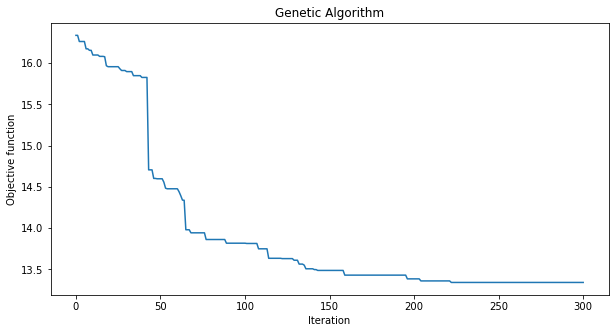

In [122]:
model_ga_top = geneticalgorithm(function=object_function_top,
                                dimension=12,
                                variable_type='int',
                                variable_boundaries=varbound,
                                algorithm_parameters=algorithm_param)

model_ga_top.run()

- iteration 150번째쯤에 사실상 최적점에는 도달

## GA  모델 결과 해석

## GA 통해 나온 결과 출력

In [123]:
convergence_top = model_ga_top.report
solution_top = model_ga_top.output_dict

print(convergence_top)
print(solution_top)

[16.335229097722063, 16.335229097722063, 16.260793800195152, 16.260793800195152, 16.260793800195152, 16.260793800195152, 16.172089301101256, 16.172089301101256, 16.153889923640318, 16.153889923640318, 16.097093338327376, 16.097093338327376, 16.097093338327376, 16.097093338327376, 16.080703704591244, 16.080703704591244, 16.080703704591244, 16.07644477134104, 15.967279272830442, 15.955553309421779, 15.955553309421779, 15.955553309421779, 15.955553309421779, 15.955553309421779, 15.955553309421779, 15.955553309421779, 15.9300327642262, 15.909655966009305, 15.909655966009305, 15.909655966009305, 15.896101688613431, 15.896101688613431, 15.896101688613431, 15.896101688613431, 15.847117160352093, 15.847117160352093, 15.847117160352093, 15.847117160352093, 15.847117160352093, 15.825673428391724, 15.825673428391724, 15.825673428391724, 15.825673428391724, 14.70636244888892, 14.70636244888892, 14.70636244888892, 14.602470434022022, 14.602470434022022, 14.59827812575148, 14.59827812575148, 14.5982

## GA 결과를 DataFrame으로 변환

In [124]:
ga_solution = input_conversion(solution_top['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title_mean_enc,category_id_mean_enc
0,8847197.00,1760126.00,1742485.00,703.00,20.00,5.03,5105.00,198.00,101.00,184.00,184.00,52611730.00,1566611.81


## GA로 예측한 Views의 Top 결과 

In [125]:
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'})

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category_id
0,8847197.00,1760126.00,1742485.00,703.00,20.00,5.03,5105.00,198.00,101.00,184.00,184.00,YouTube Spotlight,10


In [126]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category
0,8847197.00,1760126.00,1742485.00,703.00,20.00,5.03,5105.00,198.00,101.00,184.00,184.00,YouTube Spotlight,Music


In [134]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['Views'] = int(prediction[0])
ga_solution_top = ga_solution_df
ga_solution_top

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,8847197.00,1760126.00,1742485.00,703.00,20.00,5.03,5105.00,198.00,101.00,184.00,184.00,YouTube Spotlight,Music,69376751


- 원본데이터에서 가장 Views가 많았던 YouTubeSpotlight가 선정되었다.

## 결과 검토 및 분석: Top YouTuber

In [127]:
df_rgb2.describe()

,category_id,views,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
count,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00,6577.00
mean,21.15,370188.47,15301.17,521.44,2372.42,94.63,87.25,85.70,2.54,15822.61,21.59,107.75,7260.19,50.81,1084.92,9.76,428.04,43.32,370188.47,370188.47
std,6.78,1660059.60,103548.06,11321.39,18722.02,31.16,29.38,29.57,12.44,108524.80,17.97,419.01,46985.45,195.52,7529.31,48.08,535.27,19.57,1359203.08,371099.38
min,1.00,2623.00,2.00,0.00,0.00,6.00,6.00,4.00,1.00,2.00,1.00,0.16,0.04,0.01,0.00,0.19,1.00,4.00,2623.00,23327.10
25%,20.00,44549.00,677.00,20.00,151.00,74.00,68.00,66.00,2.00,735.00,8.00,14.14,332.50,6.39,66.50,2.79,118.00,28.00,61245.76,132860.43
50%,24.00,99510.00,2018.00,54.00,429.00,95.00,87.00,84.00,2.00,2136.00,17.00,35.10,995.67,16.43,199.33,5.14,256.00,41.00,123589.43,277000.79
75%,25.00,233890.00,4761.00,142.00,1087.00,116.00,106.00,105.00,2.00,4918.00,30.00,78.79,2398.50,37.74,522.00,9.06,527.00,55.00,242365.00,408503.16
max,43.00,62796390.00,4470923.00,884965.00,905925.00,201.00,188.00,188.00,706.00,4589976.00,126.00,5325.75,1529992.00,2662.88,301975.00,1071.00,5235.00,100.00,52611730.00,1678646.17


- Views의 최고값은 62796390회 (GA가 찾은 최고의 값은 53072006)
    - Median과 달리 Max값은 데이터가 1개 이기 때문에 GA를 통해 예측했을때 max값에 근접하기는 어렵다. (사실상 outlier)

## comment_count에 대한 의존성 확인

In [128]:
inf_input = copy.deepcopy(model_ga_top)

comment_count_dep_top = []

for i in tqdm_notebook(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_top.append([i, int(prediction)])

  0%|          | 0/906 [00:00<?, ?it/s]

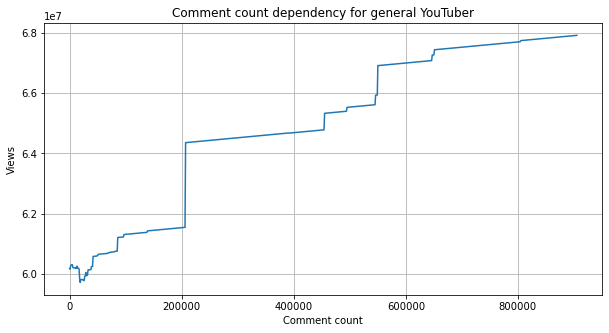

In [129]:
comment_count_dep_top_df = pd.DataFrame(comment_count_dep_top, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_top_df['comment_count'], comment_count_dep_top_df['views'])

In [135]:
# 해석용 GA 예측 데이터 출력
ga_solution_top

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,8847197.00,1760126.00,1742485.00,703.00,20.00,5.03,5105.00,198.00,101.00,184.00,184.00,YouTube Spotlight,Music,69376751


- GA에서 예측한 comment_count는 1742485(170만)이다. 
- comment_count가 하락하면 Views는 떨어진다.
- 다만 Views의 변동 범위를 보면, comment가 0개여도 조회수가 급격하게 줄지는 않는다는 것을 알 수 있다. 
    - 댓글이 없어도 6000만 Views 로 약 10%정도가 감소한다.
---
- 결론적으로 최고의 View를 갖고 있는 영상에서 comment의 수는 영향력이 크지 않다.

## positive_ratio에 대한 의존성 확인

In [136]:
inf_input = copy.deepcopy(model_ga_top)

positive_ratio_dep_top = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm_notebook(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_top.append([ratio, int(prediction)])

  0%|          | 0/500 [00:00<?, ?it/s]

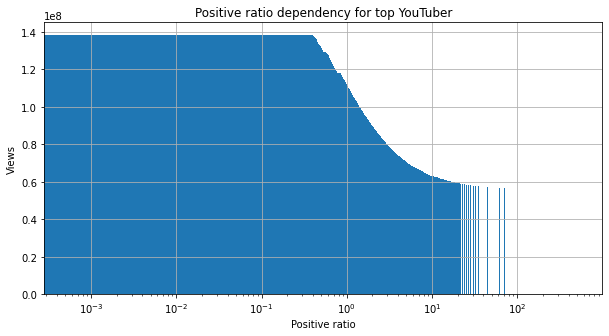

In [150]:
positive_ratio_dep_top_df = pd.DataFrame(positive_ratio_dep_top, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for top YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
#plt.ylim(60000000)
#plt.xlim(5)
plt.grid()
plt.bar(positive_ratio_dep_top_df['positive_ratio'], positive_ratio_dep_top_df['views']);

In [138]:
# 해석용 GA 예측 데이터 출력
ga_solution_top

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,8847197.00,1760126.00,1742485.00,703.00,20.00,5.03,5105.00,198.00,101.00,184.00,184.00,YouTube Spotlight,Music,69376751


- log scale의 그래프
- 기준점은 0.6 부근 (6000만 Views)
- 다만 높은 views를 가진 데이터의 수가 적고, 일종의 outlier같은 데이터 이다. 
- 이때문에 주변 데이터에 대한 완전한 검증이 이뤄지지 않고, 모델에 의존한 결과이다.
---
- positive_ratio가 변해도 일정 부분까지는 Views의 변화가 없다.(positive_ratio가 음수 = dislike 비율이 더 높은..)
- 되려 최적의 조회수인 0.6 부근에서는 positive_ratio가 증가할수록 views가 조금씩 떨어지고 있다. 
- 따라서 최적 조건의 영상에는 최적화된 positive_ratio가 존재한다. 
---
- positive_ratio상 dislike가 많아지는것도 어느정도 조회수 증가에 도움이 되는 것으로 보인다.

## number_of_tag 에 대한 의존성 확인

In [151]:
inf_input = copy.deepcopy(model_ga_top)

number_of_tag_dep_top = []

for i in tqdm_notebook(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_top.append([i, int(prediction)])

  0%|          | 0/125 [00:00<?, ?it/s]

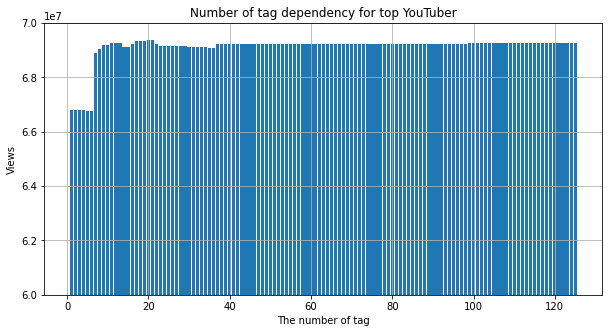

In [168]:
number_of_tag_dep_top_df = pd.DataFrame(number_of_tag_dep_top, columns=['number_of_tag', 'views'])

fig = plt.figure()
ax1 = fid.add_subplot(2,1,1)
ax2 = fid.add_subplot(2,1,2)

plt.title('Number of tag dependency for top YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.ylim(6e7, 7e7)
plt.grid()
plt.bar(number_of_tag_dep_top_df['number_of_tag'], number_of_tag_dep_top_df['views']);

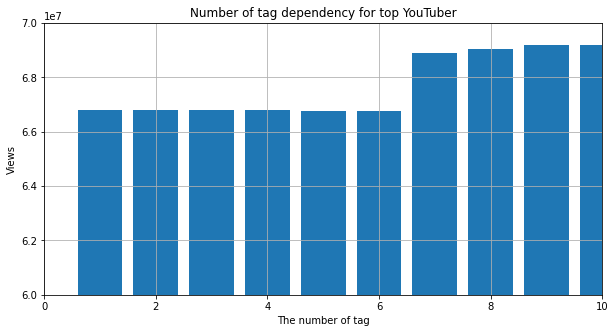

In [169]:
plt.title('Number of tag dependency for top YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.ylim(6e7, 7e7)
plt.xlim(0, 10)
plt.grid()
plt.bar(number_of_tag_dep_top_df['number_of_tag'], number_of_tag_dep_top_df['views']);

- tag 수에 따른 Views에 대한 영향은 거의 없다. = 중요하지 않은 feature이다.
- tag 수에 따른 변화는 거의 없지만 최적점은 5~6개 정도로 보여진다.

## 썸네일에 대한 의존성 확인

In [153]:
inf_input = copy.deepcopy(model_ga_top)

random_image_dep_top = []

for i in tqdm_notebook(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_top.append([i, int(prediction)])

  0%|          | 0/2000 [00:00<?, ?it/s]

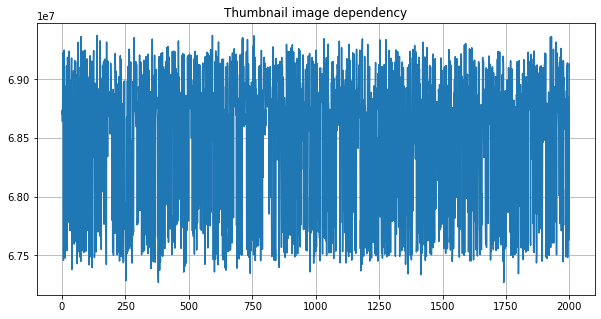

In [154]:
random_image_dep_top_df = pd.DataFrame(random_image_dep_top, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_top_df['Random_image'], random_image_dep_top_df['Views'])

Average views: 68473232.072
Median views: 68730413.0
Standard deviation of views [count]: 610020.8088953731
Standard deviation of views     [%]: 0.8908894621097084


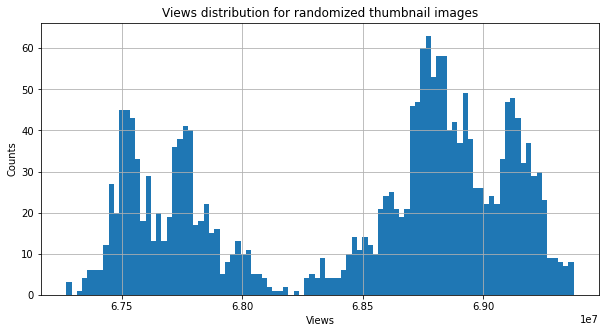

In [155]:
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_top_df['Views'], bins=96)

print('Average views:', random_image_dep_top_df['Views'].mean())
print('Median views:', random_image_dep_top_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_top_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_top_df['Views'].std()*100 / random_image_dep_top_df['Views'].mean())

In [162]:
# 해석용 GA 예측 데이터 출력
ga_solution_top

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,8847197.00,1760126.00,1742485.00,703.00,20.00,5.03,5105.00,198.00,101.00,184.00,184.00,YouTube Spotlight,Music,69376751


- Std 가 0.89%이다. 즉, Top 클래스 View의 영상은 썸네일의 영향을 굉장히 적게 받는다.

## channel_title에 대한 의존성 확인

In [156]:
inf_input = copy.deepcopy(model_ga_top)

channel_title_dep_top = []

for i in tqdm_notebook(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_top.append([mean_encode_channel.index[i], int(prediction)])

  0%|          | 0/1483 [00:00<?, ?it/s]

<BarContainer object of 1483 artists>

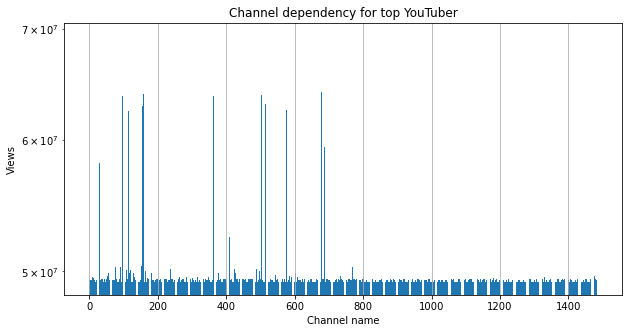

In [157]:
channel_title_dep_top_df = pd.DataFrame(channel_title_dep_top, columns=['channel_title', 'views'])

plt.title('Channel dependency for top YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_top_df['channel_title'])), channel_title_dep_top_df['views'])

- 소수 몇몇 영상만 매우 높은 views를 보여주고 , 나머지는 비슷한 수준으로 보인다.

In [158]:
channel_title_dep_top_df.sort_values(by='views', ascending=False).head(10)

,channel_title,views
625,YouTube Spotlight,69376751
177,FoxStarHindi,64569409
51,ArianaGrandeVevo,64208151
678,ibighit,64116989
55,AsapSCIENCE,64094866
549,TaylorSwiftVEVO,64022856
121,ChildishGambinoVEVO,63985722
158,Dude Perfect,63973690
503,Sony Pictures Entertainment,63843776
363,Marvel Entertainment,63815683


Average views: 49703509.344571814
Median views: 49403403.0
Standard deviation of views [count]: 1978072.907743935
Standard deviation of views     [%]: 3.9797449593163647


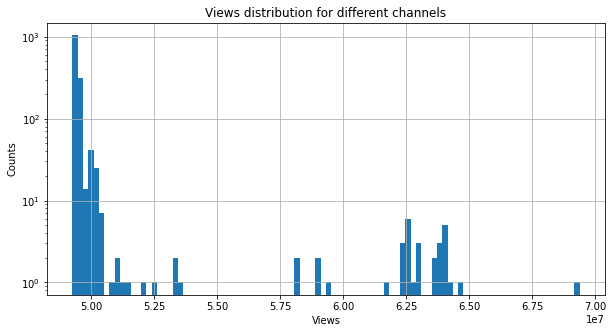

In [159]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_top_df['views'], bins=96)

print('Average views:', channel_title_dep_top_df['views'].mean())
print('Median views:', channel_title_dep_top_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_top_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_top_df['views'].std()*100 / channel_title_dep_top_df['views'].mean())

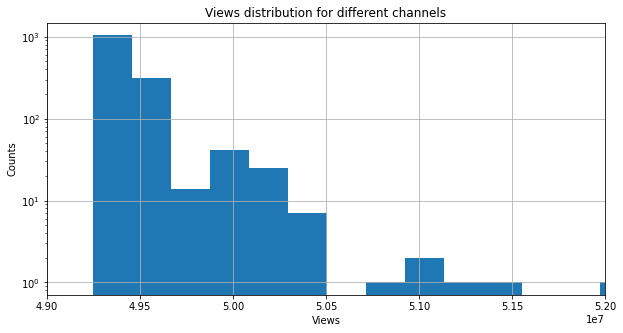

In [175]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.xlim(4.9e7, 5.2e7)
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_top_df['views'], bins=96);

- Std 가 3.9%로 최고의 views를 찍은 영상들은 channel_title에 의한 영향력이 매우 적다.
- Views로 보았을때 channel_title이 변경이 되어도 약 4900만회 정도의 views는 확보가 가능하다.

### 전체 데이터에서 views 기준 sort

In [176]:

df_rgb2.sort_values(by='views', ascending=False).head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
5587,7C2z4GqqS5E,2018-05-20,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390,4470923,119053,...,8,37.55,1529992.00,12.52,301975.00,5.07,784,35,15175929.12,1566611.81
811,FlsCjmMhFmw,2017-12-08,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",52611730,1891832,884965,...,37,2.14,925599.00,0.71,234263.33,3.95,710,50,52611730.00,408503.16
4377,i0p1bmr0EmE,2018-04-14,TWICE What is Love? M/V,jypentertainment,10,2018-04-09T08:59:51.000Z,"TWICE What is Love|""TWICE What is Love?""|""TWIC...",38840787,1111599,96407,...,35,11.53,201334.33,1.92,34439.83,5.85,498,23,6841437.70,1566611.81
553,6ZfuNTqbHE8,2017-11-30,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,2017-11-29T13:26:24.000Z,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",37736281,1735938,21972,...,11,79.01,878955.00,39.50,120621.00,7.29,448,55,12937435.83,408503.16
4741,u9Mv98Gr5pY,2018-04-25,VENOM - Official Trailer (HD),Sony Pictures Entertainment,24,2018-04-24T03:45:03.000Z,"Venom|""Venom Movie""|""Venom (2018)""|""Marvel""|""M...",27973210,850377,26543,...,24,32.04,438460.00,16.02,48383.50,9.06,493,29,13152488.33,408503.16


# 한계점
---
- 데이터 자체가 분석 목적에 fit한 데이터가 아니었다.
- 높은 조회수를 갖는 영상을 보여주기 위한 feature들이 다양하지 못하다.
- Views를 달성하는 과정에서 관측된 다른 feature들이 있었다면 좀 더 정확한 Views에 영향력을 미치는 요소들을 알 수 있었을 듯 하다.